In [ ]:
import os
import re
import cv2
import tarfile
import datetime
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import concat
from tensorflow import repeat
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import xml.etree.ElementTree as ET
from keras.models import load_model
from skimage.transform import resize
import nltk.translate.bleu_score as bleu
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.backend import expand_dims
from keras.layers import concatenate, Concatenate
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Layer, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting Structured Data :

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Major_Project/Data/cleaned_dataframe.csv')

In [ ]:
#Dataset taken from kaggle
#Refer : https://www.kaggle.com/usersan/chest-x-ray-indiana-u-frontal-or-lateral
projections = pd.read_csv("/content/drive/MyDrive/Major_Project/Data/indiana_projections.csv")
projections.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [ ]:
def front_lateral(lst):
    ''' This Function check the image projection of the different images
    and return frontal or lateral of the given image '''
    frontal = []
    lateral = ""
    for img in lst:
        projection = projections[projections['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", img).group())]['projection'].values
        if projection == "Lateral":
            lateral = img
        else:
            frontal.append(img)
    return frontal, lateral

In [ ]:
columns = ["front X-Ray", "lateral X-Ray", "findings"]

df = pd.DataFrame(columns = columns)
# Creating different DataFrame for single images,
# to distribute it in all train, test, validate datasets in equal proportion.
SingleImages_df = pd.DataFrame(columns = columns)

for item in tqdm(dataframe.iterrows()):
    img_lst = item[1]['image_name'].split(',')

    if len(img_lst) > 2:
        # Check projection of x-ray images
        frontal, lateral = front_lateral(img_lst)

        # If no lateral x-ray is present
        if lateral == "":
            frontal, lateral = frontal[:-1], frontal[-1]

        # If more than one frontal image is present
        for i in frontal:
            xray_front = i
            xray_lat = lateral
            # Use pd.concat instead of append
            df = pd.concat([df, pd.DataFrame([[xray_front, xray_lat, item[1]['findings']]], columns=columns)], ignore_index=True)

    elif len(img_lst) == 2:
        xray_front = img_lst[0]
        xray_lat = img_lst[1]
        # Use pd.concat instead of append
        df = pd.concat([df, pd.DataFrame([[xray_front, xray_lat, item[1]['findings']]], columns=columns)], ignore_index=True)

    elif len(img_lst) == 1:
        xray_front = img_lst[0]
        xray_lat = img_lst[0]
        # Use pd.concat instead of append
        SingleImages_df = pd.concat([SingleImages_df, pd.DataFrame([[xray_front, xray_lat, item[1]['findings']]], columns=columns)], ignore_index=True)

3851it [00:03, 1004.19it/s]


In [ ]:
train1, test1  = train_test_split(df, test_size = 0.10, random_state = 42, shuffle = True)
train1, valid1 = train_test_split(train1, test_size = 0.10, random_state = 42, shuffle = True)

print('train data :', train1.shape)
print('test data  :', test1.shape)
print('valid data :', valid1.shape)

train data : (2860, 3)
test data  : (354, 3)
valid data : (318, 3)


In [ ]:
train2, test2  = train_test_split(SingleImages_df, test_size = 0.10, random_state = 42, shuffle = True)
train2, valid2 = train_test_split(train2, test_size = 0.10, random_state = 42, shuffle = True)


print('train data :', train2.shape)
print('test data  :', test2.shape)
print('valid data :', valid2.shape)

train data : (360, 3)
test data  : (45, 3)
valid data : (41, 3)


###  Append Single image data equally with train test, and validation dataset :

In [ ]:
train = np.append(train1, train2, axis=0)
test = np.append(test1, test2, axis=0)
valid = np.append(valid1, valid2, axis=0)
print("===== Final data point shape =====")
train.shape, test.shape, valid.shape

===== Final data point shape =====


((3220, 3), (399, 3), (359, 3))

### Shuffle the data point :

In [ ]:
# Set a random state
from sklearn.utils import shuffle
for i in range(3):
    train = shuffle(train, random_state=15)
    test = shuffle(test, random_state=15)
    valid = shuffle(valid, random_state=15)

### Baseline Model

**load structured data :**

In [ ]:
train= train[:-20,:]
train.shape

(3200, 3)

In [ ]:
validation = valid[:-9,:]
validation.shape

(350, 3)

In [ ]:
columns = ["front X-Ray", "lateral X-Ray", "findings"]

train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns)
validation = pd.DataFrame(validation, columns = columns)

**Add start and end token and prepare decoder input with output :**

In [ ]:
def decoder_io(df):
  '''This function Add start and end token in finding feature and prepare decoder input with output
  It takes dataframe(df) as parameter and returns df after applying necessary operations. '''

  df['dec_ip'] = '<start>' + ' ' + df.findings.astype(str)  #Decoder input
  df['dec_op'] = df.findings.astype(str) + ' ' +'<end>'     #Decoder output
  df['findings']      = '<start> ' + df.findings + ' <end>'
  return df

In [ ]:
train = decoder_io(train)
validation = decoder_io(validation)
test = decoder_io(test)

In [ ]:
train.head()

,front X-Ray,lateral X-Ray,findings,dec_ip,dec_op
0,CXR167_IM-0441-1001.png,CXR167_IM-0441-1002.png,<start> both lungs are clear and expanded an o...,<start> both lungs are clear and expanded an o...,both lungs are clear and expanded an old calci...
1,CXR2561_IM-1064-1001.png,CXR2561_IM-1064-1001.png,<start> lungs are clear bilaterally cardiac an...,<start> lungs are clear bilaterally cardiac an...,lungs are clear bilaterally cardiac and medias...
2,CXR2592_IM-1084-2001.png,CXR2592_IM-1084-1001.png,<start> the lungs are clear there is no pleura...,<start> the lungs are clear there is no pleura...,the lungs are clear there is no pleural effusi...
3,CXR218_IM-0792-0001.png,CXR218_IM-0792-4004.png,<start> heart size is unchanged aortic calcifi...,<start> heart size is unchanged aortic calcifi...,heart size is unchanged aortic calcification i...
4,CXR55_IM-2154-2001.png,CXR55_IM-2154-1001.png,<start> lung lines remain low however no focal...,<start> lung lines remain low however no focal...,lung lines remain low however no focal infiltr...


**Transfer Learning : CHeXNET Model (pretrained)**

CheXNET Model is a Denset121 layered model which is trained on 112,120 number of chest x-ray images for the classification of 14 diseases. We can load the weights of that model and pass the image through that model. The top layer will be ignored.

In [ ]:
image_model = DenseNet121(weights='/content/drive/MyDrive/Major_Project/Model/brucechou1983_CheXNet_Keras_0.3.0_weights.h5', classes = 14, input_shape=(256,256,3))

In [ ]:
model = Model(image_model.input, image_model.layers[-2].output)

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_1_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

**Image to tensor convert :**

In [ ]:
def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (256,256,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)

  return X

In [ ]:
def image(df):
    '''
    input -- dataframe(df)
    output -- dataframe(df)
    process - convert images into 256 X 256, then using CheXNet model generate tensor(concate two image tensor)
    '''
    path = '/content/images/'
    image1_paths = df['front X-Ray'].astype(str).tolist()
    image2_paths = df['lateral X-Ray'].astype(str).tolist()

    image_features = []
    for i in tqdm(range(len(image1_paths))):

        i1 = load_image(path + image1_paths[i])
        i2 = load_image(path + image2_paths[i])
        img1_features = model.predict(i1)
        img2_features = model.predict(i2)
        img1_features = np.vstack(img1_features).astype(np.float64)  # Use np.float64
        img2_features = np.vstack(img2_features).astype(np.float64)  # Use np.float64

        tensor = np.concatenate((img1_features, img2_features), axis=1)

        image_features.append(tensor)
    df['image_features'] = image_features
    return df

In [ ]:
!wget --header="Host: openi.nlm.nih.gov" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://openi.nlm.nih.gov/faq" --header="Cookie: ncbi_sid=8A1BC6C8FFB50A11_1682SID; pmc.article.report=; _ga=GA1.2.1024901484.1610305706; lbnodeid=909381250.47873.0000; _ga=GA1.4.1024901484.1610305706; JSESSIONID=BD77221C4057639243BF80CB72FE15EA; _gid=GA1.2.1261986835.1621316665; _gid=GA1.4.1261986835.1621316665; _gat=1; _gat_nlmtracker=1; _gat_UA-137948717-1=1" --header="Connection: keep-alive" "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz" -c -O 'NLMCXR_png.tgz'

--2025-02-06 11:57:29--  https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
Resolving openi.nlm.nih.gov (openi.nlm.nih.gov)... 130.14.65.157, 2607:f220:41e:7065::157
Connecting to openi.nlm.nih.gov (openi.nlm.nih.gov)|130.14.65.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1360814128 (1.3G) [application/x-gzip]
Saving to: ‘NLMCXR_png.tgz’

NLMCXR_png.tgz      100%[===================>]   1.27G  8.99MB/s    in 2m 24s  

2025-02-06 11:59:53 (9.01 MB/s) - ‘NLMCXR_png.tgz’ saved [1360814128/1360814128]



In [ ]:
import tarfile
cwd = os.getcwd()
images = tarfile.open('/content/NLMCXR_png.tgz')
images.extractall(cwd+'/images/')

In [ ]:
train = image(train)
test = image(test)
validation = image(validation)

  0%|          | 0/3200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 1/3200 [00:15<13:29:24, 15.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 2/3200 [00:15<5:41:37,  6.41s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  0%|          | 3/3200 [00:15<3:11:58,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 4/3200 [00:15<2:02:08,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 5/3200 [00:16<1:23:36,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 6/3200 [00:16<1:00:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 7/3200 [00:16<45:21,  1.17it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 8/3200 [00:17<35:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 9/3200 [00:17<29:15,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  0%|          | 10/3200 [00:17<24:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  0%|          | 11/3200 [00:18<22:42,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  0%|          | 12/3200 [00:18<21:27,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  0%|          | 13/3200 [00:18<20:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  0%|          | 14/3200 [00:19<19:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  0%|          | 15/3200 [00:19<19:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  0%|          | 16/3200 [00:19<19:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  1%|          | 17/3200 [00:20<19:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  1%|          | 18/3200 [00:20<19:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  1%|          | 19/3200 [00:20<19:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  1%|          | 20/3200 [00:21<19:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|          | 21/3200 [00:21<19:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  1%|          | 22/3200 [00:22<20:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|          | 23/3200 [00:22<20:52,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  1%|          | 24/3200 [00:22<23:02,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 25/3200 [00:23<21:46,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 26/3200 [00:23<19:56,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 27/3200 [00:23<18:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 28/3200 [00:24<16:54,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 29/3200 [00:24<15:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  1%|          | 30/3200 [00:24<15:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 31/3200 [00:24<14:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 32/3200 [00:25<14:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 33/3200 [00:25<14:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  1%|          | 34/3200 [00:25<14:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 35/3200 [00:26<14:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 36/3200 [00:26<14:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 37/3200 [00:26<14:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 38/3200 [00:26<14:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 39/3200 [00:27<14:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▏         | 40/3200 [00:27<14:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▏         | 41/3200 [00:27<14:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▏         | 42/3200 [00:27<13:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▏         | 43/3200 [00:28<13:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▏         | 44/3200 [00:28<14:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  1%|▏         | 45/3200 [00:28<13:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▏         | 46/3200 [00:28<13:17,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▏         | 47/3200 [00:29<13:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 48/3200 [00:29<13:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  2%|▏         | 49/3200 [00:29<14:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 50/3200 [00:30<13:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 51/3200 [00:30<14:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 52/3200 [00:30<13:31,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 53/3200 [00:30<13:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 54/3200 [00:31<13:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 55/3200 [00:31<14:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 56/3200 [00:31<13:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 57/3200 [00:31<14:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 58/3200 [00:32<14:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 59/3200 [00:32<13:39,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  2%|▏         | 60/3200 [00:32<13:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 61/3200 [00:32<14:22,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  2%|▏         | 62/3200 [00:33<14:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  2%|▏         | 63/3200 [00:33<15:49,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  2%|▏         | 64/3200 [00:33<16:58,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  2%|▏         | 65/3200 [00:34<17:24,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  2%|▏         | 66/3200 [00:34<18:08,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▏         | 67/3200 [00:35<18:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 68/3200 [00:35<17:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  2%|▏         | 69/3200 [00:35<18:24,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  2%|▏         | 70/3200 [00:36<18:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  2%|▏         | 71/3200 [00:36<18:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  2%|▏         | 72/3200 [00:36<20:38,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  2%|▏         | 73/3200 [00:37<20:38,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  2%|▏         | 74/3200 [00:37<21:33,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  2%|▏         | 75/3200 [00:38<23:04,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  2%|▏         | 76/3200 [00:38<23:30,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 77/3200 [00:39<20:51,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 78/3200 [00:39<18:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 79/3200 [00:39<16:46,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▎         | 80/3200 [00:39<16:00,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 81/3200 [00:40<15:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 82/3200 [00:40<15:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 83/3200 [00:40<14:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 84/3200 [00:40<13:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 85/3200 [00:41<13:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 86/3200 [00:41<13:30,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  3%|▎         | 87/3200 [00:41<13:27,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 88/3200 [00:41<13:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 89/3200 [00:42<13:22,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 90/3200 [00:42<13:25,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 91/3200 [00:42<13:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 92/3200 [00:42<13:26,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 93/3200 [00:43<13:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 94/3200 [00:43<13:32,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|▎         | 95/3200 [00:43<13:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 96/3200 [00:44<13:27,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 97/3200 [00:44<14:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 98/3200 [00:44<14:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 99/3200 [00:44<14:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  3%|▎         | 100/3200 [00:45<15:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 101/3200 [00:45<14:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  3%|▎         | 102/3200 [00:45<14:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 103/3200 [00:45<13:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 104/3200 [00:46<14:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 105/3200 [00:46<13:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 106/3200 [00:46<14:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 107/3200 [00:47<14:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 108/3200 [00:47<13:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 109/3200 [00:47<13:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 110/3200 [00:47<13:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 111/3200 [00:48<13:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▎         | 112/3200 [00:48<13:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|▎         | 113/3200 [00:48<13:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  4%|▎         | 114/3200 [00:49<14:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  4%|▎         | 115/3200 [00:49<16:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  4%|▎         | 116/3200 [00:49<16:27,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▎         | 117/3200 [00:50<16:26,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  4%|▎         | 118/3200 [00:50<17:24,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▎         | 119/3200 [00:50<18:03,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  4%|▍         | 120/3200 [00:51<18:00,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  4%|▍         | 121/3200 [00:51<18:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  4%|▍         | 122/3200 [00:51<18:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  4%|▍         | 123/3200 [00:52<18:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  4%|▍         | 124/3200 [00:52<19:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  4%|▍         | 125/3200 [00:53<22:19,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  4%|▍         | 126/3200 [00:53<23:39,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  4%|▍         | 127/3200 [00:54<24:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 128/3200 [00:54<22:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  4%|▍         | 129/3200 [00:54<19:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 130/3200 [00:55<17:46,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▍         | 131/3200 [00:55<16:19,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  4%|▍         | 132/3200 [00:55<15:42,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▍         | 133/3200 [00:55<15:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 134/3200 [00:56<15:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 135/3200 [00:56<14:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  4%|▍         | 136/3200 [00:56<14:47,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 137/3200 [00:57<14:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|▍         | 138/3200 [00:57<14:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▍         | 139/3200 [00:57<14:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|▍         | 140/3200 [00:57<14:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  4%|▍         | 141/3200 [00:58<14:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 142/3200 [00:58<14:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  4%|▍         | 143/3200 [00:58<13:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 144/3200 [00:58<14:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▍         | 145/3200 [00:59<14:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▍         | 146/3200 [00:59<13:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 147/3200 [00:59<13:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 148/3200 [01:00<13:31,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 149/3200 [01:00<13:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 150/3200 [01:00<13:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 151/3200 [01:00<14:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 152/3200 [01:01<14:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 153/3200 [01:01<13:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  5%|▍         | 154/3200 [01:01<14:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 155/3200 [01:01<13:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▍         | 156/3200 [01:02<13:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 157/3200 [01:02<13:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  5%|▍         | 158/3200 [01:02<13:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▍         | 159/3200 [01:03<13:32,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▌         | 160/3200 [01:03<13:14,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▌         | 161/3200 [01:03<12:56,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  5%|▌         | 162/3200 [01:03<13:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▌         | 163/3200 [01:04<13:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▌         | 164/3200 [01:04<13:27,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  5%|▌         | 165/3200 [01:04<14:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  5%|▌         | 166/3200 [01:05<15:28,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  5%|▌         | 167/3200 [01:05<15:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  5%|▌         | 168/3200 [01:05<17:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  5%|▌         | 169/3200 [01:06<18:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  5%|▌         | 170/3200 [01:06<17:43,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  5%|▌         | 171/3200 [01:06<17:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  5%|▌         | 172/3200 [01:07<17:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  5%|▌         | 173/3200 [01:07<18:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


  5%|▌         | 174/3200 [01:08<20:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  5%|▌         | 175/3200 [01:08<20:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|▌         | 176/3200 [01:09<22:24,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  6%|▌         | 177/3200 [01:09<23:31,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  6%|▌         | 178/3200 [01:10<24:25,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▌         | 179/3200 [01:10<20:51,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 180/3200 [01:10<18:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  6%|▌         | 181/3200 [01:10<17:03,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  6%|▌         | 182/3200 [01:11<15:52,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  6%|▌         | 183/3200 [01:11<15:14,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 184/3200 [01:11<14:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▌         | 185/3200 [01:11<14:43,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 186/3200 [01:12<14:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 187/3200 [01:12<14:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 188/3200 [01:12<14:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 189/3200 [01:13<13:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▌         | 190/3200 [01:13<13:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 191/3200 [01:13<13:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 192/3200 [01:13<14:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|▌         | 193/3200 [01:14<13:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 194/3200 [01:14<13:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  6%|▌         | 195/3200 [01:14<14:09,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 196/3200 [01:15<13:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|▌         | 197/3200 [01:15<13:16,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 198/3200 [01:15<13:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 199/3200 [01:15<13:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▋         | 200/3200 [01:16<13:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▋         | 201/3200 [01:16<13:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▋         | 202/3200 [01:16<12:56,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▋         | 203/3200 [01:16<13:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▋         | 204/3200 [01:17<13:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|▋         | 205/3200 [01:17<14:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|▋         | 206/3200 [01:17<14:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▋         | 207/3200 [01:17<13:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▋         | 208/3200 [01:18<13:11,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 209/3200 [01:18<13:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  7%|▋         | 210/3200 [01:18<13:17,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 211/3200 [01:19<13:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|▋         | 212/3200 [01:19<13:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  7%|▋         | 213/3200 [01:19<13:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 214/3200 [01:19<13:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 215/3200 [01:20<13:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  7%|▋         | 216/3200 [01:20<14:49,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  7%|▋         | 217/3200 [01:20<16:55,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  7%|▋         | 218/3200 [01:21<16:58,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  7%|▋         | 219/3200 [01:21<17:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  7%|▋         | 220/3200 [01:22<17:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  7%|▋         | 221/3200 [01:22<17:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  7%|▋         | 222/3200 [01:22<18:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  7%|▋         | 223/3200 [01:23<18:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  7%|▋         | 224/3200 [01:23<18:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  7%|▋         | 225/3200 [01:23<18:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  7%|▋         | 226/3200 [01:24<20:05,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  7%|▋         | 227/3200 [01:24<22:36,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  7%|▋         | 228/3200 [01:25<22:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  7%|▋         | 229/3200 [01:25<23:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 230/3200 [01:26<19:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 231/3200 [01:26<18:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  7%|▋         | 232/3200 [01:26<16:37,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 233/3200 [01:27<16:06,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 234/3200 [01:27<15:29,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 235/3200 [01:27<14:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|▋         | 236/3200 [01:27<14:50,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 237/3200 [01:28<14:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 238/3200 [01:28<13:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 239/3200 [01:28<13:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 240/3200 [01:28<13:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 241/3200 [01:29<13:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 242/3200 [01:29<13:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|▊         | 243/3200 [01:29<13:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 244/3200 [01:29<13:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 245/3200 [01:30<12:37,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 246/3200 [01:30<12:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 247/3200 [01:30<13:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 248/3200 [01:31<13:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 249/3200 [01:31<13:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 250/3200 [01:31<13:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 251/3200 [01:31<13:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|▊         | 252/3200 [01:32<13:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  8%|▊         | 253/3200 [01:32<13:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  8%|▊         | 254/3200 [01:32<14:22,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 255/3200 [01:33<13:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 256/3200 [01:33<13:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 257/3200 [01:33<13:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|▊         | 258/3200 [01:33<13:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 259/3200 [01:34<13:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 260/3200 [01:34<13:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 261/3200 [01:34<13:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 262/3200 [01:34<13:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 263/3200 [01:35<13:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 264/3200 [01:35<13:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|▊         | 265/3200 [01:35<13:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  8%|▊         | 266/3200 [01:36<14:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  8%|▊         | 267/3200 [01:36<15:06,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  8%|▊         | 268/3200 [01:36<15:43,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  8%|▊         | 269/3200 [01:37<17:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  8%|▊         | 270/3200 [01:37<17:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  8%|▊         | 271/3200 [01:37<17:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  8%|▊         | 272/3200 [01:38<17:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  9%|▊         | 273/3200 [01:38<19:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  9%|▊         | 274/3200 [01:39<18:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  9%|▊         | 275/3200 [01:39<18:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  9%|▊         | 276/3200 [01:39<18:48,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  9%|▊         | 277/3200 [01:40<21:27,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  9%|▊         | 278/3200 [01:40<22:04,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  9%|▊         | 279/3200 [01:41<21:45,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  9%|▉         | 280/3200 [01:41<21:20,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 281/3200 [01:42<18:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▉         | 282/3200 [01:42<17:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 283/3200 [01:42<15:53,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 284/3200 [01:42<15:24,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▉         | 285/3200 [01:43<14:50,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 286/3200 [01:43<14:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  9%|▉         | 287/3200 [01:43<14:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 288/3200 [01:43<13:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 289/3200 [01:44<13:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▉         | 290/3200 [01:44<13:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 291/3200 [01:44<13:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▉         | 292/3200 [01:45<13:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 293/3200 [01:45<12:38,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▉         | 294/3200 [01:45<12:41,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 295/3200 [01:45<12:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 296/3200 [01:46<12:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 297/3200 [01:46<12:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  9%|▉         | 298/3200 [01:46<12:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▉         | 299/3200 [01:46<12:34,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 300/3200 [01:47<12:30,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▉         | 301/3200 [01:47<12:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  9%|▉         | 302/3200 [01:47<12:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 303/3200 [01:47<12:51,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 304/3200 [01:48<12:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 305/3200 [01:48<12:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|▉         | 306/3200 [01:48<12:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 307/3200 [01:49<12:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 308/3200 [01:49<12:26,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 309/3200 [01:49<12:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|▉         | 310/3200 [01:49<13:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 311/3200 [01:50<13:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|▉         | 312/3200 [01:50<13:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|▉         | 313/3200 [01:50<13:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 314/3200 [01:50<13:51,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|▉         | 315/3200 [01:51<13:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 316/3200 [01:51<13:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 317/3200 [01:51<13:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 10%|▉         | 318/3200 [01:52<14:49,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 10%|▉         | 319/3200 [01:52<15:30,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 10%|█         | 320/3200 [01:52<16:29,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 10%|█         | 321/3200 [01:53<16:31,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 10%|█         | 322/3200 [01:53<16:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|█         | 323/3200 [01:54<17:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 10%|█         | 324/3200 [01:54<18:54,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 10%|█         | 325/3200 [01:54<18:55,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 10%|█         | 326/3200 [01:55<18:23,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 10%|█         | 327/3200 [01:55<18:31,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 10%|█         | 328/3200 [01:56<18:51,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 10%|█         | 329/3200 [01:56<18:56,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 10%|█         | 330/3200 [01:56<20:39,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 10%|█         | 331/3200 [01:57<21:38,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|█         | 332/3200 [01:57<20:33,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|█         | 333/3200 [01:58<18:14,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|█         | 334/3200 [01:58<16:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 10%|█         | 335/3200 [01:58<15:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|█         | 336/3200 [01:58<14:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 337/3200 [01:59<14:20,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 338/3200 [01:59<14:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 339/3200 [01:59<13:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 340/3200 [02:00<13:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 341/3200 [02:00<13:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 342/3200 [02:00<12:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|█         | 343/3200 [02:00<13:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 344/3200 [02:01<13:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 11%|█         | 345/3200 [02:01<13:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 11%|█         | 346/3200 [02:01<13:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 11%|█         | 347/3200 [02:02<14:44,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|█         | 348/3200 [02:02<15:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 11%|█         | 349/3200 [02:02<15:55,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 11%|█         | 350/3200 [02:03<16:21,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 11%|█         | 351/3200 [02:03<16:38,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 11%|█         | 352/3200 [02:03<16:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 11%|█         | 353/3200 [02:04<18:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 11%|█         | 354/3200 [02:04<17:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|█         | 355/3200 [02:05<18:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 11%|█         | 356/3200 [02:05<19:23,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 11%|█         | 357/3200 [02:06<20:48,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 11%|█         | 358/3200 [02:06<20:27,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 11%|█         | 359/3200 [02:06<21:32,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 11%|█▏        | 360/3200 [02:07<22:47,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 11%|█▏        | 361/3200 [02:07<20:30,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 11%|█▏        | 362/3200 [02:08<19:52,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 11%|█▏        | 363/3200 [02:08<21:40,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 11%|█▏        | 364/3200 [02:09<20:15,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 11%|█▏        | 365/3200 [02:09<20:09,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 11%|█▏        | 366/3200 [02:09<19:19,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 11%|█▏        | 367/3200 [02:10<18:48,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 12%|█▏        | 368/3200 [02:10<19:35,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 12%|█▏        | 369/3200 [02:11<20:15,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 12%|█▏        | 370/3200 [02:11<19:22,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 12%|█▏        | 371/3200 [02:12<19:36,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 12%|█▏        | 372/3200 [02:12<19:38,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 12%|█▏        | 373/3200 [02:13<22:24,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 12%|█▏        | 374/3200 [02:13<23:07,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|█▏        | 375/3200 [02:13<20:36,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 376/3200 [02:14<18:33,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 377/3200 [02:14<16:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 12%|█▏        | 378/3200 [02:14<15:43,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|█▏        | 379/3200 [02:15<15:04,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 12%|█▏        | 380/3200 [02:15<14:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 381/3200 [02:15<13:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 382/3200 [02:15<13:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 383/3200 [02:16<13:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|█▏        | 384/3200 [02:16<12:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 12%|█▏        | 385/3200 [02:16<13:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 386/3200 [02:16<12:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 387/3200 [02:17<12:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 388/3200 [02:17<13:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|█▏        | 389/3200 [02:17<12:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▏        | 390/3200 [02:18<12:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|█▏        | 391/3200 [02:18<12:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|█▏        | 392/3200 [02:18<12:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 12%|█▏        | 393/3200 [02:18<12:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 394/3200 [02:19<13:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 395/3200 [02:19<12:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 12%|█▏        | 396/3200 [02:19<13:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 397/3200 [02:19<13:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 398/3200 [02:20<12:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 399/3200 [02:20<12:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▎        | 400/3200 [02:20<13:16,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█▎        | 401/3200 [02:21<13:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 13%|█▎        | 402/3200 [02:21<13:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 403/3200 [02:21<12:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 13%|█▎        | 404/3200 [02:21<13:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 13%|█▎        | 405/3200 [02:22<13:37,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█▎        | 406/3200 [02:22<12:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 13%|█▎        | 407/3200 [02:22<12:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 13%|█▎        | 408/3200 [02:23<12:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 13%|█▎        | 409/3200 [02:23<12:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█▎        | 410/3200 [02:23<11:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 13%|█▎        | 411/3200 [02:23<14:46,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 13%|█▎        | 412/3200 [02:24<14:55,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 13%|█▎        | 413/3200 [02:24<15:21,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 13%|█▎        | 414/3200 [02:25<15:38,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 13%|█▎        | 415/3200 [02:25<15:57,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 13%|█▎        | 416/3200 [02:25<15:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 13%|█▎        | 417/3200 [02:26<16:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 13%|█▎        | 418/3200 [02:26<16:13,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█▎        | 419/3200 [02:26<16:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 13%|█▎        | 420/3200 [02:27<18:10,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 13%|█▎        | 421/3200 [02:27<18:32,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 13%|█▎        | 422/3200 [02:28<19:54,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 13%|█▎        | 423/3200 [02:28<20:02,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 13%|█▎        | 424/3200 [02:29<19:59,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 13%|█▎        | 425/3200 [02:29<20:49,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 13%|█▎        | 426/3200 [02:29<18:42,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 13%|█▎        | 427/3200 [02:30<17:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 428/3200 [02:30<15:41,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 429/3200 [02:30<14:50,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 430/3200 [02:30<14:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 431/3200 [02:31<13:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▎        | 432/3200 [02:31<13:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▎        | 433/3200 [02:31<13:30,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▎        | 434/3200 [02:32<13:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▎        | 435/3200 [02:32<13:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▎        | 436/3200 [02:32<12:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▎        | 437/3200 [02:32<12:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▎        | 438/3200 [02:33<13:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 14%|█▎        | 439/3200 [02:33<13:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 440/3200 [02:33<13:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 441/3200 [02:34<12:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 442/3200 [02:34<12:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 443/3200 [02:34<12:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 444/3200 [02:34<12:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 445/3200 [02:35<13:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 446/3200 [02:35<13:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 447/3200 [02:35<13:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 448/3200 [02:36<12:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 449/3200 [02:36<12:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 14%|█▍        | 450/3200 [02:36<12:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 14%|█▍        | 451/3200 [02:36<13:23,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 452/3200 [02:37<13:09,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 453/3200 [02:37<13:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 14%|█▍        | 454/3200 [02:37<13:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 14%|█▍        | 455/3200 [02:38<12:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 456/3200 [02:38<12:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 457/3200 [02:38<12:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 458/3200 [02:38<13:18,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 459/3200 [02:39<13:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 460/3200 [02:39<13:03,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 14%|█▍        | 461/3200 [02:39<13:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 14%|█▍        | 462/3200 [02:40<14:50,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 14%|█▍        | 463/3200 [02:40<15:10,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 14%|█▍        | 464/3200 [02:40<16:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 15%|█▍        | 465/3200 [02:41<17:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 15%|█▍        | 466/3200 [02:41<17:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 15%|█▍        | 467/3200 [02:42<17:28,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 15%|█▍        | 468/3200 [02:42<17:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 15%|█▍        | 469/3200 [02:43<18:42,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 15%|█▍        | 470/3200 [02:43<18:29,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 15%|█▍        | 471/3200 [02:43<20:40,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 15%|█▍        | 472/3200 [02:44<20:43,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 15%|█▍        | 473/3200 [02:45<22:37,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▍        | 474/3200 [02:45<21:13,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 15%|█▍        | 475/3200 [02:45<18:46,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 15%|█▍        | 476/3200 [02:46<17:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 15%|█▍        | 477/3200 [02:46<16:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▍        | 478/3200 [02:46<15:17,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▍        | 479/3200 [02:46<14:31,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▌        | 480/3200 [02:47<13:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 481/3200 [02:47<13:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 15%|█▌        | 482/3200 [02:47<13:25,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 15%|█▌        | 483/3200 [02:48<13:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▌        | 484/3200 [02:48<13:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 485/3200 [02:48<12:38,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 15%|█▌        | 486/3200 [02:48<12:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▌        | 487/3200 [02:49<12:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▌        | 488/3200 [02:49<12:39,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 489/3200 [02:49<12:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 490/3200 [02:49<12:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▌        | 491/3200 [02:50<12:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 15%|█▌        | 492/3200 [02:50<12:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▌        | 493/3200 [02:50<13:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 15%|█▌        | 494/3200 [02:51<13:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▌        | 495/3200 [02:51<13:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 496/3200 [02:51<12:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 497/3200 [02:51<13:10,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 16%|█▌        | 498/3200 [02:52<13:38,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 499/3200 [02:52<13:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 500/3200 [02:52<12:58,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 16%|█▌        | 501/3200 [02:53<12:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 502/3200 [02:53<12:52,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 503/3200 [02:53<12:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 504/3200 [02:54<12:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 505/3200 [02:54<12:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 506/3200 [02:54<12:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 507/3200 [02:54<12:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 508/3200 [02:55<12:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 16%|█▌        | 509/3200 [02:55<12:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 16%|█▌        | 510/3200 [02:55<15:06,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 16%|█▌        | 511/3200 [02:56<15:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 16%|█▌        | 512/3200 [02:56<15:36,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 16%|█▌        | 513/3200 [02:56<15:58,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 16%|█▌        | 514/3200 [02:57<17:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 16%|█▌        | 515/3200 [02:57<17:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 16%|█▌        | 516/3200 [02:58<17:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 16%|█▌        | 517/3200 [02:58<17:39,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 16%|█▌        | 518/3200 [02:59<18:21,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 16%|█▌        | 519/3200 [02:59<18:32,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 16%|█▋        | 520/3200 [02:59<18:43,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 16%|█▋        | 521/3200 [03:00<19:28,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 16%|█▋        | 522/3200 [03:00<20:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 16%|█▋        | 523/3200 [03:01<19:43,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▋        | 524/3200 [03:01<17:52,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▋        | 525/3200 [03:01<16:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▋        | 526/3200 [03:02<15:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▋        | 527/3200 [03:02<13:51,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 16%|█▋        | 528/3200 [03:02<13:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 529/3200 [03:02<13:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 530/3200 [03:03<12:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 531/3200 [03:03<12:52,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 532/3200 [03:03<13:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 533/3200 [03:04<12:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 534/3200 [03:04<12:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 17%|█▋        | 535/3200 [03:04<12:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 536/3200 [03:04<12:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 537/3200 [03:05<12:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 538/3200 [03:05<12:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 17%|█▋        | 539/3200 [03:05<12:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 540/3200 [03:06<12:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 541/3200 [03:06<12:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 542/3200 [03:06<12:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 543/3200 [03:06<13:00,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 544/3200 [03:07<12:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 545/3200 [03:07<12:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 546/3200 [03:07<12:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 547/3200 [03:08<12:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 17%|█▋        | 548/3200 [03:08<12:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 549/3200 [03:08<12:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 550/3200 [03:08<12:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 551/3200 [03:09<12:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 552/3200 [03:09<12:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 553/3200 [03:09<12:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 17%|█▋        | 554/3200 [03:10<12:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 17%|█▋        | 555/3200 [03:10<12:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 556/3200 [03:10<12:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 17%|█▋        | 557/3200 [03:10<12:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 17%|█▋        | 558/3200 [03:11<12:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 17%|█▋        | 559/3200 [03:11<12:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 18%|█▊        | 560/3200 [03:11<15:02,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 18%|█▊        | 561/3200 [03:12<15:43,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 18%|█▊        | 562/3200 [03:12<15:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 18%|█▊        | 563/3200 [03:13<15:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 18%|█▊        | 564/3200 [03:13<16:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 18%|█▊        | 565/3200 [03:13<17:25,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 18%|█▊        | 566/3200 [03:14<18:39,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 18%|█▊        | 567/3200 [03:14<19:17,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 18%|█▊        | 568/3200 [03:15<19:42,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 18%|█▊        | 569/3200 [03:15<19:32,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 18%|█▊        | 570/3200 [03:16<20:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 18%|█▊        | 571/3200 [03:16<20:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 18%|█▊        | 572/3200 [03:17<19:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 573/3200 [03:17<17:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 574/3200 [03:17<15:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 575/3200 [03:17<14:35,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 576/3200 [03:18<13:58,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 577/3200 [03:18<13:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 18%|█▊        | 578/3200 [03:18<13:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 579/3200 [03:19<12:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 580/3200 [03:19<12:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 581/3200 [03:19<12:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 582/3200 [03:19<12:55,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 583/3200 [03:20<13:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 584/3200 [03:20<12:57,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 18%|█▊        | 585/3200 [03:20<12:59,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 586/3200 [03:21<13:02,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 587/3200 [03:21<12:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 18%|█▊        | 588/3200 [03:21<12:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 589/3200 [03:21<12:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|█▊        | 590/3200 [03:22<13:10,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 591/3200 [03:22<13:16,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 592/3200 [03:22<13:16,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▊        | 593/3200 [03:23<12:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▊        | 594/3200 [03:23<12:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 19%|█▊        | 595/3200 [03:23<12:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▊        | 596/3200 [03:24<12:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▊        | 597/3200 [03:24<12:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▊        | 598/3200 [03:24<12:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▊        | 599/3200 [03:24<12:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 19%|█▉        | 600/3200 [03:25<12:41,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 601/3200 [03:25<12:59,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▉        | 602/3200 [03:25<12:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 603/3200 [03:26<12:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 604/3200 [03:26<12:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 605/3200 [03:26<11:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 606/3200 [03:26<11:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 19%|█▉        | 607/3200 [03:27<12:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 19%|█▉        | 608/3200 [03:27<14:42,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 19%|█▉        | 609/3200 [03:28<15:12,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 19%|█▉        | 610/3200 [03:28<15:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 19%|█▉        | 611/3200 [03:28<16:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 19%|█▉        | 612/3200 [03:29<16:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 19%|█▉        | 613/3200 [03:29<16:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 19%|█▉        | 614/3200 [03:29<16:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 19%|█▉        | 615/3200 [03:30<16:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 19%|█▉        | 616/3200 [03:30<17:08,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 19%|█▉        | 617/3200 [03:31<17:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 19%|█▉        | 618/3200 [03:31<19:50,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 19%|█▉        | 619/3200 [03:32<21:45,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 620/3200 [03:32<21:40,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 621/3200 [03:33<18:37,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 622/3200 [03:33<16:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 19%|█▉        | 623/3200 [03:33<15:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 624/3200 [03:33<14:18,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|█▉        | 625/3200 [03:34<13:29,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 20%|█▉        | 626/3200 [03:34<12:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 627/3200 [03:34<12:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|█▉        | 628/3200 [03:35<12:23,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|█▉        | 629/3200 [03:35<12:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 630/3200 [03:35<12:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|█▉        | 631/3200 [03:35<12:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|█▉        | 632/3200 [03:36<12:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 633/3200 [03:36<12:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 634/3200 [03:36<12:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 635/3200 [03:37<11:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|█▉        | 636/3200 [03:37<11:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|█▉        | 637/3200 [03:37<12:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 638/3200 [03:37<12:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 639/3200 [03:38<12:17,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 640/3200 [03:38<12:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|██        | 641/3200 [03:38<12:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 642/3200 [03:39<12:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 643/3200 [03:39<11:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 644/3200 [03:39<11:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 20%|██        | 645/3200 [03:39<11:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 646/3200 [03:40<11:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 647/3200 [03:40<11:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 20%|██        | 648/3200 [03:40<11:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|██        | 649/3200 [03:41<12:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 650/3200 [03:41<12:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 651/3200 [03:41<11:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 652/3200 [03:41<11:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 653/3200 [03:42<11:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 654/3200 [03:42<11:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 20%|██        | 655/3200 [03:42<12:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 20%|██        | 656/3200 [03:43<13:03,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 21%|██        | 657/3200 [03:43<15:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 21%|██        | 658/3200 [03:43<15:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 21%|██        | 659/3200 [03:44<15:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 21%|██        | 660/3200 [03:44<15:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 21%|██        | 661/3200 [03:45<16:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 21%|██        | 662/3200 [03:45<16:07,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 21%|██        | 663/3200 [03:45<17:18,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 21%|██        | 664/3200 [03:46<16:58,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 21%|██        | 665/3200 [03:46<18:04,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 21%|██        | 666/3200 [03:47<19:25,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 21%|██        | 667/3200 [03:47<21:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 21%|██        | 668/3200 [03:48<20:44,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██        | 669/3200 [03:48<19:42,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██        | 670/3200 [03:49<17:33,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 671/3200 [03:49<15:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 21%|██        | 672/3200 [03:49<14:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 673/3200 [03:49<13:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██        | 674/3200 [03:50<12:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██        | 675/3200 [03:50<12:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 676/3200 [03:50<12:25,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 677/3200 [03:51<12:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██        | 678/3200 [03:51<11:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 679/3200 [03:51<12:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 680/3200 [03:51<12:10,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██▏       | 681/3200 [03:52<12:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 21%|██▏       | 682/3200 [03:52<11:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██▏       | 683/3200 [03:52<11:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 684/3200 [03:53<11:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██▏       | 685/3200 [03:53<11:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██▏       | 686/3200 [03:53<11:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 687/3200 [03:53<11:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 688/3200 [03:54<11:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 689/3200 [03:54<11:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 22%|██▏       | 690/3200 [03:54<11:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 691/3200 [03:54<12:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|██▏       | 692/3200 [03:55<12:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 693/3200 [03:55<12:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 694/3200 [03:55<12:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 695/3200 [03:56<11:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 696/3200 [03:56<11:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 697/3200 [03:56<11:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 698/3200 [03:56<11:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 699/3200 [03:57<12:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 700/3200 [03:57<11:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 701/3200 [03:57<11:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 702/3200 [03:58<11:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 703/3200 [03:58<11:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 22%|██▏       | 704/3200 [03:58<11:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 22%|██▏       | 705/3200 [03:59<12:54,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 22%|██▏       | 706/3200 [03:59<13:25,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 22%|██▏       | 707/3200 [03:59<14:14,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 22%|██▏       | 708/3200 [04:00<14:33,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 22%|██▏       | 709/3200 [04:00<15:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 22%|██▏       | 710/3200 [04:00<15:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 22%|██▏       | 711/3200 [04:01<15:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 22%|██▏       | 712/3200 [04:01<16:35,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 22%|██▏       | 713/3200 [04:02<16:10,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 22%|██▏       | 714/3200 [04:02<16:39,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 22%|██▏       | 715/3200 [04:03<18:55,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 22%|██▏       | 716/3200 [04:03<19:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 22%|██▏       | 717/3200 [04:04<20:45,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 22%|██▏       | 718/3200 [04:04<20:09,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 719/3200 [04:05<18:06,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▎       | 720/3200 [04:05<16:33,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 721/3200 [04:05<15:24,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 722/3200 [04:05<14:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 723/3200 [04:06<13:46,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 724/3200 [04:06<13:07,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 725/3200 [04:06<12:54,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 726/3200 [04:07<12:28,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 23%|██▎       | 727/3200 [04:07<12:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 728/3200 [04:07<11:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 729/3200 [04:07<12:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 730/3200 [04:08<11:36,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 731/3200 [04:08<11:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 732/3200 [04:08<11:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 733/3200 [04:09<11:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 734/3200 [04:09<11:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 735/3200 [04:09<11:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 736/3200 [04:09<11:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 737/3200 [04:10<11:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 738/3200 [04:10<11:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 23%|██▎       | 739/3200 [04:10<11:41,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 740/3200 [04:11<11:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 741/3200 [04:11<12:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 742/3200 [04:11<12:00,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 743/3200 [04:11<12:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|██▎       | 744/3200 [04:12<11:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 745/3200 [04:12<11:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 746/3200 [04:12<11:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 747/3200 [04:13<11:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 748/3200 [04:13<11:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 749/3200 [04:13<11:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 750/3200 [04:13<11:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 23%|██▎       | 751/3200 [04:14<12:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▎       | 752/3200 [04:14<11:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 24%|██▎       | 753/3200 [04:14<11:40,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 24%|██▎       | 754/3200 [04:15<12:26,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 24%|██▎       | 755/3200 [04:15<14:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 24%|██▎       | 756/3200 [04:15<14:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 24%|██▎       | 757/3200 [04:16<15:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 24%|██▎       | 758/3200 [04:16<15:28,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 24%|██▎       | 759/3200 [04:17<15:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 24%|██▍       | 760/3200 [04:17<15:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 24%|██▍       | 761/3200 [04:17<15:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 24%|██▍       | 762/3200 [04:18<15:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 24%|██▍       | 763/3200 [04:18<16:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 24%|██▍       | 764/3200 [04:19<17:08,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 24%|██▍       | 765/3200 [04:19<18:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 24%|██▍       | 766/3200 [04:20<19:16,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 24%|██▍       | 767/3200 [04:20<20:12,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▍       | 768/3200 [04:21<18:42,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▍       | 769/3200 [04:21<16:19,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 770/3200 [04:21<15:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 24%|██▍       | 771/3200 [04:22<13:58,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 772/3200 [04:22<13:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▍       | 773/3200 [04:22<12:42,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▍       | 774/3200 [04:22<12:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▍       | 775/3200 [04:23<11:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██▍       | 776/3200 [04:23<11:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 24%|██▍       | 777/3200 [04:23<11:47,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 778/3200 [04:24<11:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 779/3200 [04:24<11:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 780/3200 [04:24<11:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 781/3200 [04:24<11:56,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 782/3200 [04:25<11:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 24%|██▍       | 783/3200 [04:25<11:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 784/3200 [04:25<11:59,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 785/3200 [04:26<11:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 786/3200 [04:26<11:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▍       | 787/3200 [04:26<11:44,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▍       | 788/3200 [04:26<11:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▍       | 789/3200 [04:27<11:45,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▍       | 790/3200 [04:27<11:42,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▍       | 791/3200 [04:27<11:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▍       | 792/3200 [04:28<11:39,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 793/3200 [04:28<11:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▍       | 794/3200 [04:28<11:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▍       | 795/3200 [04:28<11:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▍       | 796/3200 [04:29<11:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▍       | 797/3200 [04:29<11:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 798/3200 [04:29<11:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▍       | 799/3200 [04:30<11:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▌       | 800/3200 [04:30<11:28,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 801/3200 [04:30<11:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▌       | 802/3200 [04:30<11:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 25%|██▌       | 803/3200 [04:31<11:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 25%|██▌       | 804/3200 [04:31<12:51,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 25%|██▌       | 805/3200 [04:32<14:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 25%|██▌       | 806/3200 [04:32<14:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 25%|██▌       | 807/3200 [04:32<14:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 25%|██▌       | 808/3200 [04:33<14:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██▌       | 809/3200 [04:33<14:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 25%|██▌       | 810/3200 [04:33<14:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 25%|██▌       | 811/3200 [04:34<15:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 25%|██▌       | 812/3200 [04:34<15:23,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 25%|██▌       | 813/3200 [04:35<15:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 25%|██▌       | 814/3200 [04:35<16:59,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 25%|██▌       | 815/3200 [04:36<17:03,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 26%|██▌       | 816/3200 [04:36<17:54,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 26%|██▌       | 817/3200 [04:37<17:50,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 26%|██▌       | 818/3200 [04:37<18:30,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 819/3200 [04:37<16:58,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 820/3200 [04:38<15:19,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 821/3200 [04:38<13:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 26%|██▌       | 822/3200 [04:38<13:24,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 823/3200 [04:39<12:46,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 26%|██▌       | 824/3200 [04:39<12:39,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 26%|██▌       | 825/3200 [04:39<11:58,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 826/3200 [04:39<11:40,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 827/3200 [04:40<11:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 26%|██▌       | 828/3200 [04:40<11:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 26%|██▌       | 829/3200 [04:40<11:24,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 830/3200 [04:41<11:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 831/3200 [04:41<10:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 832/3200 [04:41<10:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 833/3200 [04:41<11:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 834/3200 [04:42<11:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 835/3200 [04:42<11:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 26%|██▌       | 836/3200 [04:42<11:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 837/3200 [04:43<11:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 838/3200 [04:43<11:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 839/3200 [04:43<10:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 26%|██▋       | 840/3200 [04:43<11:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 26%|██▋       | 841/3200 [04:44<11:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 26%|██▋       | 842/3200 [04:44<11:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 26%|██▋       | 843/3200 [04:44<10:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▋       | 844/3200 [04:44<10:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▋       | 845/3200 [04:45<10:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 26%|██▋       | 846/3200 [04:45<10:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▋       | 847/3200 [04:45<10:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▋       | 848/3200 [04:46<10:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 849/3200 [04:46<11:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 27%|██▋       | 850/3200 [04:46<11:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 27%|██▋       | 851/3200 [04:46<11:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 27%|██▋       | 852/3200 [04:47<11:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 27%|██▋       | 853/3200 [04:47<11:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 27%|██▋       | 854/3200 [04:47<13:08,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 27%|██▋       | 855/3200 [04:48<13:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 27%|██▋       | 856/3200 [04:48<14:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 27%|██▋       | 857/3200 [04:49<14:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 27%|██▋       | 858/3200 [04:49<14:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 27%|██▋       | 859/3200 [04:49<15:33,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 27%|██▋       | 860/3200 [04:50<16:10,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 27%|██▋       | 861/3200 [04:50<16:55,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 27%|██▋       | 862/3200 [04:51<17:06,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 27%|██▋       | 863/3200 [04:51<18:09,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 27%|██▋       | 864/3200 [04:52<18:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 27%|██▋       | 865/3200 [04:53<20:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 27%|██▋       | 866/3200 [04:53<19:18,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 27%|██▋       | 867/3200 [04:53<16:54,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 868/3200 [04:54<15:04,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 869/3200 [04:54<13:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 27%|██▋       | 870/3200 [04:54<13:13,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 27%|██▋       | 871/3200 [04:54<12:47,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 872/3200 [04:55<12:15,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 27%|██▋       | 873/3200 [04:55<11:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 27%|██▋       | 874/3200 [04:55<11:52,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 27%|██▋       | 875/3200 [04:56<11:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 27%|██▋       | 876/3200 [04:56<11:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 877/3200 [04:56<11:30,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 878/3200 [04:56<11:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 879/3200 [04:57<11:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 880/3200 [04:57<11:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 881/3200 [04:57<11:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 28%|██▊       | 882/3200 [04:58<11:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 883/3200 [04:58<11:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 884/3200 [04:58<11:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 885/3200 [04:58<11:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 886/3200 [04:59<11:27,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 887/3200 [04:59<10:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 888/3200 [04:59<10:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 28%|██▊       | 889/3200 [05:00<10:58,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 28%|██▊       | 890/3200 [05:00<11:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 891/3200 [05:00<10:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 892/3200 [05:00<10:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 893/3200 [05:01<10:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 28%|██▊       | 894/3200 [05:01<11:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 28%|██▊       | 895/3200 [05:01<11:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 896/3200 [05:02<11:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 897/3200 [05:02<11:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 898/3200 [05:02<10:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 899/3200 [05:02<10:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 28%|██▊       | 900/3200 [05:03<10:52,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 901/3200 [05:03<11:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 28%|██▊       | 902/3200 [05:03<12:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 28%|██▊       | 903/3200 [05:04<13:18,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 28%|██▊       | 904/3200 [05:04<13:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 28%|██▊       | 905/3200 [05:05<15:53,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 28%|██▊       | 906/3200 [05:05<15:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 28%|██▊       | 907/3200 [05:06<15:13,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 28%|██▊       | 908/3200 [05:06<15:20,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 28%|██▊       | 909/3200 [05:06<16:23,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 28%|██▊       | 910/3200 [05:07<16:13,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 28%|██▊       | 911/3200 [05:07<16:03,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 28%|██▊       | 912/3200 [05:08<16:02,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 29%|██▊       | 913/3200 [05:08<17:49,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 29%|██▊       | 914/3200 [05:09<18:52,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 29%|██▊       | 915/3200 [05:09<19:27,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 916/3200 [05:10<16:47,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 29%|██▊       | 917/3200 [05:10<14:44,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 29%|██▊       | 918/3200 [05:10<13:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▊       | 919/3200 [05:10<12:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 920/3200 [05:11<12:09,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 29%|██▉       | 921/3200 [05:11<11:44,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 922/3200 [05:11<11:41,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 923/3200 [05:12<11:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 924/3200 [05:12<11:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 29%|██▉       | 925/3200 [05:12<11:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 29%|██▉       | 926/3200 [05:13<11:03,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 927/3200 [05:13<11:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 928/3200 [05:13<10:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 929/3200 [05:13<11:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 930/3200 [05:14<10:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 931/3200 [05:14<10:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 29%|██▉       | 932/3200 [05:14<10:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 933/3200 [05:14<10:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 934/3200 [05:15<10:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 935/3200 [05:15<10:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 29%|██▉       | 936/3200 [05:15<10:47,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▉       | 937/3200 [05:16<10:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 938/3200 [05:16<10:49,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 29%|██▉       | 939/3200 [05:16<10:48,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 940/3200 [05:16<10:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▉       | 941/3200 [05:17<10:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▉       | 942/3200 [05:17<10:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 29%|██▉       | 943/3200 [05:17<10:51,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 944/3200 [05:18<11:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|██▉       | 945/3200 [05:18<10:50,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 30%|██▉       | 946/3200 [05:18<10:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 947/3200 [05:19<10:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|██▉       | 948/3200 [05:19<10:39,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 949/3200 [05:19<10:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 30%|██▉       | 950/3200 [05:20<12:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 30%|██▉       | 951/3200 [05:20<12:47,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 30%|██▉       | 952/3200 [05:20<13:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 30%|██▉       | 953/3200 [05:21<13:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 30%|██▉       | 954/3200 [05:21<13:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 30%|██▉       | 955/3200 [05:21<14:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 30%|██▉       | 956/3200 [05:22<14:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 30%|██▉       | 957/3200 [05:22<15:41,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 30%|██▉       | 958/3200 [05:23<15:33,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 30%|██▉       | 959/3200 [05:23<15:16,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 30%|███       | 960/3200 [05:24<17:03,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 30%|███       | 961/3200 [05:24<16:57,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 30%|███       | 962/3200 [05:25<17:31,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 30%|███       | 963/3200 [05:25<17:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 964/3200 [05:26<16:48,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 30%|███       | 965/3200 [05:26<14:43,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 966/3200 [05:26<13:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 30%|███       | 967/3200 [05:26<12:36,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|███       | 968/3200 [05:27<12:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 969/3200 [05:27<11:28,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 30%|███       | 970/3200 [05:27<11:18,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 30%|███       | 971/3200 [05:28<11:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 30%|███       | 972/3200 [05:28<10:47,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 30%|███       | 973/3200 [05:28<10:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 974/3200 [05:28<10:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|███       | 975/3200 [05:29<10:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 30%|███       | 976/3200 [05:29<10:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 31%|███       | 977/3200 [05:29<10:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 978/3200 [05:29<10:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 31%|███       | 979/3200 [05:30<10:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 31%|███       | 980/3200 [05:30<10:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 981/3200 [05:30<10:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 982/3200 [05:31<10:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 983/3200 [05:31<10:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|███       | 984/3200 [05:31<10:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|███       | 985/3200 [05:31<10:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 31%|███       | 986/3200 [05:32<10:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|███       | 987/3200 [05:32<10:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 31%|███       | 988/3200 [05:32<10:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 989/3200 [05:33<10:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 31%|███       | 990/3200 [05:33<09:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|███       | 991/3200 [05:33<10:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 31%|███       | 992/3200 [05:33<10:48,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 31%|███       | 993/3200 [05:34<10:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███       | 994/3200 [05:34<10:43,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 995/3200 [05:34<10:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 31%|███       | 996/3200 [05:35<10:44,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 31%|███       | 997/3200 [05:35<10:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 31%|███       | 998/3200 [05:35<10:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 31%|███       | 999/3200 [05:36<11:41,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 31%|███▏      | 1000/3200 [05:36<12:14,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 31%|███▏      | 1001/3200 [05:36<13:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 31%|███▏      | 1002/3200 [05:37<13:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 31%|███▏      | 1003/3200 [05:37<13:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|███▏      | 1004/3200 [05:38<14:14,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 31%|███▏      | 1005/3200 [05:38<14:25,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 31%|███▏      | 1006/3200 [05:38<15:13,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 31%|███▏      | 1007/3200 [05:39<14:40,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 32%|███▏      | 1008/3200 [05:39<15:12,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 32%|███▏      | 1009/3200 [05:40<15:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 32%|███▏      | 1010/3200 [05:40<16:42,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 32%|███▏      | 1011/3200 [05:41<18:09,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 32%|███▏      | 1012/3200 [05:41<17:44,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 32%|███▏      | 1013/3200 [05:42<16:19,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1014/3200 [05:42<14:25,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 32%|███▏      | 1015/3200 [05:42<13:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1016/3200 [05:42<12:19,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1017/3200 [05:43<11:35,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 1018/3200 [05:43<11:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 1019/3200 [05:43<11:06,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 32%|███▏      | 1020/3200 [05:44<10:56,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1021/3200 [05:44<10:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 1022/3200 [05:44<10:42,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 32%|███▏      | 1023/3200 [05:44<10:56,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 32%|███▏      | 1024/3200 [05:45<11:05,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 1025/3200 [05:45<10:37,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 1026/3200 [05:45<10:29,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1027/3200 [05:46<14:02,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███▏      | 1028/3200 [05:46<12:40,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 1029/3200 [05:47<12:05,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 32%|███▏      | 1030/3200 [05:47<11:46,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1031/3200 [05:47<11:19,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1032/3200 [05:47<11:14,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1033/3200 [05:48<11:00,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 1034/3200 [05:48<10:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 1035/3200 [05:48<10:52,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 1036/3200 [05:49<10:29,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1037/3200 [05:49<10:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1038/3200 [05:49<10:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1039/3200 [05:49<10:40,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▎      | 1040/3200 [05:50<10:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 1041/3200 [05:50<10:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 1042/3200 [05:50<10:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1043/3200 [05:51<10:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 1044/3200 [05:51<10:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 33%|███▎      | 1045/3200 [05:51<10:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 33%|███▎      | 1046/3200 [05:52<11:41,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 33%|███▎      | 1047/3200 [05:52<12:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 33%|███▎      | 1048/3200 [05:53<14:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 33%|███▎      | 1049/3200 [05:53<13:58,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 33%|███▎      | 1050/3200 [05:53<13:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 33%|███▎      | 1051/3200 [05:54<15:53,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 33%|███▎      | 1052/3200 [05:54<16:14,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 33%|███▎      | 1053/3200 [05:55<17:16,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 33%|███▎      | 1054/3200 [05:55<17:19,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 33%|███▎      | 1055/3200 [05:56<17:03,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 33%|███▎      | 1056/3200 [05:56<17:18,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 33%|███▎      | 1057/3200 [05:57<16:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 33%|███▎      | 1058/3200 [05:57<17:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 1059/3200 [05:58<17:01,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 33%|███▎      | 1060/3200 [05:58<15:04,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1061/3200 [05:58<13:33,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 1062/3200 [05:59<12:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 1063/3200 [05:59<12:02,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 33%|███▎      | 1064/3200 [05:59<11:30,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 1065/3200 [06:00<11:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1066/3200 [06:00<10:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1067/3200 [06:00<10:14,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1068/3200 [06:00<10:27,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1069/3200 [06:01<10:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 1070/3200 [06:01<10:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 33%|███▎      | 1071/3200 [06:01<10:32,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▎      | 1072/3200 [06:02<10:18,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▎      | 1073/3200 [06:02<09:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▎      | 1074/3200 [06:02<09:52,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▎      | 1075/3200 [06:02<10:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|███▎      | 1076/3200 [06:03<10:20,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|███▎      | 1077/3200 [06:03<10:18,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 34%|███▎      | 1078/3200 [06:03<10:41,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▎      | 1079/3200 [06:04<10:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 1080/3200 [06:04<10:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|███▍      | 1081/3200 [06:04<10:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 1082/3200 [06:04<10:32,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 1083/3200 [06:05<10:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|███▍      | 1084/3200 [06:05<10:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|███▍      | 1085/3200 [06:05<10:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▍      | 1086/3200 [06:06<10:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|███▍      | 1087/3200 [06:06<10:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 1088/3200 [06:06<09:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 1089/3200 [06:06<10:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 1090/3200 [06:07<10:19,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 1091/3200 [06:07<10:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 1092/3200 [06:07<10:09,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|███▍      | 1093/3200 [06:08<10:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 34%|███▍      | 1094/3200 [06:08<11:21,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 34%|███▍      | 1095/3200 [06:09<13:57,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 34%|███▍      | 1096/3200 [06:09<14:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 34%|███▍      | 1097/3200 [06:09<14:58,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 34%|███▍      | 1098/3200 [06:10<14:43,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 34%|███▍      | 1099/3200 [06:10<15:14,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 34%|███▍      | 1100/3200 [06:11<14:48,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 34%|███▍      | 1101/3200 [06:11<14:36,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 34%|███▍      | 1102/3200 [06:12<14:19,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 34%|███▍      | 1103/3200 [06:12<15:15,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 34%|███▍      | 1104/3200 [06:13<15:49,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 35%|███▍      | 1105/3200 [06:13<17:17,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 35%|███▍      | 1106/3200 [06:14<17:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1107/3200 [06:14<15:10,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▍      | 1108/3200 [06:14<13:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▍      | 1109/3200 [06:15<12:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|███▍      | 1110/3200 [06:15<11:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 1111/3200 [06:15<11:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|███▍      | 1112/3200 [06:15<11:03,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 35%|███▍      | 1113/3200 [06:16<10:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 1114/3200 [06:16<10:19,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 35%|███▍      | 1115/3200 [06:16<10:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▍      | 1116/3200 [06:17<10:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▍      | 1117/3200 [06:17<10:13,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 1118/3200 [06:17<10:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▍      | 1119/3200 [06:17<10:11,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 1120/3200 [06:18<09:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|███▌      | 1121/3200 [06:18<10:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|███▌      | 1122/3200 [06:18<09:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|███▌      | 1123/3200 [06:19<09:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▌      | 1124/3200 [06:19<09:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 1125/3200 [06:19<09:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 1126/3200 [06:19<10:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 1127/3200 [06:20<09:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 1128/3200 [06:20<09:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 1129/3200 [06:20<10:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 1130/3200 [06:21<10:22,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▌      | 1131/3200 [06:21<10:21,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|███▌      | 1132/3200 [06:21<10:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 1133/3200 [06:21<10:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▌      | 1134/3200 [06:22<10:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 1135/3200 [06:22<10:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 36%|███▌      | 1136/3200 [06:22<10:35,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▌      | 1137/3200 [06:23<10:08,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 36%|███▌      | 1138/3200 [06:23<10:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 36%|███▌      | 1139/3200 [06:23<10:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▌      | 1140/3200 [06:24<10:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 36%|███▌      | 1141/3200 [06:24<11:24,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 36%|███▌      | 1142/3200 [06:24<12:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 36%|███▌      | 1143/3200 [06:25<12:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 36%|███▌      | 1144/3200 [06:25<13:14,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 36%|███▌      | 1145/3200 [06:26<13:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 36%|███▌      | 1146/3200 [06:26<13:37,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 36%|███▌      | 1147/3200 [06:27<14:46,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 36%|███▌      | 1148/3200 [06:27<15:01,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 36%|███▌      | 1149/3200 [06:27<14:31,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 36%|███▌      | 1150/3200 [06:28<13:56,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 36%|███▌      | 1151/3200 [06:28<14:43,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 36%|███▌      | 1152/3200 [06:29<14:34,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 36%|███▌      | 1153/3200 [06:29<15:40,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 36%|███▌      | 1154/3200 [06:30<15:26,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 36%|███▌      | 1155/3200 [06:30<16:05,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 1156/3200 [06:30<14:06,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▌      | 1157/3200 [06:31<12:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 1158/3200 [06:31<11:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▌      | 1159/3200 [06:31<11:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▋      | 1160/3200 [06:32<10:52,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|███▋      | 1161/3200 [06:32<10:41,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 36%|███▋      | 1162/3200 [06:32<10:40,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▋      | 1163/3200 [06:33<10:32,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▋      | 1164/3200 [06:33<10:14,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▋      | 1165/3200 [06:33<10:09,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 36%|███▋      | 1166/3200 [06:33<10:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▋      | 1167/3200 [06:34<10:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▋      | 1168/3200 [06:34<10:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 1169/3200 [06:34<09:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 1170/3200 [06:35<09:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1171/3200 [06:35<09:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1172/3200 [06:35<09:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 1173/3200 [06:35<09:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 37%|███▋      | 1174/3200 [06:36<09:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 37%|███▋      | 1175/3200 [06:36<09:51,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 37%|███▋      | 1176/3200 [06:36<09:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 37%|███▋      | 1177/3200 [06:37<09:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1178/3200 [06:37<09:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 1179/3200 [06:37<09:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 1180/3200 [06:37<10:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 1181/3200 [06:38<09:58,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 1182/3200 [06:38<09:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1183/3200 [06:38<09:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 1184/3200 [06:39<09:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 1185/3200 [06:39<09:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 37%|███▋      | 1186/3200 [06:39<09:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1187/3200 [06:39<09:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1188/3200 [06:40<09:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 1189/3200 [06:40<09:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 37%|███▋      | 1190/3200 [06:40<10:49,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 37%|███▋      | 1191/3200 [06:41<11:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 37%|███▋      | 1192/3200 [06:41<13:14,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 37%|███▋      | 1193/3200 [06:42<13:55,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 37%|███▋      | 1194/3200 [06:42<13:10,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 37%|███▋      | 1195/3200 [06:43<14:38,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 37%|███▋      | 1196/3200 [06:43<14:16,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 37%|███▋      | 1197/3200 [06:44<14:56,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 37%|███▋      | 1198/3200 [06:44<15:28,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 37%|███▋      | 1199/3200 [06:45<15:05,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 38%|███▊      | 1200/3200 [06:45<16:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 38%|███▊      | 1201/3200 [06:46<16:55,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 1202/3200 [06:46<16:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 1203/3200 [06:46<14:10,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 1204/3200 [06:47<12:56,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1205/3200 [06:47<11:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1206/3200 [06:47<11:11,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 1207/3200 [06:48<11:07,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 1208/3200 [06:48<10:42,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 38%|███▊      | 1209/3200 [06:48<10:40,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 1210/3200 [06:49<10:20,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1211/3200 [06:49<09:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1212/3200 [06:49<09:47,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 1213/3200 [06:49<09:52,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 1214/3200 [06:50<09:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 1215/3200 [06:50<09:38,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 1216/3200 [06:50<09:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1217/3200 [06:51<09:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1218/3200 [06:51<09:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 1219/3200 [06:51<09:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 1220/3200 [06:51<09:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 1221/3200 [06:52<09:56,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1222/3200 [06:52<09:46,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1223/3200 [06:52<10:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1224/3200 [06:53<09:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 1225/3200 [06:53<09:37,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 38%|███▊      | 1226/3200 [06:53<09:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 1227/3200 [06:54<09:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1228/3200 [06:54<09:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 1229/3200 [06:54<09:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1230/3200 [06:54<09:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 1231/3200 [06:55<09:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 1232/3200 [06:55<09:49,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███▊      | 1233/3200 [06:55<09:59,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|███▊      | 1234/3200 [06:56<09:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▊      | 1235/3200 [06:56<09:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 39%|███▊      | 1236/3200 [06:56<10:39,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 39%|███▊      | 1237/3200 [06:57<12:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 39%|███▊      | 1238/3200 [06:57<13:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 39%|███▊      | 1239/3200 [06:58<13:43,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 39%|███▉      | 1240/3200 [06:58<14:19,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 39%|███▉      | 1241/3200 [06:59<14:50,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 39%|███▉      | 1242/3200 [06:59<14:01,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 39%|███▉      | 1243/3200 [06:59<14:03,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 39%|███▉      | 1244/3200 [07:00<14:51,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 39%|███▉      | 1245/3200 [07:01<15:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 39%|███▉      | 1246/3200 [07:01<15:24,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 39%|███▉      | 1247/3200 [07:02<16:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 39%|███▉      | 1248/3200 [07:02<17:33,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 39%|███▉      | 1249/3200 [07:03<18:32,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|███▉      | 1250/3200 [07:03<18:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 39%|███▉      | 1251/3200 [07:04<17:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 39%|███▉      | 1252/3200 [07:04<16:55,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 39%|███▉      | 1253/3200 [07:05<15:37,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 39%|███▉      | 1254/3200 [07:05<15:11,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 39%|███▉      | 1255/3200 [07:06<15:29,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 39%|███▉      | 1256/3200 [07:06<16:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 39%|███▉      | 1257/3200 [07:07<16:14,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 39%|███▉      | 1258/3200 [07:07<17:22,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 1259/3200 [07:08<14:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 1260/3200 [07:08<13:17,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 39%|███▉      | 1261/3200 [07:08<12:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 1262/3200 [07:09<11:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▉      | 1263/3200 [07:09<11:01,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 40%|███▉      | 1264/3200 [07:09<10:47,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 1265/3200 [07:10<10:33,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 1266/3200 [07:10<09:50,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|███▉      | 1267/3200 [07:10<09:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|███▉      | 1268/3200 [07:10<09:37,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|███▉      | 1269/3200 [07:11<09:40,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|███▉      | 1270/3200 [07:11<09:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|███▉      | 1271/3200 [07:11<09:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 1272/3200 [07:12<09:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 40%|███▉      | 1273/3200 [07:12<09:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███▉      | 1274/3200 [07:12<09:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 1275/3200 [07:12<09:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 1276/3200 [07:13<09:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|███▉      | 1277/3200 [07:13<09:24,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 1278/3200 [07:13<09:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|███▉      | 1279/3200 [07:14<09:23,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 40%|████      | 1280/3200 [07:14<10:06,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 40%|████      | 1281/3200 [07:14<11:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 40%|████      | 1282/3200 [07:15<12:42,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 40%|████      | 1283/3200 [07:15<12:38,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|████      | 1284/3200 [07:16<12:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 40%|████      | 1285/3200 [07:16<12:34,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 40%|████      | 1286/3200 [07:17<14:28,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 40%|████      | 1287/3200 [07:17<13:44,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 40%|████      | 1288/3200 [07:17<13:28,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 40%|████      | 1289/3200 [07:18<13:06,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 40%|████      | 1290/3200 [07:18<12:51,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 40%|████      | 1291/3200 [07:19<14:46,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 40%|████      | 1292/3200 [07:19<14:46,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 40%|████      | 1293/3200 [07:20<15:35,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 40%|████      | 1294/3200 [07:20<14:17,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|████      | 1295/3200 [07:20<12:42,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 40%|████      | 1296/3200 [07:21<11:26,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 1297/3200 [07:21<10:45,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1298/3200 [07:21<10:26,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 1299/3200 [07:22<09:53,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 1300/3200 [07:22<09:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 41%|████      | 1301/3200 [07:22<09:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 1302/3200 [07:22<09:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 1303/3200 [07:23<09:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 1304/3200 [07:23<09:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 1305/3200 [07:23<09:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 1306/3200 [07:24<09:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1307/3200 [07:24<09:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████      | 1308/3200 [07:24<09:18,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████      | 1309/3200 [07:25<09:19,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1310/3200 [07:25<09:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1311/3200 [07:25<09:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1312/3200 [07:25<09:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1313/3200 [07:26<09:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 1314/3200 [07:26<08:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 41%|████      | 1315/3200 [07:26<09:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 1316/3200 [07:27<09:19,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 1317/3200 [07:27<09:24,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████      | 1318/3200 [07:27<09:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 1319/3200 [07:27<09:10,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████▏     | 1320/3200 [07:28<09:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████▏     | 1321/3200 [07:28<09:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████▏     | 1322/3200 [07:28<09:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████▏     | 1323/3200 [07:29<08:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████▏     | 1324/3200 [07:29<09:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████▏     | 1325/3200 [07:29<09:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████▏     | 1326/3200 [07:29<09:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 41%|████▏     | 1327/3200 [07:30<09:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 42%|████▏     | 1328/3200 [07:30<09:41,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 42%|████▏     | 1329/3200 [07:31<11:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 42%|████▏     | 1330/3200 [07:31<13:24,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 42%|████▏     | 1331/3200 [07:32<12:54,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 42%|████▏     | 1332/3200 [07:32<13:05,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 42%|████▏     | 1333/3200 [07:32<13:21,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 42%|████▏     | 1334/3200 [07:33<12:53,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 42%|████▏     | 1335/3200 [07:33<12:58,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 42%|████▏     | 1336/3200 [07:34<12:49,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 42%|████▏     | 1337/3200 [07:34<13:17,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 42%|████▏     | 1338/3200 [07:35<13:08,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 42%|████▏     | 1339/3200 [07:35<13:41,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 42%|████▏     | 1340/3200 [07:36<14:43,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 42%|████▏     | 1341/3200 [07:36<15:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 1342/3200 [07:37<15:01,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 1343/3200 [07:37<13:05,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 42%|████▏     | 1344/3200 [07:37<11:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 1345/3200 [07:37<11:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 1346/3200 [07:38<10:29,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 1347/3200 [07:38<09:58,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 1348/3200 [07:38<09:51,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 1349/3200 [07:39<09:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 1350/3200 [07:39<09:12,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 42%|████▏     | 1351/3200 [07:39<09:27,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 1352/3200 [07:40<09:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 1353/3200 [07:40<09:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████▏     | 1354/3200 [07:40<09:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 1355/3200 [07:40<09:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 1356/3200 [07:41<09:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 1357/3200 [07:41<09:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 42%|████▏     | 1358/3200 [07:41<09:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 1359/3200 [07:42<09:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▎     | 1360/3200 [07:42<09:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 43%|████▎     | 1361/3200 [07:42<09:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 1362/3200 [07:42<08:51,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 1363/3200 [07:43<08:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 43%|████▎     | 1364/3200 [07:43<09:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 43%|████▎     | 1365/3200 [07:43<09:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1366/3200 [07:44<09:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1367/3200 [07:44<09:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1368/3200 [07:44<09:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 43%|████▎     | 1369/3200 [07:45<09:15,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 1370/3200 [07:45<09:16,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████▎     | 1371/3200 [07:45<08:59,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 1372/3200 [07:45<09:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1373/3200 [07:46<09:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 43%|████▎     | 1374/3200 [07:46<08:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 43%|████▎     | 1375/3200 [07:46<09:01,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 43%|████▎     | 1376/3200 [07:47<10:05,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 43%|████▎     | 1377/3200 [07:47<11:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 43%|████▎     | 1378/3200 [07:48<11:33,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|████▎     | 1379/3200 [07:48<11:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 43%|████▎     | 1380/3200 [07:48<12:14,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 43%|████▎     | 1381/3200 [07:49<13:05,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 43%|████▎     | 1382/3200 [07:49<12:47,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 43%|████▎     | 1383/3200 [07:50<12:32,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 43%|████▎     | 1384/3200 [07:50<13:10,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 1385/3200 [07:51<12:47,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 43%|████▎     | 1386/3200 [07:51<13:17,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 43%|████▎     | 1387/3200 [07:52<13:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 43%|████▎     | 1388/3200 [07:52<14:24,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 43%|████▎     | 1389/3200 [07:53<14:58,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1390/3200 [07:53<13:52,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 43%|████▎     | 1391/3200 [07:53<12:13,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▎     | 1392/3200 [07:54<11:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 44%|████▎     | 1393/3200 [07:54<10:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 44%|████▎     | 1394/3200 [07:54<10:05,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 44%|████▎     | 1395/3200 [07:55<09:49,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▎     | 1396/3200 [07:55<09:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▎     | 1397/3200 [07:55<09:03,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▎     | 1398/3200 [07:55<08:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▎     | 1399/3200 [07:56<08:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▍     | 1400/3200 [07:56<08:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|████▍     | 1401/3200 [07:56<09:09,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 44%|████▍     | 1402/3200 [07:57<09:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 1403/3200 [07:57<09:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▍     | 1404/3200 [07:57<08:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▍     | 1405/3200 [07:58<09:16,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▍     | 1406/3200 [07:58<09:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 44%|████▍     | 1407/3200 [07:58<08:55,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1408/3200 [07:58<08:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 1409/3200 [07:59<08:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1410/3200 [07:59<08:44,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1411/3200 [07:59<09:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▍     | 1412/3200 [08:00<08:51,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▍     | 1413/3200 [08:00<08:51,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 44%|████▍     | 1414/3200 [08:00<08:59,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1415/3200 [08:00<08:51,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1416/3200 [08:01<08:40,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1417/3200 [08:01<08:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1418/3200 [08:01<08:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▍     | 1419/3200 [08:02<08:41,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 44%|████▍     | 1420/3200 [08:02<08:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 44%|████▍     | 1421/3200 [08:02<08:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1422/3200 [08:03<08:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▍     | 1423/3200 [08:03<09:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 44%|████▍     | 1424/3200 [08:03<10:09,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 45%|████▍     | 1425/3200 [08:04<11:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 45%|████▍     | 1426/3200 [08:04<11:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|████▍     | 1427/3200 [08:05<11:16,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 45%|████▍     | 1428/3200 [08:05<11:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 45%|████▍     | 1429/3200 [08:05<11:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 45%|████▍     | 1430/3200 [08:06<11:45,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 45%|████▍     | 1431/3200 [08:06<11:38,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 45%|████▍     | 1432/3200 [08:07<11:50,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 45%|████▍     | 1433/3200 [08:07<11:50,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 45%|████▍     | 1434/3200 [08:07<12:04,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 45%|████▍     | 1435/3200 [08:08<12:58,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 45%|████▍     | 1436/3200 [08:08<13:23,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 45%|████▍     | 1437/3200 [08:09<14:29,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 45%|████▍     | 1438/3200 [08:10<15:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▍     | 1439/3200 [08:10<13:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 45%|████▌     | 1440/3200 [08:10<12:11,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|████▌     | 1441/3200 [08:10<10:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 45%|████▌     | 1442/3200 [08:11<10:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1443/3200 [08:11<09:54,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 45%|████▌     | 1444/3200 [08:11<09:41,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1445/3200 [08:12<09:13,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 1446/3200 [08:12<09:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 45%|████▌     | 1447/3200 [08:12<09:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1448/3200 [08:13<08:53,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 45%|████▌     | 1449/3200 [08:13<08:57,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 45%|████▌     | 1450/3200 [08:13<08:51,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 1451/3200 [08:13<08:46,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▌     | 1452/3200 [08:14<08:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1453/3200 [08:14<08:49,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 45%|████▌     | 1454/3200 [08:14<08:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1455/3200 [08:15<08:37,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▌     | 1456/3200 [08:15<08:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 1457/3200 [08:15<08:37,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 1458/3200 [08:16<08:41,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 46%|████▌     | 1459/3200 [08:16<08:40,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▌     | 1460/3200 [08:16<08:38,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 1461/3200 [08:16<08:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|████▌     | 1462/3200 [08:17<08:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 1463/3200 [08:17<08:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 1464/3200 [08:17<08:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▌     | 1465/3200 [08:18<08:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 46%|████▌     | 1466/3200 [08:18<08:31,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▌     | 1467/3200 [08:18<08:37,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▌     | 1468/3200 [08:18<08:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 1469/3200 [08:19<08:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▌     | 1470/3200 [08:19<08:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▌     | 1471/3200 [08:19<08:39,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 1472/3200 [08:20<08:26,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 46%|████▌     | 1473/3200 [08:20<10:09,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 46%|████▌     | 1474/3200 [08:21<10:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 46%|████▌     | 1475/3200 [08:21<10:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 46%|████▌     | 1476/3200 [08:21<11:51,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 46%|████▌     | 1477/3200 [08:22<12:39,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 46%|████▌     | 1478/3200 [08:22<12:21,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 46%|████▌     | 1479/3200 [08:23<12:38,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 46%|████▋     | 1480/3200 [08:23<13:02,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 46%|████▋     | 1481/3200 [08:24<12:20,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 46%|████▋     | 1482/3200 [08:24<12:12,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 46%|████▋     | 1483/3200 [08:25<13:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 46%|████▋     | 1484/3200 [08:25<13:29,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 46%|████▋     | 1485/3200 [08:26<13:32,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 46%|████▋     | 1486/3200 [08:26<13:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▋     | 1487/3200 [08:27<13:04,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▋     | 1488/3200 [08:27<11:48,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 1489/3200 [08:27<10:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 1490/3200 [08:27<10:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 1491/3200 [08:28<09:42,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1492/3200 [08:28<09:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1493/3200 [08:28<09:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1494/3200 [08:29<08:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1495/3200 [08:29<08:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 1496/3200 [08:29<08:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 47%|████▋     | 1497/3200 [08:30<08:36,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1498/3200 [08:30<08:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 1499/3200 [08:30<08:20,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 1500/3200 [08:30<08:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 47%|████▋     | 1501/3200 [08:31<08:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1502/3200 [08:31<08:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 47%|████▋     | 1503/3200 [08:31<08:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1504/3200 [08:32<08:19,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 1505/3200 [08:32<08:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 1506/3200 [08:32<08:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 1507/3200 [08:32<08:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 1508/3200 [08:33<08:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1509/3200 [08:33<08:31,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1510/3200 [08:33<08:34,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1511/3200 [08:34<08:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1512/3200 [08:34<08:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 47%|████▋     | 1513/3200 [08:34<08:37,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1514/3200 [08:35<08:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1515/3200 [08:35<08:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 1516/3200 [08:35<08:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 1517/3200 [08:35<08:43,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 1518/3200 [08:36<08:31,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1519/3200 [08:36<08:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 48%|████▊     | 1520/3200 [08:36<08:38,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 48%|████▊     | 1521/3200 [08:37<09:34,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 48%|████▊     | 1522/3200 [08:37<09:39,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 48%|████▊     | 1523/3200 [08:38<10:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 48%|████▊     | 1524/3200 [08:38<10:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 48%|████▊     | 1525/3200 [08:38<10:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 48%|████▊     | 1526/3200 [08:39<10:45,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 48%|████▊     | 1527/3200 [08:39<11:27,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 48%|████▊     | 1528/3200 [08:40<11:22,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 48%|████▊     | 1529/3200 [08:40<11:47,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 48%|████▊     | 1530/3200 [08:41<12:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 48%|████▊     | 1531/3200 [08:41<13:25,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 48%|████▊     | 1532/3200 [08:42<14:16,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 48%|████▊     | 1533/3200 [08:42<14:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 48%|████▊     | 1534/3200 [08:43<14:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1535/3200 [08:43<12:53,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1536/3200 [08:43<11:38,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 1537/3200 [08:44<10:29,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 1538/3200 [08:44<09:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1539/3200 [08:44<10:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1540/3200 [08:45<09:27,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1541/3200 [08:45<09:00,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|████▊     | 1542/3200 [08:45<08:59,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 1543/3200 [08:46<08:45,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1544/3200 [08:46<08:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 48%|████▊     | 1545/3200 [08:46<08:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1546/3200 [08:46<08:20,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 1547/3200 [08:47<08:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 1548/3200 [08:47<08:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 1549/3200 [08:47<08:25,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1550/3200 [08:48<08:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1551/3200 [08:48<08:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1552/3200 [08:48<08:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 49%|████▊     | 1553/3200 [08:49<08:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▊     | 1554/3200 [08:49<08:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 49%|████▊     | 1555/3200 [08:49<08:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 49%|████▊     | 1556/3200 [08:49<08:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▊     | 1557/3200 [08:50<08:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|████▊     | 1558/3200 [08:50<08:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▊     | 1559/3200 [08:50<08:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 1560/3200 [08:51<08:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▉     | 1561/3200 [08:51<08:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 49%|████▉     | 1562/3200 [08:51<08:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 1563/3200 [08:52<08:19,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|████▉     | 1564/3200 [08:52<08:20,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▉     | 1565/3200 [08:52<08:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 49%|████▉     | 1566/3200 [08:52<08:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▉     | 1567/3200 [08:53<08:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 49%|████▉     | 1568/3200 [08:53<08:56,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 49%|████▉     | 1569/3200 [08:54<10:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 49%|████▉     | 1570/3200 [08:54<10:16,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 49%|████▉     | 1571/3200 [08:54<10:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 49%|████▉     | 1572/3200 [08:55<10:41,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 49%|████▉     | 1573/3200 [08:55<11:32,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 49%|████▉     | 1574/3200 [08:56<12:36,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 49%|████▉     | 1575/3200 [08:56<12:43,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 49%|████▉     | 1576/3200 [08:57<12:14,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 49%|████▉     | 1577/3200 [08:57<12:15,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 49%|████▉     | 1578/3200 [08:58<12:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 49%|████▉     | 1579/3200 [08:58<13:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 49%|████▉     | 1580/3200 [08:59<12:38,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 49%|████▉     | 1581/3200 [08:59<12:32,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|████▉     | 1582/3200 [09:00<11:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 1583/3200 [09:00<10:37,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1584/3200 [09:00<09:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1585/3200 [09:00<09:26,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 1586/3200 [09:01<08:55,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|████▉     | 1587/3200 [09:01<08:44,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 1588/3200 [09:01<08:40,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 1589/3200 [09:02<08:20,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 1590/3200 [09:02<08:09,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|████▉     | 1591/3200 [09:02<08:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|████▉     | 1592/3200 [09:03<08:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 1593/3200 [09:03<08:11,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|████▉     | 1594/3200 [09:03<08:08,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 1595/3200 [09:03<08:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|████▉     | 1596/3200 [09:04<07:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1597/3200 [09:04<07:59,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1598/3200 [09:04<07:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1599/3200 [09:05<08:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|█████     | 1600/3200 [09:05<07:59,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|█████     | 1601/3200 [09:05<08:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1602/3200 [09:06<07:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|█████     | 1603/3200 [09:06<07:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|█████     | 1604/3200 [09:06<07:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|█████     | 1605/3200 [09:06<07:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|█████     | 1606/3200 [09:07<07:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 1607/3200 [09:07<07:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|█████     | 1608/3200 [09:07<07:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|█████     | 1609/3200 [09:08<07:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|█████     | 1610/3200 [09:08<07:49,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|█████     | 1611/3200 [09:08<07:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|█████     | 1612/3200 [09:09<08:01,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1613/3200 [09:09<07:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1614/3200 [09:09<07:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 50%|█████     | 1615/3200 [09:09<08:10,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 50%|█████     | 1616/3200 [09:10<08:50,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 51%|█████     | 1617/3200 [09:10<09:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 51%|█████     | 1618/3200 [09:11<09:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 51%|█████     | 1619/3200 [09:11<09:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 51%|█████     | 1620/3200 [09:12<10:53,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 1621/3200 [09:12<10:38,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 51%|█████     | 1622/3200 [09:12<10:30,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 51%|█████     | 1623/3200 [09:13<10:34,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 1624/3200 [09:13<10:30,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 51%|█████     | 1625/3200 [09:14<10:44,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 1626/3200 [09:14<10:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 51%|█████     | 1627/3200 [09:14<11:14,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 51%|█████     | 1628/3200 [09:15<11:55,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 51%|█████     | 1629/3200 [09:16<12:46,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 51%|█████     | 1630/3200 [09:16<12:53,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|█████     | 1631/3200 [09:16<11:19,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 1632/3200 [09:17<09:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|█████     | 1633/3200 [09:17<09:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████     | 1634/3200 [09:17<08:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████     | 1635/3200 [09:17<08:39,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████     | 1636/3200 [09:18<08:18,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 1637/3200 [09:18<08:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████     | 1638/3200 [09:18<08:05,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|█████     | 1639/3200 [09:19<08:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████▏    | 1640/3200 [09:19<08:13,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 51%|█████▏    | 1641/3200 [09:19<08:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████▏    | 1642/3200 [09:20<07:58,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████▏    | 1643/3200 [09:20<07:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████▏    | 1644/3200 [09:20<07:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████▏    | 1645/3200 [09:21<07:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████▏    | 1646/3200 [09:21<07:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████▏    | 1647/3200 [09:21<08:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 52%|█████▏    | 1648/3200 [09:21<07:59,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 52%|█████▏    | 1649/3200 [09:22<07:51,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 52%|█████▏    | 1650/3200 [09:22<07:50,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 1651/3200 [09:22<07:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 1652/3200 [09:23<07:41,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 52%|█████▏    | 1653/3200 [09:23<07:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 52%|█████▏    | 1654/3200 [09:23<07:54,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 1655/3200 [09:24<07:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 52%|█████▏    | 1656/3200 [09:24<07:39,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 52%|█████▏    | 1657/3200 [09:24<07:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 1658/3200 [09:24<07:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 52%|█████▏    | 1659/3200 [09:25<07:40,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 1660/3200 [09:25<07:40,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1661/3200 [09:25<07:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1662/3200 [09:26<07:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 52%|█████▏    | 1663/3200 [09:26<07:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 52%|█████▏    | 1664/3200 [09:26<08:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 52%|█████▏    | 1665/3200 [09:27<09:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 52%|█████▏    | 1666/3200 [09:27<09:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 1667/3200 [09:28<09:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 52%|█████▏    | 1668/3200 [09:28<10:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 52%|█████▏    | 1669/3200 [09:29<10:49,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 52%|█████▏    | 1670/3200 [09:29<10:35,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 52%|█████▏    | 1671/3200 [09:29<11:17,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 52%|█████▏    | 1672/3200 [09:30<11:17,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 52%|█████▏    | 1673/3200 [09:30<11:13,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 52%|█████▏    | 1674/3200 [09:31<10:44,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 52%|█████▏    | 1675/3200 [09:31<11:23,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 52%|█████▏    | 1676/3200 [09:32<11:34,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 52%|█████▏    | 1677/3200 [09:32<12:05,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 52%|█████▏    | 1678/3200 [09:33<12:25,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1679/3200 [09:33<10:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 52%|█████▎    | 1680/3200 [09:33<09:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 1681/3200 [09:34<09:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 53%|█████▎    | 1682/3200 [09:34<08:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 1683/3200 [09:34<08:31,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 1684/3200 [09:35<08:28,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 1685/3200 [09:35<08:13,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 1686/3200 [09:35<07:58,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 1687/3200 [09:35<07:57,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 1688/3200 [09:36<07:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1689/3200 [09:36<07:47,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 1690/3200 [09:36<07:44,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 1691/3200 [09:37<07:43,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 1692/3200 [09:37<07:34,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 1693/3200 [09:37<08:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 1694/3200 [09:38<07:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 1695/3200 [09:38<07:41,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 1696/3200 [09:38<07:40,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 1697/3200 [09:39<07:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1698/3200 [09:39<07:32,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 1699/3200 [09:39<07:29,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 1700/3200 [09:39<07:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 1701/3200 [09:40<07:37,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1702/3200 [09:40<07:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 1703/3200 [09:40<07:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 1704/3200 [09:41<07:20,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 1705/3200 [09:41<07:31,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 53%|█████▎    | 1706/3200 [09:41<07:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 53%|█████▎    | 1707/3200 [09:42<07:31,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1708/3200 [09:42<07:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1709/3200 [09:42<07:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 1710/3200 [09:42<07:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 1711/3200 [09:43<07:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 54%|█████▎    | 1712/3200 [09:43<08:30,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 54%|█████▎    | 1713/3200 [09:44<08:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 54%|█████▎    | 1714/3200 [09:44<09:55,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▎    | 1715/3200 [09:44<09:44,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▎    | 1716/3200 [09:45<09:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 54%|█████▎    | 1717/3200 [09:45<10:05,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 54%|█████▎    | 1718/3200 [09:46<10:30,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 54%|█████▎    | 1719/3200 [09:46<10:28,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 1720/3200 [09:47<10:15,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 54%|█████▍    | 1721/3200 [09:47<11:16,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 54%|█████▍    | 1722/3200 [09:48<11:25,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 54%|█████▍    | 1723/3200 [09:48<11:55,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 54%|█████▍    | 1724/3200 [09:49<12:24,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 54%|█████▍    | 1725/3200 [09:49<13:23,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 1726/3200 [09:50<11:26,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 1727/3200 [09:50<10:13,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 54%|█████▍    | 1728/3200 [09:50<09:28,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 1729/3200 [09:50<08:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 1730/3200 [09:51<08:26,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▍    | 1731/3200 [09:51<08:09,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 1732/3200 [09:51<08:09,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 1733/3200 [09:52<07:50,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████▍    | 1734/3200 [09:52<07:32,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|█████▍    | 1735/3200 [09:52<07:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▍    | 1736/3200 [09:53<07:26,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 1737/3200 [09:53<07:26,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 1738/3200 [09:53<07:26,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 1739/3200 [09:54<07:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 1740/3200 [09:54<07:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 1741/3200 [09:54<07:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 1742/3200 [09:54<07:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▍    | 1743/3200 [09:55<07:19,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▍    | 1744/3200 [09:55<07:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▍    | 1745/3200 [09:55<07:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 1746/3200 [09:56<07:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 55%|█████▍    | 1747/3200 [09:56<07:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 55%|█████▍    | 1748/3200 [09:56<07:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▍    | 1749/3200 [09:57<07:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 1750/3200 [09:57<07:19,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 1751/3200 [09:57<07:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 1752/3200 [09:57<07:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▍    | 1753/3200 [09:58<07:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▍    | 1754/3200 [09:58<07:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▍    | 1755/3200 [09:58<07:19,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 1756/3200 [09:59<07:24,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▍    | 1757/3200 [09:59<07:15,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 55%|█████▍    | 1758/3200 [09:59<07:11,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 55%|█████▍    | 1759/3200 [10:00<07:45,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 55%|█████▌    | 1760/3200 [10:00<08:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 55%|█████▌    | 1761/3200 [10:01<09:38,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 55%|█████▌    | 1762/3200 [10:01<09:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 55%|█████▌    | 1763/3200 [10:01<09:48,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▌    | 1764/3200 [10:02<09:25,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 55%|█████▌    | 1765/3200 [10:02<10:28,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 55%|█████▌    | 1766/3200 [10:03<10:20,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 55%|█████▌    | 1767/3200 [10:03<10:00,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 55%|█████▌    | 1768/3200 [10:04<10:51,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 55%|█████▌    | 1769/3200 [10:04<10:28,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 55%|█████▌    | 1770/3200 [10:05<11:05,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 55%|█████▌    | 1771/3200 [10:05<11:47,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 55%|█████▌    | 1772/3200 [10:06<12:00,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 1773/3200 [10:06<11:04,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▌    | 1774/3200 [10:06<09:50,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▌    | 1775/3200 [10:07<08:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 1776/3200 [10:07<08:19,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 56%|█████▌    | 1777/3200 [10:07<08:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 1778/3200 [10:08<07:52,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 1779/3200 [10:08<07:42,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1780/3200 [10:08<07:35,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1781/3200 [10:08<07:25,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1782/3200 [10:09<07:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1783/3200 [10:09<07:13,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 1784/3200 [10:09<07:12,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 56%|█████▌    | 1785/3200 [10:10<07:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 56%|█████▌    | 1786/3200 [10:10<07:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|█████▌    | 1787/3200 [10:10<07:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 1788/3200 [10:11<06:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 56%|█████▌    | 1789/3200 [10:11<07:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 56%|█████▌    | 1790/3200 [10:11<07:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1791/3200 [10:11<07:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 1792/3200 [10:12<07:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 1793/3200 [10:12<06:56,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 1794/3200 [10:12<07:02,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1795/3200 [10:13<06:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 1796/3200 [10:13<06:57,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 1797/3200 [10:13<06:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 1798/3200 [10:14<06:55,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 1799/3200 [10:14<06:59,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▋    | 1800/3200 [10:14<06:40,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▋    | 1801/3200 [10:14<06:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 56%|█████▋    | 1802/3200 [10:15<06:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▋    | 1803/3200 [10:15<06:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▋    | 1804/3200 [10:15<06:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▋    | 1805/3200 [10:16<06:50,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▋    | 1806/3200 [10:16<06:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 56%|█████▋    | 1807/3200 [10:16<07:26,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 56%|█████▋    | 1808/3200 [10:17<08:03,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 57%|█████▋    | 1809/3200 [10:17<08:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 57%|█████▋    | 1810/3200 [10:18<09:31,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 57%|█████▋    | 1811/3200 [10:18<09:23,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 57%|█████▋    | 1812/3200 [10:18<08:59,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 57%|█████▋    | 1813/3200 [10:19<09:07,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 57%|█████▋    | 1814/3200 [10:19<09:37,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 57%|█████▋    | 1815/3200 [10:20<10:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 57%|█████▋    | 1816/3200 [10:20<10:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 57%|█████▋    | 1817/3200 [10:21<11:07,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 57%|█████▋    | 1818/3200 [10:21<11:23,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 57%|█████▋    | 1819/3200 [10:22<11:53,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 57%|█████▋    | 1820/3200 [10:22<11:24,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 57%|█████▋    | 1821/3200 [10:23<10:43,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 1822/3200 [10:23<09:35,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 1823/3200 [10:23<08:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 1824/3200 [10:24<08:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 1825/3200 [10:24<07:41,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 1826/3200 [10:24<07:34,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 1827/3200 [10:24<07:27,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 1828/3200 [10:25<07:08,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 1829/3200 [10:25<07:07,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 1830/3200 [10:25<06:54,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|█████▋    | 1831/3200 [10:26<06:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 1832/3200 [10:26<06:58,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 1833/3200 [10:26<07:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 1834/3200 [10:27<06:53,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 1835/3200 [10:27<06:51,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|█████▋    | 1836/3200 [10:27<06:46,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 1837/3200 [10:28<06:59,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 57%|█████▋    | 1838/3200 [10:28<06:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 1839/3200 [10:28<07:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▊    | 1840/3200 [10:28<07:03,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 1841/3200 [10:29<06:50,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 1842/3200 [10:29<06:43,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 1843/3200 [10:29<07:17,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 1844/3200 [10:30<07:05,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 1845/3200 [10:30<06:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 1846/3200 [10:30<06:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 1847/3200 [10:31<06:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 1848/3200 [10:31<06:39,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 1849/3200 [10:31<06:44,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 1850/3200 [10:31<06:48,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 1851/3200 [10:32<06:51,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 1852/3200 [10:32<06:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 1853/3200 [10:32<06:54,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 58%|█████▊    | 1854/3200 [10:33<06:57,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 58%|█████▊    | 1855/3200 [10:33<07:32,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 58%|█████▊    | 1856/3200 [10:34<08:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 58%|█████▊    | 1857/3200 [10:34<08:56,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|█████▊    | 1858/3200 [10:34<08:59,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 1859/3200 [10:35<09:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 58%|█████▊    | 1860/3200 [10:35<09:35,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 58%|█████▊    | 1861/3200 [10:36<09:22,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 58%|█████▊    | 1862/3200 [10:36<09:41,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 58%|█████▊    | 1863/3200 [10:37<09:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 58%|█████▊    | 1864/3200 [10:37<09:14,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 1865/3200 [10:37<09:24,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 58%|█████▊    | 1866/3200 [10:38<09:54,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 58%|█████▊    | 1867/3200 [10:38<10:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 58%|█████▊    | 1868/3200 [10:39<10:28,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 58%|█████▊    | 1869/3200 [10:39<10:22,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|█████▊    | 1870/3200 [10:40<10:24,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 1871/3200 [10:40<09:09,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 1872/3200 [10:40<08:26,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▊    | 1873/3200 [10:41<07:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▊    | 1874/3200 [10:41<07:21,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▊    | 1875/3200 [10:41<07:10,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▊    | 1876/3200 [10:42<06:59,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▊    | 1877/3200 [10:42<06:46,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 59%|█████▊    | 1878/3200 [10:42<06:40,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▊    | 1879/3200 [10:43<06:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 1880/3200 [10:43<06:49,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 1881/3200 [10:43<06:35,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 1882/3200 [10:43<06:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▉    | 1883/3200 [10:44<06:34,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 1884/3200 [10:44<06:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 59%|█████▉    | 1885/3200 [10:44<06:32,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|█████▉    | 1886/3200 [10:45<06:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▉    | 1887/3200 [10:45<06:29,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 59%|█████▉    | 1888/3200 [10:45<06:33,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 1889/3200 [10:45<06:38,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 1890/3200 [10:46<06:35,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 59%|█████▉    | 1891/3200 [10:46<06:28,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 1892/3200 [10:46<06:32,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 1893/3200 [10:47<06:32,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 1894/3200 [10:47<06:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 1895/3200 [10:47<06:35,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▉    | 1896/3200 [10:48<06:41,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 1897/3200 [10:48<06:40,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 1898/3200 [10:48<06:41,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 1899/3200 [10:49<06:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▉    | 1900/3200 [10:49<06:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 1901/3200 [10:49<06:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 1902/3200 [10:49<06:22,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 59%|█████▉    | 1903/3200 [10:50<06:30,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 60%|█████▉    | 1904/3200 [10:50<07:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 60%|█████▉    | 1905/3200 [10:51<07:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 60%|█████▉    | 1906/3200 [10:51<08:43,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 60%|█████▉    | 1907/3200 [10:51<08:35,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|█████▉    | 1908/3200 [10:52<08:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 60%|█████▉    | 1909/3200 [10:52<08:49,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 60%|█████▉    | 1910/3200 [10:53<08:52,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 60%|█████▉    | 1911/3200 [10:53<08:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 60%|█████▉    | 1912/3200 [10:54<08:41,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 60%|█████▉    | 1913/3200 [10:54<09:18,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 60%|█████▉    | 1914/3200 [10:54<09:08,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 60%|█████▉    | 1915/3200 [10:55<08:55,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|█████▉    | 1916/3200 [10:55<09:39,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 60%|█████▉    | 1917/3200 [10:56<09:40,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 60%|█████▉    | 1918/3200 [10:56<10:10,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 60%|█████▉    | 1919/3200 [10:57<09:53,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|██████    | 1920/3200 [10:57<09:14,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|██████    | 1921/3200 [10:57<08:42,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 1922/3200 [10:58<08:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 60%|██████    | 1923/3200 [10:58<07:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|██████    | 1924/3200 [10:58<07:28,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 1925/3200 [10:59<07:07,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|██████    | 1926/3200 [10:59<06:57,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 60%|██████    | 1927/3200 [10:59<06:55,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|██████    | 1928/3200 [11:00<06:50,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|██████    | 1929/3200 [11:00<06:46,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|██████    | 1930/3200 [11:00<06:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|██████    | 1931/3200 [11:01<06:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 1932/3200 [11:01<06:25,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 60%|██████    | 1933/3200 [11:01<06:27,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|██████    | 1934/3200 [11:02<06:35,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 1935/3200 [11:02<06:30,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|██████    | 1936/3200 [11:02<06:20,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|██████    | 1937/3200 [11:02<06:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 1938/3200 [11:03<06:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 61%|██████    | 1939/3200 [11:03<06:17,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 1940/3200 [11:03<06:31,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 1941/3200 [11:04<06:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 1942/3200 [11:04<06:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 1943/3200 [11:04<06:29,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 61%|██████    | 1944/3200 [11:05<06:20,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 1945/3200 [11:05<06:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 61%|██████    | 1946/3200 [11:05<06:24,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 1947/3200 [11:05<06:25,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 1948/3200 [11:06<06:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 1949/3200 [11:06<06:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 61%|██████    | 1950/3200 [11:06<06:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|██████    | 1951/3200 [11:07<06:12,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 1952/3200 [11:07<06:12,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 61%|██████    | 1953/3200 [11:07<07:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 61%|██████    | 1954/3200 [11:08<07:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 61%|██████    | 1955/3200 [11:08<07:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 61%|██████    | 1956/3200 [11:09<08:00,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 61%|██████    | 1957/3200 [11:09<08:17,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 61%|██████    | 1958/3200 [11:10<08:48,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 61%|██████    | 1959/3200 [11:10<09:16,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████▏   | 1960/3200 [11:11<09:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 61%|██████▏   | 1961/3200 [11:11<09:10,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 61%|██████▏   | 1962/3200 [11:11<09:30,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 61%|██████▏   | 1963/3200 [11:12<09:17,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 61%|██████▏   | 1964/3200 [11:12<09:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 61%|██████▏   | 1965/3200 [11:13<09:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 61%|██████▏   | 1966/3200 [11:13<09:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 61%|██████▏   | 1967/3200 [11:14<10:18,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|██████▏   | 1968/3200 [11:14<09:03,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 62%|██████▏   | 1969/3200 [11:15<08:14,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 1970/3200 [11:15<07:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1971/3200 [11:15<07:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1972/3200 [11:15<06:59,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1973/3200 [11:16<06:35,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 1974/3200 [11:16<06:32,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 1975/3200 [11:16<06:32,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 1976/3200 [11:17<06:23,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 1977/3200 [11:17<06:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 1978/3200 [11:17<06:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 62%|██████▏   | 1979/3200 [11:18<06:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 1980/3200 [11:18<06:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 62%|██████▏   | 1981/3200 [11:18<06:08,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▏   | 1982/3200 [11:18<06:24,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 1983/3200 [11:19<06:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1984/3200 [11:19<06:19,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1985/3200 [11:19<06:21,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 1986/3200 [11:20<06:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 1987/3200 [11:20<06:11,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1988/3200 [11:20<06:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 1989/3200 [11:21<06:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 1990/3200 [11:21<05:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 62%|██████▏   | 1991/3200 [11:21<06:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 1992/3200 [11:22<06:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 62%|██████▏   | 1993/3200 [11:22<06:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1994/3200 [11:22<06:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1995/3200 [11:22<06:04,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1996/3200 [11:23<06:07,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1997/3200 [11:23<06:02,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 1998/3200 [11:23<06:09,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1999/3200 [11:24<06:11,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 62%|██████▎   | 2000/3200 [11:24<06:07,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 63%|██████▎   | 2001/3200 [11:25<07:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 2002/3200 [11:25<07:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 63%|██████▎   | 2003/3200 [11:25<07:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 63%|██████▎   | 2004/3200 [11:26<07:50,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 63%|██████▎   | 2005/3200 [11:26<08:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 63%|██████▎   | 2006/3200 [11:27<08:36,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 63%|██████▎   | 2007/3200 [11:27<08:21,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 63%|██████▎   | 2008/3200 [11:27<08:15,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 63%|██████▎   | 2009/3200 [11:28<08:48,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 63%|██████▎   | 2010/3200 [11:28<08:40,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 63%|██████▎   | 2011/3200 [11:29<09:00,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 63%|██████▎   | 2012/3200 [11:29<09:01,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 63%|██████▎   | 2013/3200 [11:30<09:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 63%|██████▎   | 2014/3200 [11:30<09:18,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 63%|██████▎   | 2015/3200 [11:31<09:24,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 2016/3200 [11:31<08:50,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 2017/3200 [11:31<08:00,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 63%|██████▎   | 2018/3200 [11:32<07:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 2019/3200 [11:32<07:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 63%|██████▎   | 2020/3200 [11:32<06:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 2021/3200 [11:33<06:32,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 2022/3200 [11:33<06:18,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 2023/3200 [11:33<06:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 2024/3200 [11:34<06:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 2025/3200 [11:34<06:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 2026/3200 [11:34<06:18,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 2027/3200 [11:35<06:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 2028/3200 [11:35<06:12,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 63%|██████▎   | 2029/3200 [11:35<06:05,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 2030/3200 [11:36<06:12,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 2031/3200 [11:36<06:02,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▎   | 2032/3200 [11:36<05:56,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▎   | 2033/3200 [11:36<05:54,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▎   | 2034/3200 [11:37<05:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▎   | 2035/3200 [11:37<06:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 64%|██████▎   | 2036/3200 [11:37<06:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▎   | 2037/3200 [11:38<06:11,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 2038/3200 [11:38<06:03,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▎   | 2039/3200 [11:38<06:06,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 2040/3200 [11:39<05:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 2041/3200 [11:39<05:49,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 2042/3200 [11:39<05:58,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|██████▍   | 2043/3200 [11:40<05:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 2044/3200 [11:40<05:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 64%|██████▍   | 2045/3200 [11:40<05:50,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 2046/3200 [11:40<05:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|██████▍   | 2047/3200 [11:41<05:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 64%|██████▍   | 2048/3200 [11:41<05:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 64%|██████▍   | 2049/3200 [11:41<06:21,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|██████▍   | 2050/3200 [11:42<06:38,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 64%|██████▍   | 2051/3200 [11:42<06:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 64%|██████▍   | 2052/3200 [11:43<07:18,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 64%|██████▍   | 2053/3200 [11:43<07:24,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 64%|██████▍   | 2054/3200 [11:44<07:59,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 64%|██████▍   | 2055/3200 [11:44<08:04,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 64%|██████▍   | 2056/3200 [11:44<08:01,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 64%|██████▍   | 2057/3200 [11:45<07:55,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 64%|██████▍   | 2058/3200 [11:45<07:54,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 64%|██████▍   | 2059/3200 [11:46<08:24,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 64%|██████▍   | 2060/3200 [11:46<08:45,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 64%|██████▍   | 2061/3200 [11:47<08:38,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 64%|██████▍   | 2062/3200 [11:47<08:16,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 64%|██████▍   | 2063/3200 [11:48<08:20,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 64%|██████▍   | 2064/3200 [11:48<08:13,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 2065/3200 [11:48<08:23,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▍   | 2066/3200 [11:49<07:39,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 2067/3200 [11:49<07:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 2068/3200 [11:49<06:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 2069/3200 [11:50<06:18,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▍   | 2070/3200 [11:50<06:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 2071/3200 [11:50<06:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|██████▍   | 2072/3200 [11:51<06:15,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|██████▍   | 2073/3200 [11:51<06:04,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▍   | 2074/3200 [11:51<06:03,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 2075/3200 [11:52<05:49,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 2076/3200 [11:52<05:46,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▍   | 2077/3200 [11:52<06:00,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▍   | 2078/3200 [11:53<05:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|██████▍   | 2079/3200 [11:53<05:49,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 65%|██████▌   | 2080/3200 [11:53<06:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 65%|██████▌   | 2081/3200 [11:54<07:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 65%|██████▌   | 2082/3200 [11:54<07:31,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 65%|██████▌   | 2083/3200 [11:55<07:48,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 65%|██████▌   | 2084/3200 [11:55<08:08,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 65%|██████▌   | 2085/3200 [11:56<07:47,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 65%|██████▌   | 2086/3200 [11:56<08:24,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 65%|██████▌   | 2087/3200 [11:56<08:07,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 65%|██████▌   | 2088/3200 [11:57<07:41,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 65%|██████▌   | 2089/3200 [11:57<08:04,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 65%|██████▌   | 2090/3200 [11:58<08:20,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 65%|██████▌   | 2091/3200 [11:58<08:48,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 65%|██████▌   | 2092/3200 [11:59<09:41,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 65%|██████▌   | 2093/3200 [11:59<09:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 65%|██████▌   | 2094/3200 [12:00<09:44,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 65%|██████▌   | 2095/3200 [12:01<10:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 66%|██████▌   | 2096/3200 [12:01<09:22,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 66%|██████▌   | 2097/3200 [12:02<09:21,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 66%|██████▌   | 2098/3200 [12:02<09:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 66%|██████▌   | 2099/3200 [12:02<08:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 66%|██████▌   | 2100/3200 [12:03<08:46,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 66%|██████▌   | 2101/3200 [12:03<08:51,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 66%|██████▌   | 2102/3200 [12:04<09:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 66%|██████▌   | 2103/3200 [12:05<09:28,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 66%|██████▌   | 2104/3200 [12:05<09:28,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 66%|██████▌   | 2105/3200 [12:05<09:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 66%|██████▌   | 2106/3200 [12:06<09:22,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 2107/3200 [12:06<08:26,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 66%|██████▌   | 2108/3200 [12:07<07:35,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 2109/3200 [12:07<07:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 2110/3200 [12:07<07:02,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 2111/3200 [12:08<06:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 66%|██████▌   | 2112/3200 [12:08<06:12,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 2113/3200 [12:08<06:00,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 66%|██████▌   | 2114/3200 [12:09<05:55,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|██████▌   | 2115/3200 [12:09<05:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 2116/3200 [12:09<05:49,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 2117/3200 [12:10<05:40,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 2118/3200 [12:10<05:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 66%|██████▌   | 2119/3200 [12:10<05:32,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 66%|██████▋   | 2120/3200 [12:10<05:40,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 66%|██████▋   | 2121/3200 [12:11<05:40,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 2122/3200 [12:11<05:41,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|██████▋   | 2123/3200 [12:11<05:31,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▋   | 2124/3200 [12:12<05:23,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▋   | 2125/3200 [12:12<05:30,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 66%|██████▋   | 2126/3200 [12:12<05:39,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 2127/3200 [12:13<05:37,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 66%|██████▋   | 2128/3200 [12:13<05:28,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|██████▋   | 2129/3200 [12:13<05:34,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2130/3200 [12:14<05:29,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|██████▋   | 2131/3200 [12:14<05:25,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 2132/3200 [12:14<05:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 67%|██████▋   | 2133/3200 [12:14<05:28,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2134/3200 [12:15<05:21,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 2135/3200 [12:15<05:31,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 2136/3200 [12:15<05:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 2137/3200 [12:16<05:27,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 67%|██████▋   | 2138/3200 [12:16<05:27,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 2139/3200 [12:16<05:56,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 2140/3200 [12:17<06:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 67%|██████▋   | 2141/3200 [12:17<06:48,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 67%|██████▋   | 2142/3200 [12:18<07:16,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 67%|██████▋   | 2143/3200 [12:18<08:15,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 67%|██████▋   | 2144/3200 [12:19<07:55,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 67%|██████▋   | 2145/3200 [12:19<07:37,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 67%|██████▋   | 2146/3200 [12:20<07:34,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 67%|██████▋   | 2147/3200 [12:20<07:44,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 67%|██████▋   | 2148/3200 [12:20<07:32,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 67%|██████▋   | 2149/3200 [12:21<07:49,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 67%|██████▋   | 2150/3200 [12:21<08:17,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 67%|██████▋   | 2151/3200 [12:22<08:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 67%|██████▋   | 2152/3200 [12:23<08:52,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 2153/3200 [12:23<08:28,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████▋   | 2154/3200 [12:23<07:58,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 2155/3200 [12:24<07:17,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|██████▋   | 2156/3200 [12:24<06:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 2157/3200 [12:24<06:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2158/3200 [12:25<05:55,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████▋   | 2159/3200 [12:25<05:45,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 2160/3200 [12:25<05:48,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 68%|██████▊   | 2161/3200 [12:26<05:49,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 2162/3200 [12:26<05:38,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 68%|██████▊   | 2163/3200 [12:26<05:40,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 2164/3200 [12:27<05:35,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 2165/3200 [12:27<05:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 2166/3200 [12:27<05:20,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 2167/3200 [12:27<05:24,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 68%|██████▊   | 2168/3200 [12:28<05:20,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 2169/3200 [12:28<05:18,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 2170/3200 [12:28<05:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 2171/3200 [12:29<05:17,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 2172/3200 [12:29<05:16,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 2173/3200 [12:29<05:29,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 68%|██████▊   | 2174/3200 [12:30<05:18,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 2175/3200 [12:30<05:14,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 68%|██████▊   | 2176/3200 [12:30<05:14,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 2177/3200 [12:31<05:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 2178/3200 [12:31<05:08,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 2179/3200 [12:31<05:15,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 2180/3200 [12:32<05:25,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 68%|██████▊   | 2181/3200 [12:32<05:18,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 2182/3200 [12:32<05:18,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 2183/3200 [12:32<05:19,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 2184/3200 [12:33<05:15,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 68%|██████▊   | 2185/3200 [12:33<05:23,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 68%|██████▊   | 2186/3200 [12:33<05:32,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 68%|██████▊   | 2187/3200 [12:34<06:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 68%|██████▊   | 2188/3200 [12:34<06:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 68%|██████▊   | 2189/3200 [12:35<06:26,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 68%|██████▊   | 2190/3200 [12:35<07:16,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 68%|██████▊   | 2191/3200 [12:36<09:35,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 68%|██████▊   | 2192/3200 [12:37<09:13,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 69%|██████▊   | 2193/3200 [12:37<08:50,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 69%|██████▊   | 2194/3200 [12:38<08:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 69%|██████▊   | 2195/3200 [12:38<08:30,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 69%|██████▊   | 2196/3200 [12:39<08:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 69%|██████▊   | 2197/3200 [12:39<09:09,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 69%|██████▊   | 2198/3200 [12:40<08:50,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▊   | 2199/3200 [12:40<07:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▉   | 2200/3200 [12:40<06:56,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▉   | 2201/3200 [12:41<06:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▉   | 2202/3200 [12:41<06:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 69%|██████▉   | 2203/3200 [12:41<05:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 2204/3200 [12:42<05:39,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 69%|██████▉   | 2205/3200 [12:42<05:32,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 69%|██████▉   | 2206/3200 [12:42<05:22,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 2207/3200 [12:43<05:21,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▉   | 2208/3200 [12:43<05:15,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 2209/3200 [12:43<05:15,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 2210/3200 [12:43<05:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 2211/3200 [12:44<05:10,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2212/3200 [12:44<05:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2213/3200 [12:44<05:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 2214/3200 [12:45<04:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▉   | 2215/3200 [12:45<05:00,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|██████▉   | 2216/3200 [12:45<05:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 69%|██████▉   | 2217/3200 [12:46<05:13,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▉   | 2218/3200 [12:46<05:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|██████▉   | 2219/3200 [12:46<05:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▉   | 2220/3200 [12:47<05:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▉   | 2221/3200 [12:47<05:09,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 69%|██████▉   | 2222/3200 [12:47<05:09,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▉   | 2223/3200 [12:48<05:32,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|██████▉   | 2224/3200 [12:48<05:10,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 70%|██████▉   | 2225/3200 [12:48<05:08,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|██████▉   | 2226/3200 [12:49<05:06,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|██████▉   | 2227/3200 [12:49<05:02,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|██████▉   | 2228/3200 [12:49<05:01,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|██████▉   | 2229/3200 [12:49<05:12,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 70%|██████▉   | 2230/3200 [12:50<05:10,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 70%|██████▉   | 2231/3200 [12:50<05:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 70%|██████▉   | 2232/3200 [12:51<06:45,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 70%|██████▉   | 2233/3200 [12:51<06:36,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 70%|██████▉   | 2234/3200 [12:52<06:41,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 70%|██████▉   | 2235/3200 [12:52<06:59,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 70%|██████▉   | 2236/3200 [12:53<06:56,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 70%|██████▉   | 2237/3200 [12:53<06:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 70%|██████▉   | 2238/3200 [12:53<07:26,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 70%|██████▉   | 2239/3200 [12:54<07:12,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 70%|███████   | 2240/3200 [12:54<07:22,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 70%|███████   | 2241/3200 [12:55<07:43,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 70%|███████   | 2242/3200 [12:55<07:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 70%|███████   | 2243/3200 [12:56<07:58,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 70%|███████   | 2244/3200 [12:57<08:18,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 2245/3200 [12:57<07:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|███████   | 2246/3200 [12:57<06:35,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 2247/3200 [12:57<06:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 2248/3200 [12:58<05:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|███████   | 2249/3200 [12:58<05:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████   | 2250/3200 [12:58<05:20,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|███████   | 2251/3200 [12:59<05:09,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|███████   | 2252/3200 [12:59<05:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 2253/3200 [12:59<05:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 2254/3200 [13:00<05:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 2255/3200 [13:00<04:59,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 2256/3200 [13:00<05:03,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 2257/3200 [13:01<04:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 2258/3200 [13:01<04:54,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 2259/3200 [13:01<05:00,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 2260/3200 [13:02<04:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 2261/3200 [13:02<04:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 71%|███████   | 2262/3200 [13:02<05:18,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 2263/3200 [13:03<05:06,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 2264/3200 [13:03<04:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 71%|███████   | 2265/3200 [13:03<05:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2266/3200 [13:04<05:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2267/3200 [13:04<05:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 71%|███████   | 2268/3200 [13:04<04:55,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2269/3200 [13:04<04:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 2270/3200 [13:05<04:56,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 2271/3200 [13:05<04:51,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 2272/3200 [13:05<05:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 2273/3200 [13:06<04:50,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 2274/3200 [13:06<04:48,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 2275/3200 [13:06<04:55,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 71%|███████   | 2276/3200 [13:07<05:38,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 71%|███████   | 2277/3200 [13:07<06:06,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 71%|███████   | 2278/3200 [13:08<06:01,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 71%|███████   | 2279/3200 [13:08<06:22,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████▏  | 2280/3200 [13:09<06:19,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 71%|███████▏  | 2281/3200 [13:09<06:27,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 71%|███████▏  | 2282/3200 [13:09<06:20,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████▏  | 2283/3200 [13:10<06:19,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 71%|███████▏  | 2284/3200 [13:10<06:22,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 71%|███████▏  | 2285/3200 [13:11<06:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 71%|███████▏  | 2286/3200 [13:11<06:46,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 71%|███████▏  | 2287/3200 [13:12<06:46,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 72%|███████▏  | 2288/3200 [13:12<06:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 72%|███████▏  | 2289/3200 [13:13<07:19,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 72%|███████▏  | 2290/3200 [13:13<07:03,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 2291/3200 [13:14<07:02,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2292/3200 [13:14<06:21,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 72%|███████▏  | 2293/3200 [13:14<05:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 2294/3200 [13:14<05:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2295/3200 [13:15<05:10,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2296/3200 [13:15<05:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2297/3200 [13:15<04:56,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 2298/3200 [13:16<04:51,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 2299/3200 [13:16<04:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 2300/3200 [13:16<04:46,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2301/3200 [13:17<04:46,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 72%|███████▏  | 2302/3200 [13:17<04:38,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 72%|███████▏  | 2303/3200 [13:17<04:50,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2304/3200 [13:18<04:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 2305/3200 [13:18<04:46,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|███████▏  | 2306/3200 [13:18<04:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 2307/3200 [13:19<04:42,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 2308/3200 [13:19<04:47,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 2309/3200 [13:19<04:49,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2310/3200 [13:20<04:44,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 72%|███████▏  | 2311/3200 [13:20<05:03,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 72%|███████▏  | 2312/3200 [13:20<04:58,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 2313/3200 [13:21<04:53,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 72%|███████▏  | 2314/3200 [13:21<04:47,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 72%|███████▏  | 2315/3200 [13:21<04:44,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 2316/3200 [13:22<04:44,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 2317/3200 [13:22<04:35,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|███████▏  | 2318/3200 [13:22<04:34,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 72%|███████▏  | 2319/3200 [13:22<04:33,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▎  | 2320/3200 [13:23<04:35,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 73%|███████▎  | 2321/3200 [13:23<04:33,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 2322/3200 [13:23<04:36,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 73%|███████▎  | 2323/3200 [13:24<04:52,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 73%|███████▎  | 2324/3200 [13:24<05:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 73%|███████▎  | 2325/3200 [13:25<05:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 73%|███████▎  | 2326/3200 [13:25<05:38,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 73%|███████▎  | 2327/3200 [13:26<06:22,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 73%|███████▎  | 2328/3200 [13:26<06:13,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 73%|███████▎  | 2329/3200 [13:27<06:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 73%|███████▎  | 2330/3200 [13:27<06:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 73%|███████▎  | 2331/3200 [13:27<06:33,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 73%|███████▎  | 2332/3200 [13:28<06:51,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 73%|███████▎  | 2333/3200 [13:29<07:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 73%|███████▎  | 2334/3200 [13:29<07:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 73%|███████▎  | 2335/3200 [13:30<07:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 73%|███████▎  | 2336/3200 [13:30<07:54,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 2337/3200 [13:31<06:53,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2338/3200 [13:31<06:11,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 73%|███████▎  | 2339/3200 [13:31<05:36,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2340/3200 [13:32<05:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 2341/3200 [13:32<05:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 73%|███████▎  | 2342/3200 [13:32<04:49,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 73%|███████▎  | 2343/3200 [13:32<04:48,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 2344/3200 [13:33<04:40,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2345/3200 [13:33<04:36,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2346/3200 [13:33<04:30,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 73%|███████▎  | 2347/3200 [13:34<04:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2348/3200 [13:34<04:31,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2349/3200 [13:34<04:26,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 2350/3200 [13:35<04:51,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2351/3200 [13:35<04:45,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|███████▎  | 2352/3200 [13:35<04:38,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▎  | 2353/3200 [13:36<04:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▎  | 2354/3200 [13:36<04:24,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 74%|███████▎  | 2355/3200 [13:36<04:24,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▎  | 2356/3200 [13:37<04:22,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|███████▎  | 2357/3200 [13:37<04:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|███████▎  | 2358/3200 [13:37<04:25,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▎  | 2359/3200 [13:38<04:26,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████▍  | 2360/3200 [13:38<04:17,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▍  | 2361/3200 [13:38<04:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 2362/3200 [13:38<04:22,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▍  | 2363/3200 [13:39<04:27,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 2364/3200 [13:39<04:27,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▍  | 2365/3200 [13:39<04:29,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 74%|███████▍  | 2366/3200 [13:40<04:26,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████▍  | 2367/3200 [13:40<04:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 74%|███████▍  | 2368/3200 [13:40<04:28,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 74%|███████▍  | 2369/3200 [13:41<05:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 74%|███████▍  | 2370/3200 [13:41<05:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 74%|███████▍  | 2371/3200 [13:42<05:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 74%|███████▍  | 2372/3200 [13:42<05:31,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 74%|███████▍  | 2373/3200 [13:43<05:59,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 74%|███████▍  | 2374/3200 [13:43<06:08,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 74%|███████▍  | 2375/3200 [13:44<05:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 74%|███████▍  | 2376/3200 [13:44<06:21,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 74%|███████▍  | 2377/3200 [13:44<06:07,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 74%|███████▍  | 2378/3200 [13:45<06:16,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 74%|███████▍  | 2379/3200 [13:45<06:34,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 74%|███████▍  | 2380/3200 [13:46<06:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 74%|███████▍  | 2381/3200 [13:47<06:48,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 74%|███████▍  | 2382/3200 [13:47<06:43,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▍  | 2383/3200 [13:47<06:07,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▍  | 2384/3200 [13:48<05:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▍  | 2385/3200 [13:48<05:09,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 75%|███████▍  | 2386/3200 [13:48<04:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▍  | 2387/3200 [13:49<04:45,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▍  | 2388/3200 [13:49<04:23,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 2389/3200 [13:49<04:27,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▍  | 2390/3200 [13:50<04:29,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▍  | 2391/3200 [13:50<04:21,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|███████▍  | 2392/3200 [13:50<04:17,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▍  | 2393/3200 [13:51<04:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▍  | 2394/3200 [13:51<04:12,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|███████▍  | 2395/3200 [13:51<04:09,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▍  | 2396/3200 [13:51<04:18,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|███████▍  | 2397/3200 [13:52<04:16,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▍  | 2398/3200 [13:52<04:16,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 75%|███████▍  | 2399/3200 [13:52<04:18,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 2400/3200 [13:53<04:12,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▌  | 2401/3200 [13:53<04:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 2402/3200 [13:53<04:13,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 2403/3200 [13:54<04:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 2404/3200 [13:54<04:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 2405/3200 [13:54<04:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 2406/3200 [13:55<04:08,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 2407/3200 [13:55<04:09,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|███████▌  | 2408/3200 [13:55<04:13,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▌  | 2409/3200 [13:56<04:18,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▌  | 2410/3200 [13:56<04:13,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▌  | 2411/3200 [13:56<04:06,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 2412/3200 [13:57<04:11,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▌  | 2413/3200 [13:57<04:12,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 75%|███████▌  | 2414/3200 [13:57<04:19,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 75%|███████▌  | 2415/3200 [13:58<04:35,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 76%|███████▌  | 2416/3200 [13:58<04:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 76%|███████▌  | 2417/3200 [13:58<05:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 76%|███████▌  | 2418/3200 [13:59<05:17,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 76%|███████▌  | 2419/3200 [13:59<05:38,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 76%|███████▌  | 2420/3200 [14:00<06:03,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 76%|███████▌  | 2421/3200 [14:00<06:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 76%|███████▌  | 2422/3200 [14:01<05:51,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 76%|███████▌  | 2423/3200 [14:01<05:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 76%|███████▌  | 2424/3200 [14:02<05:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 76%|███████▌  | 2425/3200 [14:02<05:59,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 76%|███████▌  | 2426/3200 [14:03<06:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 76%|███████▌  | 2427/3200 [14:03<06:19,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 76%|███████▌  | 2428/3200 [14:04<06:31,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2429/3200 [14:04<06:29,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▌  | 2430/3200 [14:05<05:40,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2431/3200 [14:05<05:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 76%|███████▌  | 2432/3200 [14:05<04:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2433/3200 [14:06<04:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2434/3200 [14:06<04:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▌  | 2435/3200 [14:06<04:17,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2436/3200 [14:06<04:11,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 76%|███████▌  | 2437/3200 [14:07<04:11,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2438/3200 [14:07<04:11,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|███████▌  | 2439/3200 [14:07<04:16,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▋  | 2440/3200 [14:08<04:11,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 76%|███████▋  | 2441/3200 [14:08<04:05,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▋  | 2442/3200 [14:08<04:06,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|███████▋  | 2443/3200 [14:09<03:57,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|███████▋  | 2444/3200 [14:09<04:00,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▋  | 2445/3200 [14:09<04:03,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▋  | 2446/3200 [14:10<03:57,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▋  | 2447/3200 [14:10<03:56,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▋  | 2448/3200 [14:10<04:00,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 2449/3200 [14:11<03:54,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 2450/3200 [14:11<03:59,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 77%|███████▋  | 2451/3200 [14:11<04:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 2452/3200 [14:12<03:53,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 2453/3200 [14:12<03:57,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 2454/3200 [14:12<03:58,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 2455/3200 [14:13<04:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 2456/3200 [14:13<03:53,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|███████▋  | 2457/3200 [14:13<03:49,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 2458/3200 [14:13<03:53,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 2459/3200 [14:14<03:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 2460/3200 [14:14<03:40,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 77%|███████▋  | 2461/3200 [14:14<04:07,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 2462/3200 [14:15<04:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 77%|███████▋  | 2463/3200 [14:15<04:55,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 77%|███████▋  | 2464/3200 [14:16<05:02,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 2465/3200 [14:16<05:05,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 77%|███████▋  | 2466/3200 [14:17<05:06,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 77%|███████▋  | 2467/3200 [14:17<05:01,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 77%|███████▋  | 2468/3200 [14:18<05:22,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 77%|███████▋  | 2469/3200 [14:18<05:08,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 77%|███████▋  | 2470/3200 [14:18<05:09,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 2471/3200 [14:19<05:11,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 77%|███████▋  | 2472/3200 [14:19<05:09,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 77%|███████▋  | 2473/3200 [14:20<05:47,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 77%|███████▋  | 2474/3200 [14:20<05:57,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 77%|███████▋  | 2475/3200 [14:21<06:19,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 2476/3200 [14:21<06:11,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 2477/3200 [14:22<05:26,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 77%|███████▋  | 2478/3200 [14:22<04:53,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 77%|███████▋  | 2479/3200 [14:22<04:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 2480/3200 [14:23<04:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 2481/3200 [14:23<04:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 2482/3200 [14:23<04:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 2483/3200 [14:24<03:57,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 78%|███████▊  | 2484/3200 [14:24<03:50,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 78%|███████▊  | 2485/3200 [14:24<03:52,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2486/3200 [14:25<03:50,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 2487/3200 [14:25<03:50,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 2488/3200 [14:25<03:49,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 2489/3200 [14:26<03:45,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 2490/3200 [14:26<03:45,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 78%|███████▊  | 2491/3200 [14:26<03:50,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2492/3200 [14:27<03:53,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2493/3200 [14:27<03:52,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 2494/3200 [14:27<03:51,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 2495/3200 [14:28<03:45,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 2496/3200 [14:28<03:39,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 2497/3200 [14:28<03:47,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 2498/3200 [14:29<03:51,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 2499/3200 [14:29<03:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 2500/3200 [14:29<03:45,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 2501/3200 [14:29<03:43,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2502/3200 [14:30<03:37,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 78%|███████▊  | 2503/3200 [14:30<03:49,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 2504/3200 [14:30<03:55,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 2505/3200 [14:31<03:49,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 2506/3200 [14:31<03:42,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 78%|███████▊  | 2507/3200 [14:31<03:45,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 78%|███████▊  | 2508/3200 [14:32<04:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 78%|███████▊  | 2509/3200 [14:32<04:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 78%|███████▊  | 2510/3200 [14:33<04:46,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 2511/3200 [14:33<04:39,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 78%|███████▊  | 2512/3200 [14:34<04:58,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 79%|███████▊  | 2513/3200 [14:34<04:47,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 79%|███████▊  | 2514/3200 [14:35<05:00,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 79%|███████▊  | 2515/3200 [14:35<05:09,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 79%|███████▊  | 2516/3200 [14:36<05:21,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 79%|███████▊  | 2517/3200 [14:36<05:33,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 79%|███████▊  | 2518/3200 [14:37<05:54,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 79%|███████▊  | 2519/3200 [14:37<05:48,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 79%|███████▉  | 2520/3200 [14:38<05:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 79%|███████▉  | 2521/3200 [14:38<05:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████▉  | 2522/3200 [14:38<05:04,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▉  | 2523/3200 [14:39<04:43,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 2524/3200 [14:39<04:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 2525/3200 [14:39<04:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 2526/3200 [14:40<03:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 79%|███████▉  | 2527/3200 [14:40<03:53,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▉  | 2528/3200 [14:40<03:48,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 2529/3200 [14:41<03:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▉  | 2530/3200 [14:41<03:44,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▉  | 2531/3200 [14:41<03:42,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 2532/3200 [14:42<03:41,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▉  | 2533/3200 [14:42<03:35,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 2534/3200 [14:42<03:39,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████▉  | 2535/3200 [14:43<03:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 2536/3200 [14:43<03:32,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▉  | 2537/3200 [14:43<03:33,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 2538/3200 [14:44<03:25,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 2539/3200 [14:44<03:31,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████▉  | 2540/3200 [14:44<03:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|███████▉  | 2541/3200 [14:45<03:24,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 2542/3200 [14:45<03:26,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████▉  | 2543/3200 [14:45<03:27,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|███████▉  | 2544/3200 [14:46<03:19,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 80%|███████▉  | 2545/3200 [14:46<03:25,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|███████▉  | 2546/3200 [14:46<03:27,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████▉  | 2547/3200 [14:47<03:31,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████▉  | 2548/3200 [14:47<03:27,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|███████▉  | 2549/3200 [14:47<03:26,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|███████▉  | 2550/3200 [14:47<03:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 80%|███████▉  | 2551/3200 [14:48<03:30,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 80%|███████▉  | 2552/3200 [14:48<03:29,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 80%|███████▉  | 2553/3200 [14:49<04:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 80%|███████▉  | 2554/3200 [14:49<04:08,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 80%|███████▉  | 2555/3200 [14:49<04:21,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 80%|███████▉  | 2556/3200 [14:50<04:19,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 80%|███████▉  | 2557/3200 [14:50<04:38,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|███████▉  | 2558/3200 [14:51<04:31,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 80%|███████▉  | 2559/3200 [14:51<04:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 80%|████████  | 2560/3200 [14:52<04:27,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 80%|████████  | 2561/3200 [14:52<04:36,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|████████  | 2562/3200 [14:52<04:30,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 80%|████████  | 2563/3200 [14:53<04:39,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 80%|████████  | 2564/3200 [14:53<04:46,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 80%|████████  | 2565/3200 [14:54<04:41,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 80%|████████  | 2566/3200 [14:54<05:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 80%|████████  | 2567/3200 [14:55<05:07,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 80%|████████  | 2568/3200 [14:55<05:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 80%|████████  | 2569/3200 [14:56<05:01,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 80%|████████  | 2570/3200 [14:56<04:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|████████  | 2571/3200 [14:57<04:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|████████  | 2572/3200 [14:57<03:56,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 80%|████████  | 2573/3200 [14:57<03:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 80%|████████  | 2574/3200 [14:57<03:33,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|████████  | 2575/3200 [14:58<03:32,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|████████  | 2576/3200 [14:58<03:25,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 2577/3200 [14:58<03:23,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████  | 2578/3200 [14:59<03:26,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 2579/3200 [14:59<03:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████  | 2580/3200 [14:59<03:16,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████  | 2581/3200 [15:00<03:18,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████  | 2582/3200 [15:00<03:16,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████  | 2583/3200 [15:00<03:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 2584/3200 [15:01<03:23,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████  | 2585/3200 [15:01<03:18,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████  | 2586/3200 [15:01<03:21,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 81%|████████  | 2587/3200 [15:02<03:17,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████  | 2588/3200 [15:02<03:15,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 2589/3200 [15:02<03:19,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 81%|████████  | 2590/3200 [15:03<03:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 2591/3200 [15:03<03:15,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████  | 2592/3200 [15:03<03:16,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████  | 2593/3200 [15:04<03:19,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████  | 2594/3200 [15:04<03:18,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 2595/3200 [15:04<03:17,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████  | 2596/3200 [15:05<03:15,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 2597/3200 [15:05<03:16,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████  | 2598/3200 [15:05<03:15,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 2599/3200 [15:06<03:13,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 81%|████████▏ | 2600/3200 [15:06<03:15,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 81%|████████▏ | 2601/3200 [15:06<03:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 81%|████████▏ | 2602/3200 [15:07<03:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 81%|████████▏ | 2603/3200 [15:07<03:50,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 81%|████████▏ | 2604/3200 [15:08<04:08,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 81%|████████▏ | 2605/3200 [15:08<04:16,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 81%|████████▏ | 2606/3200 [15:09<04:15,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 81%|████████▏ | 2607/3200 [15:09<04:10,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 82%|████████▏ | 2608/3200 [15:09<04:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 82%|████████▏ | 2609/3200 [15:10<04:24,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 82%|████████▏ | 2610/3200 [15:10<04:32,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 82%|████████▏ | 2611/3200 [15:11<04:47,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 82%|████████▏ | 2612/3200 [15:12<04:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 82%|████████▏ | 2613/3200 [15:12<04:53,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 82%|████████▏ | 2614/3200 [15:13<05:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 2615/3200 [15:13<04:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████▏ | 2616/3200 [15:13<04:05,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 2617/3200 [15:14<03:49,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████▏ | 2618/3200 [15:14<03:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 2619/3200 [15:14<03:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 82%|████████▏ | 2620/3200 [15:14<03:15,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 2621/3200 [15:15<03:11,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 2622/3200 [15:15<03:05,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▏ | 2623/3200 [15:15<03:06,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 2624/3200 [15:16<03:04,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 2625/3200 [15:16<03:05,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 2626/3200 [15:16<03:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 2627/3200 [15:17<03:01,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 2628/3200 [15:17<03:05,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 2629/3200 [15:17<03:05,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 2630/3200 [15:18<03:06,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|████████▏ | 2631/3200 [15:18<03:00,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 82%|████████▏ | 2632/3200 [15:18<03:02,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 82%|████████▏ | 2633/3200 [15:19<03:00,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 2634/3200 [15:19<02:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 2635/3200 [15:19<03:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|████████▏ | 2636/3200 [15:20<02:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 2637/3200 [15:20<03:00,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 82%|████████▏ | 2638/3200 [15:20<02:58,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 2639/3200 [15:21<03:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▎ | 2640/3200 [15:21<02:53,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 83%|████████▎ | 2641/3200 [15:21<02:57,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 83%|████████▎ | 2642/3200 [15:22<02:58,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 2643/3200 [15:22<02:57,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 2644/3200 [15:22<02:54,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 2645/3200 [15:22<02:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 83%|████████▎ | 2646/3200 [15:23<03:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 83%|████████▎ | 2647/3200 [15:23<03:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 83%|████████▎ | 2648/3200 [15:24<03:26,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 83%|████████▎ | 2649/3200 [15:24<03:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 83%|████████▎ | 2650/3200 [15:24<03:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 83%|████████▎ | 2651/3200 [15:25<03:35,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 83%|████████▎ | 2652/3200 [15:25<03:34,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 83%|████████▎ | 2653/3200 [15:26<03:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 83%|████████▎ | 2654/3200 [15:26<04:05,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 83%|████████▎ | 2655/3200 [15:27<04:02,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 83%|████████▎ | 2656/3200 [15:27<04:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 83%|████████▎ | 2657/3200 [15:28<04:01,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 83%|████████▎ | 2658/3200 [15:28<04:07,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 83%|████████▎ | 2659/3200 [15:29<04:14,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 83%|████████▎ | 2660/3200 [15:29<04:19,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 83%|████████▎ | 2661/3200 [15:30<04:14,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 83%|████████▎ | 2662/3200 [15:30<04:36,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 2663/3200 [15:30<04:05,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 2664/3200 [15:31<03:42,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 2665/3200 [15:31<03:28,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 2666/3200 [15:31<03:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 2667/3200 [15:32<03:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 83%|████████▎ | 2668/3200 [15:32<03:03,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 2669/3200 [15:32<03:01,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 83%|████████▎ | 2670/3200 [15:33<03:00,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 83%|████████▎ | 2671/3200 [15:33<02:57,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▎ | 2672/3200 [15:33<02:57,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 84%|████████▎ | 2673/3200 [15:34<02:51,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▎ | 2674/3200 [15:34<02:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 2675/3200 [15:34<02:50,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▎ | 2676/3200 [15:35<02:49,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▎ | 2677/3200 [15:35<02:46,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▎ | 2678/3200 [15:35<02:52,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 84%|████████▎ | 2679/3200 [15:36<02:53,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████▍ | 2680/3200 [15:36<02:47,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 2681/3200 [15:36<02:49,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 2682/3200 [15:37<02:47,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|████████▍ | 2683/3200 [15:37<02:48,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 2684/3200 [15:37<02:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 2685/3200 [15:38<02:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 2686/3200 [15:38<02:43,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▍ | 2687/3200 [15:38<02:46,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▍ | 2688/3200 [15:39<02:46,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▍ | 2689/3200 [15:39<02:47,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 84%|████████▍ | 2690/3200 [15:39<02:43,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▍ | 2691/3200 [15:40<02:45,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▍ | 2692/3200 [15:40<02:44,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 84%|████████▍ | 2693/3200 [15:40<02:56,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 2694/3200 [15:41<03:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 84%|████████▍ | 2695/3200 [15:41<03:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 84%|████████▍ | 2696/3200 [15:42<03:22,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 84%|████████▍ | 2697/3200 [15:42<03:20,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 84%|████████▍ | 2698/3200 [15:42<03:26,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 84%|████████▍ | 2699/3200 [15:43<03:39,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 84%|████████▍ | 2700/3200 [15:43<03:28,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 84%|████████▍ | 2701/3200 [15:44<03:39,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 84%|████████▍ | 2702/3200 [15:44<03:30,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 84%|████████▍ | 2703/3200 [15:45<03:30,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▍ | 2704/3200 [15:45<03:23,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▍ | 2705/3200 [15:45<03:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 85%|████████▍ | 2706/3200 [15:46<03:30,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 85%|████████▍ | 2707/3200 [15:46<04:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 85%|████████▍ | 2708/3200 [15:47<03:58,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 85%|████████▍ | 2709/3200 [15:47<04:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 85%|████████▍ | 2710/3200 [15:48<04:10,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▍ | 2711/3200 [15:48<03:41,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▍ | 2712/3200 [15:49<03:16,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▍ | 2713/3200 [15:49<03:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▍ | 2714/3200 [15:49<02:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 2715/3200 [15:50<02:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▍ | 2716/3200 [15:50<02:40,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 85%|████████▍ | 2717/3200 [15:50<02:41,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▍ | 2718/3200 [15:51<02:38,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▍ | 2719/3200 [15:51<02:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 2720/3200 [15:51<02:33,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 2721/3200 [15:51<02:37,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 2722/3200 [15:52<02:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|████████▌ | 2723/3200 [15:52<02:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 85%|████████▌ | 2724/3200 [15:52<02:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▌ | 2725/3200 [15:53<02:31,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 2726/3200 [15:53<02:29,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 2727/3200 [15:53<02:34,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▌ | 2728/3200 [15:54<02:31,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 2729/3200 [15:54<02:29,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 2730/3200 [15:54<02:33,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 2731/3200 [15:55<02:30,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 2732/3200 [15:55<02:29,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 85%|████████▌ | 2733/3200 [15:55<02:40,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 2734/3200 [15:56<02:37,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▌ | 2735/3200 [15:56<02:32,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 2736/3200 [15:56<02:30,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|████████▌ | 2737/3200 [15:57<02:32,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▌ | 2738/3200 [15:57<02:31,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▌ | 2739/3200 [15:57<02:40,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▌ | 2740/3200 [15:58<02:35,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 86%|████████▌ | 2741/3200 [15:58<02:30,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 86%|████████▌ | 2742/3200 [15:58<02:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 86%|████████▌ | 2743/3200 [15:59<03:02,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 86%|████████▌ | 2744/3200 [15:59<03:09,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 86%|████████▌ | 2745/3200 [16:00<03:13,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 86%|████████▌ | 2746/3200 [16:00<03:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 86%|████████▌ | 2747/3200 [16:01<03:32,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 86%|████████▌ | 2748/3200 [16:01<03:24,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 86%|████████▌ | 2749/3200 [16:02<03:16,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 86%|████████▌ | 2750/3200 [16:02<03:20,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 86%|████████▌ | 2751/3200 [16:03<03:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 86%|████████▌ | 2752/3200 [16:03<03:12,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 86%|████████▌ | 2753/3200 [16:04<03:23,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 86%|████████▌ | 2754/3200 [16:04<03:34,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 86%|████████▌ | 2755/3200 [16:05<03:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 86%|████████▌ | 2756/3200 [16:05<03:40,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▌ | 2757/3200 [16:05<03:20,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▌ | 2758/3200 [16:06<03:02,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 2759/3200 [16:06<02:51,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▋ | 2760/3200 [16:06<02:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▋ | 2761/3200 [16:07<02:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▋ | 2762/3200 [16:07<02:33,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▋ | 2763/3200 [16:07<02:32,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▋ | 2764/3200 [16:08<02:26,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|████████▋ | 2765/3200 [16:08<02:22,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▋ | 2766/3200 [16:08<02:22,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▋ | 2767/3200 [16:09<02:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▋ | 2768/3200 [16:09<02:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 2769/3200 [16:09<02:22,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 2770/3200 [16:10<02:23,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 2771/3200 [16:10<02:19,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 2772/3200 [16:10<02:17,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 2773/3200 [16:11<02:17,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|████████▋ | 2774/3200 [16:11<02:14,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 2775/3200 [16:11<02:18,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 2776/3200 [16:12<02:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 2777/3200 [16:12<02:15,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 2778/3200 [16:12<02:15,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 2779/3200 [16:13<02:14,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 2780/3200 [16:13<02:12,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 2781/3200 [16:13<02:14,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 2782/3200 [16:14<02:15,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 2783/3200 [16:14<02:12,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 2784/3200 [16:14<02:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 2785/3200 [16:14<02:15,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 2786/3200 [16:15<02:12,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 2787/3200 [16:15<02:11,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 87%|████████▋ | 2788/3200 [16:15<02:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 87%|████████▋ | 2789/3200 [16:16<02:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 87%|████████▋ | 2790/3200 [16:16<02:46,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 2791/3200 [16:17<02:51,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 87%|████████▋ | 2792/3200 [16:17<02:54,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████▋ | 2793/3200 [16:18<02:51,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 2794/3200 [16:18<02:50,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 87%|████████▋ | 2795/3200 [16:19<02:57,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 2796/3200 [16:19<02:53,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 87%|████████▋ | 2797/3200 [16:19<02:58,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 87%|████████▋ | 2798/3200 [16:20<03:16,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 87%|████████▋ | 2799/3200 [16:21<03:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 88%|████████▊ | 2800/3200 [16:21<03:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 88%|████████▊ | 2801/3200 [16:22<03:39,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 88%|████████▊ | 2802/3200 [16:22<03:41,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 2803/3200 [16:23<03:16,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 2804/3200 [16:23<02:54,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 2805/3200 [16:23<02:44,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 2806/3200 [16:24<02:35,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 88%|████████▊ | 2807/3200 [16:24<02:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 2808/3200 [16:24<02:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 2809/3200 [16:25<02:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 2810/3200 [16:25<02:16,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 2811/3200 [16:25<02:13,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 88%|████████▊ | 2812/3200 [16:26<02:12,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 2813/3200 [16:26<02:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 2814/3200 [16:26<02:10,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 88%|████████▊ | 2815/3200 [16:27<02:09,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 2816/3200 [16:27<02:10,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 2817/3200 [16:27<02:10,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 2818/3200 [16:28<02:06,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 88%|████████▊ | 2819/3200 [16:28<02:07,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 2820/3200 [16:28<02:03,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 2821/3200 [16:29<02:04,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 2822/3200 [16:29<02:06,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 2823/3200 [16:29<02:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 2824/3200 [16:30<02:06,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 2825/3200 [16:30<02:05,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 2826/3200 [16:30<02:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 2827/3200 [16:31<02:02,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 2828/3200 [16:31<02:06,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 2829/3200 [16:31<02:07,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 2830/3200 [16:32<02:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 2831/3200 [16:32<02:02,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 2832/3200 [16:32<02:02,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 89%|████████▊ | 2833/3200 [16:33<02:25,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 89%|████████▊ | 2834/3200 [16:33<02:33,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|████████▊ | 2835/3200 [16:34<02:32,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 89%|████████▊ | 2836/3200 [16:34<02:33,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|████████▊ | 2837/3200 [16:35<02:40,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 89%|████████▊ | 2838/3200 [16:35<02:33,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|████████▊ | 2839/3200 [16:36<02:41,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|████████▉ | 2840/3200 [16:36<02:45,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|████████▉ | 2841/3200 [16:37<02:48,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 89%|████████▉ | 2842/3200 [16:37<02:42,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 89%|████████▉ | 2843/3200 [16:38<02:44,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|████████▉ | 2844/3200 [16:38<02:39,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 89%|████████▉ | 2845/3200 [16:38<02:49,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 89%|████████▉ | 2846/3200 [16:39<02:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 89%|████████▉ | 2847/3200 [16:40<03:12,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 89%|████████▉ | 2848/3200 [16:40<03:12,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▉ | 2849/3200 [16:41<02:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 2850/3200 [16:41<02:37,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 2851/3200 [16:41<02:23,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|████████▉ | 2852/3200 [16:42<02:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 2853/3200 [16:42<02:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▉ | 2854/3200 [16:42<02:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 89%|████████▉ | 2855/3200 [16:43<01:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 89%|████████▉ | 2856/3200 [16:43<01:55,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 89%|████████▉ | 2857/3200 [16:43<01:54,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 2858/3200 [16:44<01:53,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 89%|████████▉ | 2859/3200 [16:44<01:51,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 89%|████████▉ | 2860/3200 [16:44<01:53,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 89%|████████▉ | 2861/3200 [16:45<01:51,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▉ | 2862/3200 [16:45<01:50,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 89%|████████▉ | 2863/3200 [16:45<01:49,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 90%|████████▉ | 2864/3200 [16:46<01:52,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|████████▉ | 2865/3200 [16:46<02:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 90%|████████▉ | 2866/3200 [16:46<02:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 90%|████████▉ | 2867/3200 [16:47<02:23,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 90%|████████▉ | 2868/3200 [16:47<02:17,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|████████▉ | 2869/3200 [16:48<02:21,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 90%|████████▉ | 2870/3200 [16:48<02:18,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|████████▉ | 2871/3200 [16:49<02:20,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 90%|████████▉ | 2872/3200 [16:49<02:32,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 90%|████████▉ | 2873/3200 [16:50<02:22,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|████████▉ | 2874/3200 [16:50<02:21,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|████████▉ | 2875/3200 [16:50<02:23,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 90%|████████▉ | 2876/3200 [16:51<02:20,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|████████▉ | 2877/3200 [16:51<02:21,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 90%|████████▉ | 2878/3200 [16:52<02:27,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 90%|████████▉ | 2879/3200 [16:52<02:39,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|█████████ | 2880/3200 [16:53<02:40,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 90%|█████████ | 2881/3200 [16:53<02:42,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 90%|█████████ | 2882/3200 [16:54<02:52,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 90%|█████████ | 2883/3200 [16:55<02:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 90%|█████████ | 2884/3200 [16:55<02:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 90%|█████████ | 2885/3200 [16:56<03:02,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|█████████ | 2886/3200 [16:56<02:57,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|█████████ | 2887/3200 [16:57<02:45,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 90%|█████████ | 2888/3200 [16:57<02:42,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 90%|█████████ | 2889/3200 [16:58<02:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|█████████ | 2890/3200 [16:58<02:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 90%|█████████ | 2891/3200 [16:59<02:46,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 90%|█████████ | 2892/3200 [16:59<02:42,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 90%|█████████ | 2893/3200 [17:00<02:35,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 90%|█████████ | 2894/3200 [17:00<02:26,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|█████████ | 2895/3200 [17:01<02:12,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|█████████ | 2896/3200 [17:01<02:02,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 2897/3200 [17:01<02:00,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 2898/3200 [17:02<01:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 2899/3200 [17:02<01:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 2900/3200 [17:02<01:45,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████ | 2901/3200 [17:03<01:41,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 2902/3200 [17:03<01:40,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████ | 2903/3200 [17:03<01:41,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 2904/3200 [17:04<01:37,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 2905/3200 [17:04<01:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 2906/3200 [17:04<01:38,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████ | 2907/3200 [17:05<01:38,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████ | 2908/3200 [17:05<01:37,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 2909/3200 [17:05<01:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 2910/3200 [17:06<01:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 2911/3200 [17:06<01:34,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████ | 2912/3200 [17:06<01:36,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 2913/3200 [17:07<01:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 2914/3200 [17:07<01:35,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████ | 2915/3200 [17:07<01:36,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 2916/3200 [17:08<01:34,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 2917/3200 [17:08<01:33,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 91%|█████████ | 2918/3200 [17:08<01:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 2919/3200 [17:09<01:33,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████▏| 2920/3200 [17:09<01:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 91%|█████████▏| 2921/3200 [17:09<01:30,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████▏| 2922/3200 [17:10<01:30,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████▏| 2923/3200 [17:10<01:29,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 91%|█████████▏| 2924/3200 [17:10<01:29,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████▏| 2925/3200 [17:11<01:33,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 91%|█████████▏| 2926/3200 [17:11<01:44,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████▏| 2927/3200 [17:12<01:52,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|█████████▏| 2928/3200 [17:12<01:59,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 92%|█████████▏| 2929/3200 [17:12<01:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 2930/3200 [17:13<01:55,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|█████████▏| 2931/3200 [17:13<01:54,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 92%|█████████▏| 2932/3200 [17:14<01:56,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 2933/3200 [17:14<02:00,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 92%|█████████▏| 2934/3200 [17:15<02:03,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|█████████▏| 2935/3200 [17:15<02:00,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|█████████▏| 2936/3200 [17:16<02:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 92%|█████████▏| 2937/3200 [17:16<02:15,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 92%|█████████▏| 2938/3200 [17:17<02:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 92%|█████████▏| 2939/3200 [17:17<02:20,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 2940/3200 [17:18<02:09,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 2941/3200 [17:18<01:55,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 2942/3200 [17:19<01:48,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 2943/3200 [17:19<01:41,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 2944/3200 [17:19<01:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 2945/3200 [17:20<01:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 2946/3200 [17:20<01:29,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 2947/3200 [17:20<01:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 2948/3200 [17:21<01:26,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 2949/3200 [17:21<01:24,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 2950/3200 [17:21<01:22,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 2951/3200 [17:22<01:25,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 2952/3200 [17:22<01:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 2953/3200 [17:22<01:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 2954/3200 [17:23<01:23,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 2955/3200 [17:23<01:23,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 2956/3200 [17:23<01:22,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 2957/3200 [17:24<01:22,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▏| 2958/3200 [17:24<01:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 2959/3200 [17:24<01:19,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▎| 2960/3200 [17:25<01:19,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 93%|█████████▎| 2961/3200 [17:25<01:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 93%|█████████▎| 2962/3200 [17:25<01:18,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 2963/3200 [17:26<01:17,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 93%|█████████▎| 2964/3200 [17:26<01:16,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 2965/3200 [17:26<01:17,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|█████████▎| 2966/3200 [17:27<01:18,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 2967/3200 [17:27<01:16,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 2968/3200 [17:27<01:18,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 93%|█████████▎| 2969/3200 [17:28<01:15,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 2970/3200 [17:28<01:17,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████▎| 2971/3200 [17:28<01:34,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 93%|█████████▎| 2972/3200 [17:29<01:32,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 93%|█████████▎| 2973/3200 [17:29<01:44,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|█████████▎| 2974/3200 [17:30<01:46,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 93%|█████████▎| 2975/3200 [17:30<01:46,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|█████████▎| 2976/3200 [17:31<01:46,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 93%|█████████▎| 2977/3200 [17:31<01:41,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|█████████▎| 2978/3200 [17:32<01:47,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 93%|█████████▎| 2979/3200 [17:32<01:40,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 93%|█████████▎| 2980/3200 [17:33<01:40,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 93%|█████████▎| 2981/3200 [17:33<01:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 93%|█████████▎| 2982/3200 [17:34<01:47,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|█████████▎| 2983/3200 [17:34<01:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 93%|█████████▎| 2984/3200 [17:35<01:48,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████▎| 2985/3200 [17:35<01:49,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 93%|█████████▎| 2986/3200 [17:36<01:45,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 2987/3200 [17:36<01:32,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 2988/3200 [17:36<01:25,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 2989/3200 [17:37<01:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 2990/3200 [17:37<01:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 93%|█████████▎| 2991/3200 [17:37<01:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▎| 2992/3200 [17:38<01:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▎| 2993/3200 [17:38<01:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|█████████▎| 2994/3200 [17:38<01:10,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▎| 2995/3200 [17:39<01:08,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▎| 2996/3200 [17:39<01:07,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▎| 2997/3200 [17:39<01:07,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▎| 2998/3200 [17:40<01:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▎| 2999/3200 [17:40<01:05,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 3000/3200 [17:40<01:06,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▍| 3001/3200 [17:41<01:05,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3002/3200 [17:41<01:05,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 3003/3200 [17:41<01:05,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3004/3200 [17:42<01:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|█████████▍| 3005/3200 [17:42<01:05,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 3006/3200 [17:42<01:05,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 94%|█████████▍| 3007/3200 [17:43<01:03,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3008/3200 [17:43<01:02,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 3009/3200 [17:43<01:03,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 94%|█████████▍| 3010/3200 [17:44<01:03,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 3011/3200 [17:44<01:02,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 3012/3200 [17:44<01:02,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 94%|█████████▍| 3013/3200 [17:45<01:01,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|█████████▍| 3014/3200 [17:45<01:02,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3015/3200 [17:45<01:03,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 3016/3200 [17:46<01:01,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▍| 3017/3200 [17:46<01:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 94%|█████████▍| 3018/3200 [17:47<01:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 94%|█████████▍| 3019/3200 [17:47<01:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 3020/3200 [17:47<01:11,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 94%|█████████▍| 3021/3200 [17:48<01:12,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 3022/3200 [17:48<01:18,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 94%|█████████▍| 3023/3200 [17:49<01:15,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 94%|█████████▍| 3024/3200 [17:49<01:14,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 95%|█████████▍| 3025/3200 [17:50<01:17,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 95%|█████████▍| 3026/3200 [17:50<01:20,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 95%|█████████▍| 3027/3200 [17:51<01:21,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 95%|█████████▍| 3028/3200 [17:51<01:22,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 95%|█████████▍| 3029/3200 [17:52<01:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 95%|█████████▍| 3030/3200 [17:52<01:29,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 95%|█████████▍| 3031/3200 [17:53<01:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 95%|█████████▍| 3032/3200 [17:53<01:33,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 95%|█████████▍| 3033/3200 [17:54<01:21,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▍| 3034/3200 [17:54<01:13,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▍| 3035/3200 [17:54<01:07,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 3036/3200 [17:55<01:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 95%|█████████▍| 3037/3200 [17:55<00:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 95%|█████████▍| 3038/3200 [17:55<00:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▍| 3039/3200 [17:56<00:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▌| 3040/3200 [17:56<00:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 95%|█████████▌| 3041/3200 [17:56<00:55,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|█████████▌| 3042/3200 [17:57<00:54,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 3043/3200 [17:57<00:53,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 95%|█████████▌| 3044/3200 [17:57<00:53,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▌| 3045/3200 [17:58<00:52,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 95%|█████████▌| 3046/3200 [17:58<00:52,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████▌| 3047/3200 [17:58<00:50,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▌| 3048/3200 [17:59<00:50,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|█████████▌| 3049/3200 [17:59<00:49,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▌| 3050/3200 [17:59<00:50,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 3051/3200 [18:00<00:50,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 95%|█████████▌| 3052/3200 [18:00<00:49,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 95%|█████████▌| 3053/3200 [18:00<00:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 3054/3200 [18:01<00:49,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 95%|█████████▌| 3055/3200 [18:01<00:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 96%|█████████▌| 3056/3200 [18:01<00:47,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|█████████▌| 3057/3200 [18:02<00:48,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████▌| 3058/3200 [18:02<00:48,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████▌| 3059/3200 [18:03<00:47,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 3060/3200 [18:03<00:47,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 96%|█████████▌| 3061/3200 [18:03<00:46,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 3062/3200 [18:04<00:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 96%|█████████▌| 3063/3200 [18:04<00:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 96%|█████████▌| 3064/3200 [18:04<00:55,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 96%|█████████▌| 3065/3200 [18:05<00:54,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 96%|█████████▌| 3066/3200 [18:05<00:53,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 96%|█████████▌| 3067/3200 [18:06<00:53,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 96%|█████████▌| 3068/3200 [18:06<00:57,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 96%|█████████▌| 3069/3200 [18:07<00:58,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 96%|█████████▌| 3070/3200 [18:07<00:56,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████▌| 3071/3200 [18:08<00:57,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 96%|█████████▌| 3072/3200 [18:08<01:01,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 96%|█████████▌| 3073/3200 [18:09<01:01,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 96%|█████████▌| 3074/3200 [18:09<01:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 96%|█████████▌| 3075/3200 [18:10<01:00,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 96%|█████████▌| 3076/3200 [18:10<01:02,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 96%|█████████▌| 3077/3200 [18:11<01:05,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████▌| 3078/3200 [18:11<01:02,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 3079/3200 [18:12<00:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▋| 3080/3200 [18:12<00:51,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 96%|█████████▋| 3081/3200 [18:12<00:47,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|█████████▋| 3082/3200 [18:13<00:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 3083/3200 [18:13<00:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▋| 3084/3200 [18:13<00:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▋| 3085/3200 [18:14<00:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▋| 3086/3200 [18:14<00:40,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 96%|█████████▋| 3087/3200 [18:14<00:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▋| 3088/3200 [18:15<00:38,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 3089/3200 [18:15<00:37,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 97%|█████████▋| 3090/3200 [18:15<00:36,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 3091/3200 [18:16<00:35,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 3092/3200 [18:16<00:36,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 97%|█████████▋| 3093/3200 [18:16<00:35,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 3094/3200 [18:17<00:36,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 3095/3200 [18:17<00:34,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 3096/3200 [18:17<00:34,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 3097/3200 [18:18<00:34,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 3098/3200 [18:18<00:34,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 97%|█████████▋| 3099/3200 [18:18<00:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 3100/3200 [18:19<00:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 97%|█████████▋| 3101/3200 [18:19<00:32,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 97%|█████████▋| 3102/3200 [18:19<00:31,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 3103/3200 [18:20<00:32,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 3104/3200 [18:20<00:31,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 97%|█████████▋| 3105/3200 [18:20<00:31,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 3106/3200 [18:21<00:31,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 3107/3200 [18:21<00:30,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 97%|█████████▋| 3108/3200 [18:21<00:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 97%|█████████▋| 3109/3200 [18:22<00:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 97%|█████████▋| 3110/3200 [18:22<00:39,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 97%|█████████▋| 3111/3200 [18:23<00:36,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 97%|█████████▋| 3112/3200 [18:23<00:39,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 3113/3200 [18:24<00:37,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 97%|█████████▋| 3114/3200 [18:24<00:38,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 97%|█████████▋| 3115/3200 [18:25<00:39,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 97%|█████████▋| 3116/3200 [18:25<00:41,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|█████████▋| 3117/3200 [18:26<00:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 97%|█████████▋| 3118/3200 [18:26<00:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 3119/3200 [18:27<00:39,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 98%|█████████▊| 3120/3200 [18:27<00:41,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 98%|█████████▊| 3121/3200 [18:28<00:42,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 98%|█████████▊| 3122/3200 [18:28<00:42,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 3123/3200 [18:29<00:36,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 3124/3200 [18:29<00:32,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 3125/3200 [18:29<00:30,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 3126/3200 [18:30<00:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 3127/3200 [18:30<00:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 98%|█████████▊| 3128/3200 [18:30<00:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|█████████▊| 3129/3200 [18:31<00:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 3130/3200 [18:31<00:23,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|█████████▊| 3131/3200 [18:31<00:23,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3132/3200 [18:32<00:22,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 3133/3200 [18:32<00:22,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 3134/3200 [18:32<00:23,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 3135/3200 [18:33<00:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 3136/3200 [18:33<00:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 3137/3200 [18:33<00:21,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 3138/3200 [18:34<00:20,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 3139/3200 [18:34<00:20,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 3140/3200 [18:34<00:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 3141/3200 [18:35<00:19,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 3142/3200 [18:35<00:19,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 3143/3200 [18:35<00:19,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 3144/3200 [18:36<00:18,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 3145/3200 [18:36<00:18,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 98%|█████████▊| 3146/3200 [18:36<00:18,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 3147/3200 [18:37<00:17,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 98%|█████████▊| 3148/3200 [18:37<00:17,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 98%|█████████▊| 3149/3200 [18:37<00:16,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 3150/3200 [18:38<00:16,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 98%|█████████▊| 3151/3200 [18:38<00:16,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 98%|█████████▊| 3152/3200 [18:38<00:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 99%|█████████▊| 3153/3200 [18:39<00:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 99%|█████████▊| 3154/3200 [18:39<00:19,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 99%|█████████▊| 3155/3200 [18:40<00:19,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 99%|█████████▊| 3156/3200 [18:40<00:19,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 99%|█████████▊| 3157/3200 [18:41<00:18,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 99%|█████████▊| 3158/3200 [18:41<00:19,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 99%|█████████▊| 3159/3200 [18:42<00:18,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████▉| 3160/3200 [18:42<00:19,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 99%|█████████▉| 3161/3200 [18:43<00:18,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▉| 3162/3200 [18:43<00:16,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 99%|█████████▉| 3163/3200 [18:44<00:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 99%|█████████▉| 3164/3200 [18:44<00:18,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 99%|█████████▉| 3165/3200 [18:45<00:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 99%|█████████▉| 3166/3200 [18:45<00:18,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|█████████▉| 3167/3200 [18:46<00:17,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|█████████▉| 3168/3200 [18:46<00:15,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 3169/3200 [18:47<00:13,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 3170/3200 [18:47<00:12,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 3171/3200 [18:47<00:11,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 3172/3200 [18:48<00:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 3173/3200 [18:48<00:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 3174/3200 [18:48<00:08,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 3175/3200 [18:49<00:08,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 99%|█████████▉| 3176/3200 [18:49<00:07,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▉| 3177/3200 [18:49<00:07,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 3178/3200 [18:50<00:07,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 3179/3200 [18:50<00:06,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 3180/3200 [18:50<00:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 3181/3200 [18:51<00:06,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 3182/3200 [18:51<00:06,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 99%|█████████▉| 3183/3200 [18:51<00:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


100%|█████████▉| 3184/3200 [18:52<00:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


100%|█████████▉| 3185/3200 [18:52<00:05,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


100%|█████████▉| 3186/3200 [18:52<00:04,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 3187/3200 [18:53<00:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


100%|█████████▉| 3188/3200 [18:53<00:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


100%|█████████▉| 3189/3200 [18:53<00:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 3190/3200 [18:54<00:03,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 3191/3200 [18:54<00:02,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


100%|█████████▉| 3192/3200 [18:54<00:02,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 3193/3200 [18:55<00:02,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|█████████▉| 3194/3200 [18:55<00:01,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


100%|█████████▉| 3195/3200 [18:55<00:01,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


100%|█████████▉| 3196/3200 [18:56<00:01,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 3197/3200 [18:56<00:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


100%|█████████▉| 3198/3200 [18:56<00:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


100%|█████████▉| 3199/3200 [18:57<00:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  0%|          | 0/399 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  0%|          | 1/399 [00:00<03:51,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  1%|          | 2/399 [00:01<03:45,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  1%|          | 3/399 [00:01<03:13,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  1%|          | 4/399 [00:02<03:12,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  1%|▏         | 5/399 [00:02<03:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  2%|▏         | 6/399 [00:03<03:13,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  2%|▏         | 7/399 [00:03<03:27,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  2%|▏         | 8/399 [00:04<03:14,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  2%|▏         | 9/399 [00:04<03:02,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  3%|▎         | 10/399 [00:05<03:10,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  3%|▎         | 11/399 [00:05<03:27,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  3%|▎         | 12/399 [00:06<03:29,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  3%|▎         | 13/399 [00:06<03:07,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▎         | 14/399 [00:06<02:50,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  4%|▍         | 15/399 [00:07<02:37,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▍         | 16/399 [00:07<02:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  4%|▍         | 17/399 [00:07<02:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  5%|▍         | 18/399 [00:08<02:14,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  5%|▍         | 19/399 [00:08<02:12,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  5%|▌         | 20/399 [00:08<02:07,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|▌         | 21/399 [00:09<02:09,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  6%|▌         | 22/399 [00:09<02:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  6%|▌         | 23/399 [00:09<02:07,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|▌         | 24/399 [00:10<02:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  6%|▋         | 25/399 [00:10<02:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  7%|▋         | 26/399 [00:10<02:03,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 27/399 [00:11<02:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  7%|▋         | 28/399 [00:11<02:03,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  7%|▋         | 29/399 [00:11<02:03,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  8%|▊         | 30/399 [00:12<02:06,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  8%|▊         | 31/399 [00:12<02:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  8%|▊         | 32/399 [00:12<02:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  8%|▊         | 33/399 [00:13<02:02,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▊         | 34/399 [00:13<02:00,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  9%|▉         | 35/399 [00:13<02:02,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  9%|▉         | 36/399 [00:14<02:01,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  9%|▉         | 37/399 [00:14<02:01,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 10%|▉         | 38/399 [00:14<02:02,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|▉         | 39/399 [00:15<01:59,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|█         | 40/399 [00:15<01:57,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 10%|█         | 41/399 [00:15<01:54,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 42/399 [00:16<01:58,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 11%|█         | 43/399 [00:16<02:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 11%|█         | 44/399 [00:17<02:22,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 11%|█▏        | 45/399 [00:17<02:31,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 12%|█▏        | 46/399 [00:18<02:32,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 12%|█▏        | 47/399 [00:18<02:48,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 12%|█▏        | 48/399 [00:19<02:45,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 12%|█▏        | 49/399 [00:19<02:38,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 13%|█▎        | 50/399 [00:20<02:45,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 13%|█▎        | 51/399 [00:20<02:40,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 13%|█▎        | 52/399 [00:20<02:27,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 13%|█▎        | 53/399 [00:21<02:30,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 14%|█▎        | 54/399 [00:21<02:35,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 14%|█▍        | 55/399 [00:22<02:41,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 14%|█▍        | 56/399 [00:22<02:52,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 14%|█▍        | 57/399 [00:23<02:55,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 15%|█▍        | 58/399 [00:23<02:44,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 15%|█▍        | 59/399 [00:24<02:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 15%|█▌        | 60/399 [00:24<02:41,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 61/399 [00:25<02:25,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 62/399 [00:25<02:17,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 63/399 [00:25<02:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 16%|█▌        | 64/399 [00:26<02:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 16%|█▋        | 65/399 [00:26<01:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 17%|█▋        | 66/399 [00:26<01:55,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 17%|█▋        | 67/399 [00:27<01:54,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 17%|█▋        | 68/399 [00:27<01:54,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 17%|█▋        | 69/399 [00:27<01:52,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 18%|█▊        | 70/399 [00:28<01:51,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 71/399 [00:28<01:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 18%|█▊        | 72/399 [00:28<01:49,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 73/399 [00:29<01:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 19%|█▊        | 74/399 [00:29<01:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 19%|█▉        | 75/399 [00:29<01:47,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 76/399 [00:30<01:48,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 19%|█▉        | 77/399 [00:30<01:48,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 78/399 [00:30<01:50,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|█▉        | 79/399 [00:31<01:50,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 20%|██        | 80/399 [00:31<01:46,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 81/399 [00:31<01:47,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 21%|██        | 82/399 [00:32<01:45,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 21%|██        | 83/399 [00:32<01:43,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 21%|██        | 84/399 [00:32<01:43,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██▏       | 85/399 [00:33<01:45,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 22%|██▏       | 86/399 [00:33<01:45,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 22%|██▏       | 87/399 [00:33<01:42,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 88/399 [00:34<01:44,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 22%|██▏       | 89/399 [00:34<01:43,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 23%|██▎       | 90/399 [00:34<01:47,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 23%|██▎       | 91/399 [00:35<01:59,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 23%|██▎       | 92/399 [00:35<02:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 23%|██▎       | 93/399 [00:36<02:09,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 24%|██▎       | 94/399 [00:36<02:21,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 24%|██▍       | 95/399 [00:37<02:16,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 24%|██▍       | 96/399 [00:37<02:13,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 24%|██▍       | 97/399 [00:38<02:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 25%|██▍       | 98/399 [00:38<02:18,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 25%|██▍       | 99/399 [00:39<02:22,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 25%|██▌       | 100/399 [00:39<02:26,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 25%|██▌       | 101/399 [00:40<02:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|██▌       | 102/399 [00:40<02:28,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 26%|██▌       | 103/399 [00:41<02:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 26%|██▌       | 104/399 [00:41<02:42,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 26%|██▋       | 105/399 [00:42<02:32,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 106/399 [00:42<02:15,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 27%|██▋       | 107/399 [00:43<02:03,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 27%|██▋       | 108/399 [00:43<01:56,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 27%|██▋       | 109/399 [00:43<01:50,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 28%|██▊       | 110/399 [00:44<01:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 28%|██▊       | 111/399 [00:44<01:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 112/399 [00:44<01:38,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 28%|██▊       | 113/399 [00:45<01:38,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 29%|██▊       | 114/399 [00:45<01:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▉       | 115/399 [00:45<01:36,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▉       | 116/399 [00:46<01:35,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|██▉       | 117/399 [00:46<01:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 118/399 [00:46<01:35,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 30%|██▉       | 119/399 [00:47<01:33,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 120/399 [00:47<01:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|███       | 121/399 [00:47<01:34,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|███       | 122/399 [00:48<01:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 123/399 [00:48<01:34,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 124/399 [00:48<01:32,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 31%|███▏      | 125/399 [00:49<01:32,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 32%|███▏      | 126/399 [00:49<01:32,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 127/399 [00:49<01:30,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███▏      | 128/399 [00:50<01:30,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 32%|███▏      | 129/399 [00:50<01:30,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 130/399 [00:50<01:28,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 33%|███▎      | 131/399 [00:51<01:29,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 132/399 [00:51<01:28,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 133/399 [00:51<01:28,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 34%|███▎      | 134/399 [00:52<01:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 34%|███▍      | 135/399 [00:52<01:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 34%|███▍      | 136/399 [00:52<01:40,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 34%|███▍      | 137/399 [00:53<01:51,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 35%|███▍      | 138/399 [00:53<01:49,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 35%|███▍      | 139/399 [00:54<01:49,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 35%|███▌      | 140/399 [00:54<01:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 35%|███▌      | 141/399 [00:55<01:48,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 36%|███▌      | 142/399 [00:55<02:01,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 36%|███▌      | 143/399 [00:56<02:13,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 36%|███▌      | 144/399 [00:56<02:19,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 36%|███▋      | 145/399 [00:57<02:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 37%|███▋      | 146/399 [00:57<02:10,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 37%|███▋      | 147/399 [00:58<02:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 37%|███▋      | 148/399 [00:58<02:11,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 37%|███▋      | 149/399 [00:59<02:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 150/399 [00:59<02:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 151/399 [01:00<01:52,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███▊      | 152/399 [01:00<01:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 38%|███▊      | 153/399 [01:00<01:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 39%|███▊      | 154/399 [01:01<01:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 155/399 [01:01<01:26,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|███▉      | 156/399 [01:02<01:49,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 39%|███▉      | 157/399 [01:02<01:39,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|███▉      | 158/399 [01:02<01:34,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 40%|███▉      | 159/399 [01:03<01:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 40%|████      | 160/399 [01:03<01:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 40%|████      | 161/399 [01:03<01:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 41%|████      | 162/399 [01:04<01:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████      | 163/399 [01:04<01:22,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 41%|████      | 164/399 [01:04<01:21,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 41%|████▏     | 165/399 [01:05<01:20,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 42%|████▏     | 166/399 [01:05<01:19,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 42%|████▏     | 167/399 [01:06<01:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 168/399 [01:06<01:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 42%|████▏     | 169/399 [01:06<01:19,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 43%|████▎     | 170/399 [01:07<01:18,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 43%|████▎     | 171/399 [01:07<01:18,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 43%|████▎     | 172/399 [01:07<01:16,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████▎     | 173/399 [01:08<01:17,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▎     | 174/399 [01:08<01:18,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 175/399 [01:08<01:15,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 44%|████▍     | 176/399 [01:09<01:16,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▍     | 177/399 [01:09<01:14,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 45%|████▍     | 178/399 [01:09<01:14,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 45%|████▍     | 179/399 [01:10<01:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 45%|████▌     | 180/399 [01:10<01:30,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 45%|████▌     | 181/399 [01:11<01:30,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 46%|████▌     | 182/399 [01:11<01:33,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 46%|████▌     | 183/399 [01:12<01:37,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 46%|████▌     | 184/399 [01:12<01:37,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 46%|████▋     | 185/399 [01:13<01:38,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 47%|████▋     | 186/399 [01:13<01:37,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 47%|████▋     | 187/399 [01:14<01:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 47%|████▋     | 188/399 [01:14<01:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 47%|████▋     | 189/399 [01:14<01:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|████▊     | 190/399 [01:15<01:41,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 48%|████▊     | 191/399 [01:16<01:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 48%|████▊     | 192/399 [01:16<01:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 48%|████▊     | 193/399 [01:17<01:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▊     | 194/399 [01:17<01:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 49%|████▉     | 195/399 [01:17<01:32,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▉     | 196/399 [01:18<01:24,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▉     | 197/399 [01:18<01:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 50%|████▉     | 198/399 [01:19<01:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 199/399 [01:19<01:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|█████     | 200/399 [01:19<01:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|█████     | 201/399 [01:20<01:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 202/399 [01:20<01:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████     | 203/399 [01:20<01:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|█████     | 204/399 [01:21<01:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████▏    | 205/399 [01:21<01:07,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 206/399 [01:21<01:06,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 52%|█████▏    | 207/399 [01:22<01:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 208/399 [01:22<01:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 209/399 [01:22<01:06,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 53%|█████▎    | 210/399 [01:23<01:05,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 211/399 [01:23<01:04,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████▎    | 212/399 [01:23<01:04,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 53%|█████▎    | 213/399 [01:24<01:03,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▎    | 214/399 [01:24<01:02,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▍    | 215/399 [01:24<01:03,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▍    | 216/399 [01:25<01:02,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 217/399 [01:25<01:01,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▍    | 218/399 [01:25<00:59,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▍    | 219/399 [01:26<01:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 220/399 [01:26<01:03,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 55%|█████▌    | 221/399 [01:27<01:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 222/399 [01:27<01:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 56%|█████▌    | 223/399 [01:27<01:06,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 56%|█████▌    | 224/399 [01:28<01:09,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 56%|█████▋    | 225/399 [01:28<01:16,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 57%|█████▋    | 226/399 [01:29<01:18,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 57%|█████▋    | 227/399 [01:29<01:18,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 57%|█████▋    | 228/399 [01:30<01:21,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 57%|█████▋    | 229/399 [01:30<01:23,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 58%|█████▊    | 230/399 [01:31<01:22,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 58%|█████▊    | 231/399 [01:31<01:23,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 58%|█████▊    | 232/399 [01:32<01:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 58%|█████▊    | 233/399 [01:32<01:22,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 59%|█████▊    | 234/399 [01:33<01:25,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 59%|█████▉    | 235/399 [01:33<01:25,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 59%|█████▉    | 236/399 [01:34<01:20,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 59%|█████▉    | 237/399 [01:34<01:26,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|█████▉    | 238/399 [01:35<01:19,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 60%|█████▉    | 239/399 [01:35<01:12,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 60%|██████    | 240/399 [01:36<01:06,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 60%|██████    | 241/399 [01:36<01:04,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████    | 242/399 [01:36<00:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████    | 243/399 [01:37<00:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████    | 244/399 [01:37<00:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 61%|██████▏   | 245/399 [01:37<00:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 246/399 [01:38<00:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|██████▏   | 247/399 [01:38<00:53,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 62%|██████▏   | 248/399 [01:38<00:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 249/399 [01:39<00:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 63%|██████▎   | 250/399 [01:39<00:50,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 251/399 [01:39<00:51,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 63%|██████▎   | 252/399 [01:40<00:51,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 253/399 [01:40<00:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 64%|██████▎   | 254/399 [01:40<00:49,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 64%|██████▍   | 255/399 [01:41<00:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 64%|██████▍   | 256/399 [01:41<00:48,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 257/399 [01:41<00:48,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 65%|██████▍   | 258/399 [01:42<00:47,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▍   | 259/399 [01:42<00:47,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▌   | 260/399 [01:42<00:47,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▌   | 261/399 [01:43<00:47,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 262/399 [01:43<00:47,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 66%|██████▌   | 263/399 [01:43<00:46,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 264/399 [01:44<00:46,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 66%|██████▋   | 265/399 [01:44<00:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 266/399 [01:44<00:45,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 67%|██████▋   | 267/399 [01:45<00:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 67%|██████▋   | 268/399 [01:45<00:53,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 67%|██████▋   | 269/399 [01:46<00:59,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 68%|██████▊   | 270/399 [01:46<01:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 68%|██████▊   | 271/399 [01:47<01:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 68%|██████▊   | 272/399 [01:47<01:00,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 68%|██████▊   | 273/399 [01:48<00:58,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 69%|██████▊   | 274/399 [01:48<00:59,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 69%|██████▉   | 275/399 [01:49<00:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 69%|██████▉   | 276/399 [01:49<00:58,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 69%|██████▉   | 277/399 [01:50<00:58,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 70%|██████▉   | 278/399 [01:50<01:01,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 70%|██████▉   | 279/399 [01:51<01:00,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|███████   | 280/399 [01:51<01:05,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 70%|███████   | 281/399 [01:52<01:02,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 282/399 [01:52<00:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 283/399 [01:53<00:53,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 71%|███████   | 284/399 [01:53<00:48,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 71%|███████▏  | 285/399 [01:53<00:45,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 286/399 [01:54<00:43,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 72%|███████▏  | 287/399 [01:54<00:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 72%|███████▏  | 288/399 [01:54<00:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 289/399 [01:55<00:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 73%|███████▎  | 290/399 [01:55<00:38,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 73%|███████▎  | 291/399 [01:55<00:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 73%|███████▎  | 292/399 [01:56<00:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 73%|███████▎  | 293/399 [01:56<00:36,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 74%|███████▎  | 294/399 [01:57<00:36,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 74%|███████▍  | 295/399 [01:57<00:35,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 74%|███████▍  | 296/399 [01:57<00:35,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 74%|███████▍  | 297/399 [01:58<00:35,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 298/399 [01:58<00:35,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 299/399 [01:58<00:34,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▌  | 300/399 [01:59<00:34,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 301/399 [01:59<00:33,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 76%|███████▌  | 302/399 [01:59<00:33,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|███████▌  | 303/399 [02:00<00:33,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 304/399 [02:00<00:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 76%|███████▋  | 305/399 [02:00<00:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 306/399 [02:01<00:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 77%|███████▋  | 307/399 [02:01<00:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 308/399 [02:01<00:30,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 309/399 [02:02<00:30,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 310/399 [02:02<00:30,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 78%|███████▊  | 311/399 [02:02<00:29,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 78%|███████▊  | 312/399 [02:03<00:33,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 78%|███████▊  | 313/399 [02:03<00:35,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 79%|███████▊  | 314/399 [02:04<00:35,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 79%|███████▉  | 315/399 [02:04<00:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 79%|███████▉  | 316/399 [02:05<00:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 79%|███████▉  | 317/399 [02:05<00:37,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 80%|███████▉  | 318/399 [02:06<00:41,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 80%|███████▉  | 319/399 [02:06<00:40,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 80%|████████  | 320/399 [02:07<00:38,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 80%|████████  | 321/399 [02:07<00:39,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 81%|████████  | 322/399 [02:08<00:39,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 81%|████████  | 323/399 [02:08<00:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 81%|████████  | 324/399 [02:09<00:38,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 81%|████████▏ | 325/399 [02:09<00:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 82%|████████▏ | 326/399 [02:10<00:37,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 82%|████████▏ | 327/399 [02:10<00:33,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 328/399 [02:11<00:30,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|████████▏ | 329/399 [02:11<00:28,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 83%|████████▎ | 330/399 [02:11<00:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 83%|████████▎ | 331/399 [02:12<00:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 83%|████████▎ | 332/399 [02:12<00:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 333/399 [02:12<00:23,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▎ | 334/399 [02:13<00:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 335/399 [02:13<00:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▍ | 336/399 [02:13<00:22,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▍ | 337/399 [02:14<00:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 85%|████████▍ | 338/399 [02:14<00:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▍ | 339/399 [02:14<00:20,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 340/399 [02:15<00:20,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 85%|████████▌ | 341/399 [02:15<00:19,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 86%|████████▌ | 342/399 [02:15<00:19,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|████████▌ | 343/399 [02:16<00:19,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 86%|████████▌ | 344/399 [02:16<00:18,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|████████▋ | 345/399 [02:16<00:18,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 346/399 [02:17<00:17,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 87%|████████▋ | 347/399 [02:17<00:17,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 87%|████████▋ | 348/399 [02:17<00:17,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 349/399 [02:18<00:16,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 350/399 [02:18<00:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 88%|████████▊ | 351/399 [02:18<00:16,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 352/399 [02:19<00:16,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 353/399 [02:19<00:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▊ | 354/399 [02:20<00:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 355/399 [02:20<00:14,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▉ | 356/399 [02:20<00:14,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 89%|████████▉ | 357/399 [02:21<00:16,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 90%|████████▉ | 358/399 [02:21<00:17,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 90%|████████▉ | 359/399 [02:22<00:17,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 90%|█████████ | 360/399 [02:22<00:16,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|█████████ | 361/399 [02:22<00:16,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 91%|█████████ | 362/399 [02:23<00:17,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 91%|█████████ | 363/399 [02:24<00:17,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 91%|█████████ | 364/399 [02:24<00:17,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 91%|█████████▏| 365/399 [02:25<00:16,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 92%|█████████▏| 366/399 [02:25<00:15,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 92%|█████████▏| 367/399 [02:26<00:15,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|█████████▏| 368/399 [02:26<00:16,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 92%|█████████▏| 369/399 [02:27<00:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|█████████▎| 370/399 [02:27<00:15,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 93%|█████████▎| 371/399 [02:28<00:14,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 372/399 [02:28<00:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 373/399 [02:28<00:11,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|█████████▎| 374/399 [02:29<00:10,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 375/399 [02:29<00:09,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 376/399 [02:30<00:08,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 377/399 [02:30<00:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 95%|█████████▍| 378/399 [02:30<00:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▍| 379/399 [02:31<00:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▌| 380/399 [02:31<00:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 381/399 [02:31<00:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 382/399 [02:32<00:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|█████████▌| 383/399 [02:32<00:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 384/399 [02:32<00:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 96%|█████████▋| 385/399 [02:33<00:04,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 386/399 [02:33<00:04,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 387/399 [02:33<00:04,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 388/399 [02:34<00:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 389/399 [02:34<00:03,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 390/399 [02:34<00:03,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 391/399 [02:35<00:02,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|█████████▊| 392/399 [02:35<00:02,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 98%|█████████▊| 393/399 [02:35<00:02,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▊| 394/399 [02:36<00:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 395/399 [02:36<00:01,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 99%|█████████▉| 396/399 [02:37<00:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 397/399 [02:37<00:00,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|█████████▉| 398/399 [02:37<00:00,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 0/350 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  0%|          | 1/350 [00:00<02:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|          | 2/350 [00:00<02:46,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  1%|          | 3/350 [00:01<02:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  1%|          | 4/350 [00:02<03:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  1%|▏         | 5/350 [00:02<02:57,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  2%|▏         | 6/350 [00:02<02:48,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  2%|▏         | 7/350 [00:03<02:50,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  2%|▏         | 8/350 [00:03<02:51,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  3%|▎         | 9/350 [00:04<03:00,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  3%|▎         | 10/350 [00:05<02:58,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  3%|▎         | 11/350 [00:05<02:47,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  3%|▎         | 12/350 [00:05<02:40,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  4%|▎         | 13/350 [00:06<02:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  4%|▍         | 14/350 [00:06<02:48,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  4%|▍         | 15/350 [00:07<02:53,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  5%|▍         | 16/350 [00:08<03:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  5%|▍         | 17/350 [00:08<02:59,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  5%|▌         | 18/350 [00:09<02:45,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  5%|▌         | 19/350 [00:09<02:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  6%|▌         | 20/350 [00:10<02:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|▌         | 21/350 [00:10<02:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|▋         | 22/350 [00:11<02:58,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  7%|▋         | 23/350 [00:11<02:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  7%|▋         | 24/350 [00:12<02:52,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


  7%|▋         | 25/350 [00:12<02:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|▋         | 26/350 [00:13<03:02,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  8%|▊         | 27/350 [00:13<02:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  8%|▊         | 28/350 [00:14<02:48,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  8%|▊         | 29/350 [00:14<02:50,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  9%|▊         | 30/350 [00:15<02:33,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  9%|▉         | 31/350 [00:15<02:20,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  9%|▉         | 32/350 [00:16<02:14,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  9%|▉         | 33/350 [00:16<02:08,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 10%|▉         | 34/350 [00:16<02:02,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 10%|█         | 35/350 [00:17<02:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 10%|█         | 36/350 [00:17<01:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 11%|█         | 37/350 [00:17<01:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 11%|█         | 38/350 [00:18<01:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 11%|█         | 39/350 [00:18<01:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 11%|█▏        | 40/350 [00:18<01:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 12%|█▏        | 41/350 [00:19<01:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 12%|█▏        | 42/350 [00:19<01:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 12%|█▏        | 43/350 [00:19<01:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 13%|█▎        | 44/350 [00:20<01:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 13%|█▎        | 45/350 [00:20<01:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 13%|█▎        | 46/350 [00:21<01:45,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█▎        | 47/350 [00:21<02:00,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 14%|█▎        | 48/350 [00:21<02:04,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 14%|█▍        | 49/350 [00:22<02:13,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 14%|█▍        | 50/350 [00:22<02:14,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 15%|█▍        | 51/350 [00:23<02:19,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 15%|█▍        | 52/350 [00:23<02:20,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 15%|█▌        | 53/350 [00:24<02:15,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 15%|█▌        | 54/350 [00:24<02:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 16%|█▌        | 55/350 [00:25<02:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 16%|█▌        | 56/350 [00:25<02:21,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 16%|█▋        | 57/350 [00:26<02:17,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 17%|█▋        | 58/350 [00:26<02:11,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 17%|█▋        | 59/350 [00:27<02:19,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 17%|█▋        | 60/350 [00:27<02:31,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 17%|█▋        | 61/350 [00:28<02:24,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|█▊        | 62/350 [00:28<02:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 18%|█▊        | 63/350 [00:29<02:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 18%|█▊        | 64/350 [00:29<02:28,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▊        | 65/350 [00:30<02:14,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 66/350 [00:30<02:02,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 19%|█▉        | 67/350 [00:30<01:56,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▉        | 68/350 [00:31<01:50,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 20%|█▉        | 69/350 [00:31<01:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 20%|██        | 70/350 [00:31<01:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 71/350 [00:32<01:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 21%|██        | 72/350 [00:32<01:36,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 21%|██        | 73/350 [00:33<01:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 21%|██        | 74/350 [00:33<01:37,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 21%|██▏       | 75/350 [00:33<01:33,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 22%|██▏       | 76/350 [00:34<01:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 77/350 [00:34<01:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 22%|██▏       | 78/350 [00:34<01:31,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 23%|██▎       | 79/350 [00:35<01:32,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 80/350 [00:35<01:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 23%|██▎       | 81/350 [00:35<01:30,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 23%|██▎       | 82/350 [00:36<01:33,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 24%|██▎       | 83/350 [00:36<01:32,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 24%|██▍       | 84/350 [00:36<01:30,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 24%|██▍       | 85/350 [00:37<01:30,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██▍       | 86/350 [00:37<01:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 25%|██▍       | 87/350 [00:37<01:31,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 25%|██▌       | 88/350 [00:38<01:31,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 25%|██▌       | 89/350 [00:38<01:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 26%|██▌       | 90/350 [00:38<01:29,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 26%|██▌       | 91/350 [00:39<01:29,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 26%|██▋       | 92/350 [00:39<01:27,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 27%|██▋       | 93/350 [00:40<01:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 27%|██▋       | 94/350 [00:40<01:47,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 27%|██▋       | 95/350 [00:40<01:46,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 27%|██▋       | 96/350 [00:41<01:52,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 28%|██▊       | 97/350 [00:42<02:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 28%|██▊       | 98/350 [00:42<01:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 28%|██▊       | 99/350 [00:42<01:51,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 29%|██▊       | 100/350 [00:43<01:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 29%|██▉       | 101/350 [00:43<02:00,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 29%|██▉       | 102/350 [00:44<02:06,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 29%|██▉       | 103/350 [00:44<01:59,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 30%|██▉       | 104/350 [00:45<02:03,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 30%|███       | 105/350 [00:45<02:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 30%|███       | 106/350 [00:46<02:07,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 31%|███       | 107/350 [00:47<02:07,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 31%|███       | 108/350 [00:47<02:03,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 31%|███       | 109/350 [00:48<02:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 31%|███▏      | 110/350 [00:48<01:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 111/350 [00:48<01:44,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 32%|███▏      | 112/350 [00:49<01:38,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 32%|███▏      | 113/350 [00:49<01:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 33%|███▎      | 114/350 [00:49<01:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 33%|███▎      | 115/350 [00:50<01:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 33%|███▎      | 116/350 [00:50<01:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 33%|███▎      | 117/350 [00:50<01:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 34%|███▎      | 118/350 [00:51<01:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 34%|███▍      | 119/350 [00:51<01:19,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 34%|███▍      | 120/350 [00:51<01:19,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▍      | 121/350 [00:52<01:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▍      | 122/350 [00:52<01:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 35%|███▌      | 123/350 [00:52<01:20,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 35%|███▌      | 124/350 [00:53<01:19,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 36%|███▌      | 125/350 [00:53<01:16,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 36%|███▌      | 126/350 [00:53<01:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 36%|███▋      | 127/350 [00:54<01:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 128/350 [00:54<01:18,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 37%|███▋      | 129/350 [00:54<01:15,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 37%|███▋      | 130/350 [00:55<01:16,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 37%|███▋      | 131/350 [00:55<01:15,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███▊      | 132/350 [00:56<01:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 133/350 [00:56<01:14,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 134/350 [00:56<01:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|███▊      | 135/350 [00:57<01:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 39%|███▉      | 136/350 [00:57<01:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 39%|███▉      | 137/350 [00:57<01:13,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 39%|███▉      | 138/350 [00:58<01:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 40%|███▉      | 139/350 [00:58<01:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 40%|████      | 140/350 [00:59<01:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 40%|████      | 141/350 [00:59<01:25,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 41%|████      | 142/350 [00:59<01:31,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 41%|████      | 143/350 [01:00<01:31,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 41%|████      | 144/350 [01:00<01:30,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████▏     | 145/350 [01:01<01:26,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 42%|████▏     | 146/350 [01:01<01:31,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 42%|████▏     | 147/350 [01:02<01:35,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|████▏     | 148/350 [01:02<01:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 43%|████▎     | 149/350 [01:03<01:39,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 43%|████▎     | 150/350 [01:03<01:42,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 43%|████▎     | 151/350 [01:04<01:43,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 43%|████▎     | 152/350 [01:04<01:44,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 44%|████▎     | 153/350 [01:05<01:46,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 44%|████▍     | 154/350 [01:06<01:43,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 155/350 [01:06<01:40,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 45%|████▍     | 156/350 [01:06<01:30,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 45%|████▍     | 157/350 [01:07<01:23,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 45%|████▌     | 158/350 [01:07<01:17,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 45%|████▌     | 159/350 [01:07<01:14,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|████▌     | 160/350 [01:08<01:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 46%|████▌     | 161/350 [01:08<01:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▋     | 162/350 [01:08<01:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 163/350 [01:09<01:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 164/350 [01:09<01:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 47%|████▋     | 165/350 [01:10<01:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 47%|████▋     | 166/350 [01:10<01:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 167/350 [01:10<01:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 168/350 [01:11<01:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 169/350 [01:11<01:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 49%|████▊     | 170/350 [01:11<01:01,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 49%|████▉     | 171/350 [01:12<01:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 49%|████▉     | 172/350 [01:12<01:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 49%|████▉     | 173/350 [01:12<01:00,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 174/350 [01:13<01:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|█████     | 175/350 [01:13<01:01,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 50%|█████     | 176/350 [01:13<01:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████     | 177/350 [01:14<01:01,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 51%|█████     | 178/350 [01:14<00:59,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 51%|█████     | 179/350 [01:14<00:59,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████▏    | 180/350 [01:15<00:59,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|█████▏    | 181/350 [01:15<00:58,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 182/350 [01:15<00:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 52%|█████▏    | 183/350 [01:16<00:58,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 53%|█████▎    | 184/350 [01:16<01:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 53%|█████▎    | 185/350 [01:17<01:11,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 53%|█████▎    | 186/350 [01:17<01:11,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 53%|█████▎    | 187/350 [01:18<01:14,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 54%|█████▎    | 188/350 [01:18<01:19,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 189/350 [01:19<01:17,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 54%|█████▍    | 190/350 [01:19<01:16,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 55%|█████▍    | 191/350 [01:20<01:18,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 55%|█████▍    | 192/350 [01:20<01:19,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 55%|█████▌    | 193/350 [01:21<01:17,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 55%|█████▌    | 194/350 [01:21<01:17,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 56%|█████▌    | 195/350 [01:22<01:16,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 56%|█████▌    | 196/350 [01:22<01:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 56%|█████▋    | 197/350 [01:23<01:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 57%|█████▋    | 198/350 [01:23<01:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 57%|█████▋    | 199/350 [01:24<01:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 57%|█████▋    | 200/350 [01:24<01:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 57%|█████▋    | 201/350 [01:25<01:04,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 58%|█████▊    | 202/350 [01:25<01:01,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 58%|█████▊    | 203/350 [01:25<00:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 58%|█████▊    | 204/350 [01:26<00:56,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 59%|█████▊    | 205/350 [01:26<00:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 59%|█████▉    | 206/350 [01:26<00:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 59%|█████▉    | 207/350 [01:27<00:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 59%|█████▉    | 208/350 [01:27<00:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 60%|█████▉    | 209/350 [01:27<00:48,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 210/350 [01:28<00:48,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 60%|██████    | 211/350 [01:28<00:47,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 61%|██████    | 212/350 [01:28<00:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 61%|██████    | 213/350 [01:29<00:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 61%|██████    | 214/350 [01:29<00:46,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 61%|██████▏   | 215/350 [01:29<00:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 62%|██████▏   | 216/350 [01:30<00:47,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 217/350 [01:30<00:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 62%|██████▏   | 218/350 [01:31<00:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|██████▎   | 219/350 [01:31<00:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 220/350 [01:31<00:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 63%|██████▎   | 221/350 [01:32<00:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 63%|██████▎   | 222/350 [01:32<00:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 223/350 [01:32<00:44,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▍   | 224/350 [01:33<00:43,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|██████▍   | 225/350 [01:33<00:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▍   | 226/350 [01:33<00:42,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▍   | 227/350 [01:34<00:42,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▌   | 228/350 [01:34<00:42,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 65%|██████▌   | 229/350 [01:34<00:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 66%|██████▌   | 230/350 [01:35<00:49,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 66%|██████▌   | 231/350 [01:35<00:49,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 66%|██████▋   | 232/350 [01:36<00:51,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 67%|██████▋   | 233/350 [01:36<00:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 67%|██████▋   | 234/350 [01:37<00:51,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 235/350 [01:37<00:48,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 67%|██████▋   | 236/350 [01:38<00:50,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 68%|██████▊   | 237/350 [01:38<00:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 68%|██████▊   | 238/350 [01:39<00:55,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 68%|██████▊   | 239/350 [01:39<00:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 69%|██████▊   | 240/350 [01:40<00:52,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|██████▉   | 241/350 [01:40<00:57,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 69%|██████▉   | 242/350 [01:41<00:56,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 69%|██████▉   | 243/350 [01:41<00:57,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 70%|██████▉   | 244/350 [01:42<00:59,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 70%|███████   | 245/350 [01:42<00:54,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|███████   | 246/350 [01:43<00:48,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████   | 247/350 [01:43<00:43,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 71%|███████   | 248/350 [01:43<00:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 71%|███████   | 249/350 [01:44<00:39,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 71%|███████▏  | 250/350 [01:44<00:38,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 72%|███████▏  | 251/350 [01:45<00:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 252/350 [01:45<00:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 72%|███████▏  | 253/350 [01:45<00:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 73%|███████▎  | 254/350 [01:46<00:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 255/350 [01:46<00:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 73%|███████▎  | 256/350 [01:46<00:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 257/350 [01:47<00:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▎  | 258/350 [01:47<00:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 74%|███████▍  | 259/350 [01:47<00:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 74%|███████▍  | 260/350 [01:48<00:31,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▍  | 261/350 [01:48<00:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▍  | 262/350 [01:48<00:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 263/350 [01:49<00:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▌  | 264/350 [01:49<00:30,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 265/350 [01:50<00:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 76%|███████▌  | 266/350 [01:50<00:29,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 76%|███████▋  | 267/350 [01:50<00:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 268/350 [01:51<00:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 77%|███████▋  | 269/350 [01:51<00:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 270/350 [01:51<00:27,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 271/350 [01:52<00:27,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 78%|███████▊  | 272/350 [01:52<00:26,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 78%|███████▊  | 273/350 [01:52<00:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 78%|███████▊  | 274/350 [01:53<00:30,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████▊  | 275/350 [01:53<00:33,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 79%|███████▉  | 276/350 [01:54<00:33,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 79%|███████▉  | 277/350 [01:54<00:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 79%|███████▉  | 278/350 [01:55<00:36,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 80%|███████▉  | 279/350 [01:55<00:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 80%|████████  | 280/350 [01:56<00:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 80%|████████  | 281/350 [01:57<00:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 81%|████████  | 282/350 [01:57<00:32,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 81%|████████  | 283/350 [01:57<00:33,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 81%|████████  | 284/350 [01:58<00:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 81%|████████▏ | 285/350 [01:59<00:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 82%|████████▏ | 286/350 [01:59<00:35,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 82%|████████▏ | 287/350 [02:00<00:33,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 82%|████████▏ | 288/350 [02:00<00:32,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 83%|████████▎ | 289/350 [02:01<00:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 290/350 [02:01<00:26,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 291/350 [02:01<00:24,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 83%|████████▎ | 292/350 [02:02<00:23,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▎ | 293/350 [02:02<00:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 84%|████████▍ | 294/350 [02:02<00:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 295/350 [02:03<00:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 85%|████████▍ | 296/350 [02:03<00:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 85%|████████▍ | 297/350 [02:03<00:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 85%|████████▌ | 298/350 [02:04<00:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 85%|████████▌ | 299/350 [02:04<00:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 86%|████████▌ | 300/350 [02:04<00:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▌ | 301/350 [02:05<00:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▋ | 302/350 [02:05<00:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 303/350 [02:06<00:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 304/350 [02:06<00:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|████████▋ | 305/350 [02:06<00:15,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 306/350 [02:07<00:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 307/350 [02:07<00:15,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 308/350 [02:07<00:14,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 309/350 [02:08<00:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 89%|████████▊ | 310/350 [02:08<00:13,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 311/350 [02:08<00:13,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 89%|████████▉ | 312/350 [02:09<00:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 89%|████████▉ | 313/350 [02:09<00:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 90%|████████▉ | 314/350 [02:09<00:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 90%|█████████ | 315/350 [02:10<00:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 90%|█████████ | 316/350 [02:10<00:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 91%|█████████ | 317/350 [02:11<00:13,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|█████████ | 318/350 [02:11<00:13,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 91%|█████████ | 319/350 [02:12<00:14,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 91%|█████████▏| 320/350 [02:12<00:13,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 321/350 [02:12<00:12,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|█████████▏| 322/350 [02:13<00:12,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 92%|█████████▏| 323/350 [02:13<00:12,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 93%|█████████▎| 324/350 [02:14<00:12,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 93%|█████████▎| 325/350 [02:15<00:12,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 326/350 [02:15<00:11,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 93%|█████████▎| 327/350 [02:15<00:10,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 94%|█████████▎| 328/350 [02:16<00:10,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 94%|█████████▍| 329/350 [02:16<00:10,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 94%|█████████▍| 330/350 [02:17<00:11,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 95%|█████████▍| 331/350 [02:18<00:10,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 95%|█████████▍| 332/350 [02:18<00:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 95%|█████████▌| 333/350 [02:19<00:08,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 95%|█████████▌| 334/350 [02:19<00:07,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 96%|█████████▌| 335/350 [02:19<00:06,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 336/350 [02:20<00:05,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████▋| 337/350 [02:20<00:04,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 97%|█████████▋| 338/350 [02:20<00:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 97%|█████████▋| 339/350 [02:21<00:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 97%|█████████▋| 340/350 [02:21<00:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 97%|█████████▋| 341/350 [02:21<00:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 98%|█████████▊| 342/350 [02:22<00:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|█████████▊| 343/350 [02:22<00:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 98%|█████████▊| 344/350 [02:23<00:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▊| 345/350 [02:23<00:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 346/350 [02:23<00:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 347/350 [02:24<00:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 348/350 [02:24<00:00,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


100%|█████████▉| 349/350 [02:24<00:00,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|██████████| 350/350 [02:25<00:00,  2.41it/s]


In [ ]:
train_np = train.to_numpy()
test_np = test.to_numpy()
validation_np = validation.to_numpy()

# np.save('train', train_np)
# np.save('test', test_np)
# np.save('validation', validation_np)

In [ ]:
# Define paths
train_path = "/content/drive/MyDrive/Major_Project/Data/train.npy"
test_path = "/content/drive/MyDrive/Major_Project/Data/test.npy"
validation_path = "/content/drive/MyDrive/Major_Project/Data/validation.npy"

# Save the arrays
np.save(train_path, train_np)
np.save(test_path, test_np)
np.save(validation_path, validation_np)

In [ ]:
train = np.load('/content/drive/MyDrive/Major_Project/Data/train.npy', allow_pickle=True)
validation = np.load('/content/drive/MyDrive/Major_Project/Data/validation.npy', allow_pickle=True)
test = np.load('/content/drive/MyDrive/Major_Project/Data/test.npy', allow_pickle=True)

In [ ]:
columns = ["front X-Ray", "lateral X-Ray", "findings", "dec_ip", "dec_op", "image_features"]
train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns)
validation = pd.DataFrame(validation, columns = columns)

In [ ]:
print(train[train['front X-Ray'] == 'CXR488_IM-2110-1001.png'])

Empty DataFrame
Columns: [front X-Ray, lateral X-Ray, findings, dec_ip, dec_op, image_features]
Index: []


In [ ]:
train.head()

,front X-Ray,lateral X-Ray,findings,dec_ip,dec_op,image_features
0,CXR167_IM-0441-1001.png,CXR167_IM-0441-1002.png,<start> both lungs are clear and expanded an o...,<start> both lungs are clear and expanded an o...,both lungs are clear and expanded an old calci...,"[[5.7280434702988714e-05, 0.001676254905760288..."
1,CXR2561_IM-1064-1001.png,CXR2561_IM-1064-1001.png,<start> lungs are clear bilaterally cardiac an...,<start> lungs are clear bilaterally cardiac an...,lungs are clear bilaterally cardiac and medias...,"[[2.7444737497717142e-05, 0.001650683116167783..."
2,CXR2592_IM-1084-2001.png,CXR2592_IM-1084-1001.png,<start> the lungs are clear there is no pleura...,<start> the lungs are clear there is no pleura...,the lungs are clear there is no pleural effusi...,"[[0.00013672266504727304, 0.001249730121344328..."
3,CXR218_IM-0792-0001.png,CXR218_IM-0792-4004.png,<start> heart size is unchanged aortic calcifi...,<start> heart size is unchanged aortic calcifi...,heart size is unchanged aortic calcification i...,"[[4.9161011702381074e-05, 0.001062895520590245..."
4,CXR55_IM-2154-2001.png,CXR55_IM-2154-1001.png,<start> lung lines remain low however no focal...,<start> lung lines remain low however no focal...,lung lines remain low however no focal infiltr...,"[[0.0, 0.0013188612647354603, 0.00152136199176..."


In [ ]:
train.head()

,front X-Ray,lateral X-Ray,findings,dec_ip,dec_op,image_features
0,CXR167_IM-0441-1001.png,CXR167_IM-0441-1002.png,<start> both lungs are clear and expanded an o...,<start> both lungs are clear and expanded an o...,both lungs are clear and expanded an old calci...,"[[5.7280434702988714e-05, 0.001676254905760288..."
1,CXR2561_IM-1064-1001.png,CXR2561_IM-1064-1001.png,<start> lungs are clear bilaterally cardiac an...,<start> lungs are clear bilaterally cardiac an...,lungs are clear bilaterally cardiac and medias...,"[[2.7444737497717142e-05, 0.001650683116167783..."
2,CXR2592_IM-1084-2001.png,CXR2592_IM-1084-1001.png,<start> the lungs are clear there is no pleura...,<start> the lungs are clear there is no pleura...,the lungs are clear there is no pleural effusi...,"[[0.00013672266504727304, 0.001249730121344328..."
3,CXR218_IM-0792-0001.png,CXR218_IM-0792-4004.png,<start> heart size is unchanged aortic calcifi...,<start> heart size is unchanged aortic calcifi...,heart size is unchanged aortic calcification i...,"[[4.9161011702381074e-05, 0.001062895520590245..."
4,CXR55_IM-2154-2001.png,CXR55_IM-2154-1001.png,<start> lung lines remain low however no focal...,<start> lung lines remain low however no focal...,lung lines remain low however no focal infiltr...,"[[0.0, 0.0013188612647354603, 0.00152136199176..."


**Text Tokenization :**

In [ ]:
token = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train['findings'])

token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
vocab_size = len(token.word_index) + 1
print('Vocab size - ', vocab_size)

#sequence in train and validation
train_inp_dec = token.texts_to_sequences(train.dec_ip)
train_op_dec = token.texts_to_sequences(train.dec_op)
val_inp_dec = token.texts_to_sequences(validation.dec_ip)
val_op_dec = token.texts_to_sequences(validation.dec_op)

#padding in the train and validation
max_len = 100
decoder_input = pad_sequences(train_inp_dec, maxlen=max_len, padding='post')
decoder_output =  pad_sequences(train_op_dec, maxlen=max_len, padding='post')
Validation_decoder_input = pad_sequences(val_inp_dec, maxlen=max_len, padding='post')
Validation_decoder_output = pad_sequences(val_op_dec, maxlen=max_len, padding='post')
print(decoder_input[:1])

word_idx = {}
idx_word = {}
for key, value in (token.word_index).items():
    word_idx[key] = value
    idx_word[value] = key

Vocab size -  1447
[[  5  99  16   4  20   8 103 143 214  55  87   3  79  22   1  29  62  70
   15   8  38   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


**Encoder and Decoder :**

**Writing Encoder :**

In [ ]:

class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,lstm_units):
        super().__init__()
        self.lstm_units = lstm_units
        self.dense      = Dense(self.lstm_units,kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40),name = 'encoder_dense_layer')
        self.dropout    = Dropout(0.3)


    def call(self,x):

        # x : image_data
        self.encoder_output = self.dense(x)
        self.encoder_output =self.dropout(self.encoder_output )

        return self.encoder_output

In [ ]:
class Decoder(Model):
    '''
    Decoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,vocab_size,embedding_dim,lstm_units):
        super().__init__()
        self.vocab_size    = vocab_size
        self.lstm_units    = lstm_units
        self.embedding_dim = embedding_dim

        self.dropout   = Dropout(0.3)
        self.embedding = Embedding(self.vocab_size,self.embedding_dim,trainable = True)
        self.lstm      = LSTM(self.lstm_units, return_sequences=True, name="Decoder_LSTM")


    def call(self,x):

        # x : input_sequence
        self.target_embedd = self.embedding(x)
        self.target_embedd = self.dropout(self.target_embedd )
        self.lstm_output   = self.lstm(self.target_embedd)

        return self.lstm_output

**Encoder Decoder Architecture**

In [ ]:
class Encoder_decoder(Model):
    '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer

    '''
    def __init__(self,vocab_size,embedding_dim,lstm_units):
        super().__init__()

        self.vocab_size    = vocab_size
        self.lstm_units    = lstm_units
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.lstm_units)
        self.decoder = Decoder(vocab_size, embedding_dim, lstm_units)

        self.dense   = TimeDistributed(Dense(self.vocab_size, activation='softmax'))
        self.dropout = Dropout(0.3)


    def call(self,data):

        self.input1,self.input2 = data[0], data[1]

        self.encoder_output = self.encoder(self.input1)
        self.decoder_output = self.decoder(self.input2)

        self.add    = tf.keras.layers.Add()([self.encoder_output, self.decoder_output])
        self.concat = self.dropout(self.add)
        output      = self.dense(self.concat)

        return output

**Load Encoder-Decoder Model :**

In [ ]:
lstm_units    = 512
embedding_dim = 300
tf.keras.backend.clear_session()
#This will clear all tensorflow session
Basic_model = Encoder_decoder(vocab_sicolumns = ["front X-Ray", "lateral X-Ray", "findings"]

df = pd.DataFrame(columns = columns)
# Creating different DataFrame for single images,
# to distribute it in all train, test, validate datasets in equal proportion.
SingleImages_df = pd.DataFrame(columns = columns)

for item in tqdm(dataframe.iterrows()):
    img_lst = item[1]['image_name'].split(',')

    if len(img_lst) > 2:
        # Check projection of x-ray images
        frontal, lateral = front_lateral(img_lst)

        # If no lateral x-ray is present
        if lateral == "":
            frontal, lateral = frontal[:-1], frontal[-1]

        # If more than one frontal image is present
        for i in frontal:
            xray_front = i
            xray_lat = lateral
            # Use pd.concat instead of append
            df = pd.concat([df, pd.DataFrame([[xray_front, xray_lat, item[1]['findings']]], columns=columns)], ignore_index=True)

    elif len(img_lst) == 2:
        xray_front = img_lst[0]
        xray_lat = img_lst[1]
        # Use pd.concat instead of append
        df = pd.concat([df, pd.DataFrame([[xray_front, xray_lat, item[1]['findings']]], columns=columns)], ignore_index=True)

    elif len(img_lst) == 1:
        xray_front = img_lst[0]
        xray_lat = img_lst[0]
        # Use pd.concat instead of append
        SingleImages_df = pd.concat([SingleImages_df, pd.DataFrame([[xray_front, xray_lat, item[1]['findings']]], columns=columns)], ignore_index=True)ze,embedding_dim,lstm_units)
Basic_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='sparse_categorical_crossentropy')

**Reshaping the Image tensors for training :**

In [ ]:
train_image_features = np.vstack(train.image_features).astype(np.float64)
validation_image_features = np.vstack(validation.image_features).astype(np.float64)

**CallBacks :**

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience = 10, baseline=None, verbose = 1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',verbose = 1, patience=5, min_lr=0.000001)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
Basic_model.fit([train_image_features, decoder_input], decoder_output, validation_data=([validation_image_features, Validation_decoder_input], Validation_decoder_output),
                batch_size=25, epochs=100, callbacks=[early_stop,reduce_lr,tensorboard])

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - loss: 2.0773 - val_loss: 1.2940 - learning_rate: 0.0010
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - loss: 1.1436 - val_loss: 0.8832 - learning_rate: 0.0010
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - loss: 0.7836 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - loss: 0.6595 - val_loss: 0.6443 - learning_rate: 0.0010
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - loss: 0.5529 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - loss: 0.5063 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - loss: 0.4449 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - loss: 0.4158 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - loss: 0.3802 - val_loss: 0.5252 - learning_rate:

In [ ]:
Basic_model.save_weights('Basic_model2.weights.h5')
!cp Basic_model.weights.h5 "drive/My Drive/"

In [ ]:
from tensorflow import keras

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.1


In [ ]:
import keras
print(keras.__version__)

3.5.0


In [ ]:
def preprocess(image1_paths,image2_paths):

  '''
    input -- dataframe(df)
    output -- dataframe(df)
    process - convert images into 256 X 256, then using CHeXNET model generate tensor(concate two image tensor)

  '''

  path = '/content/images/'

  image_features = []
  for i in range(len(image1_paths)):

    i1 = load_image(path+image1_paths)
    i2 = load_image(path+image2_paths)
    img1_features = model.predict(i1)
    img2_features = model.predict(i2)
    img1_features = np.vstack(img1_features).astype(np.float64)
    img2_features = np.vstack(img2_features).astype(np.float64)

    tensor = np.concatenate((img1_features, img2_features), axis=1)

  return tensor

In [ ]:
def evaluate(image1, image2):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function takes images and using encoder decoder model
    return medical report of the images

    '''

    img_tensor = preprocess(image1, image2)
    image_features = np.vstack(img_tensor).astype(np.float64)

    encoder_output= Basic_model.layers[0](image_features)
    encoder_output = Basic_model.layers[0].dropout(encoder_output)

    # Here replace with index of <start> in the english vocab
    input_sequence = np.ones((1, 1)) * word_idx['<start>']
    predicted_senence = "<start>"

    for i in range(25):
        decoder_output = Basic_model.layers[1].embedding(input_sequence)
        decoder_output = Basic_model.layers[1].dropout(decoder_output)
        decoder_output = Basic_model.layers[1].lstm(decoder_output)

        output = tf.keras.layers.Add()([encoder_output, decoder_output])
        output = Basic_model.layers[2](output)

        input_sequence    = np.reshape(np.argmax(output), (1, 1))
        predicted_senence = predicted_senence + ' ' + idx_word[input_sequence[0][0]+1]

        if(input_sequence[0][0] == word_idx['<end>'] ):
            break

    return predicted_senence.strip()

In [ ]:
def test_img_cap(img_data):

    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context

    '''
    path = '/content/images/'
    result = evaluate(img_data[0],img_data[1])

    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()

    print('Acutal :', img_data[2])
    print("Predicted:",result)
    print('BLEU Score :-',sentence_bleu(img_data[2], result))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

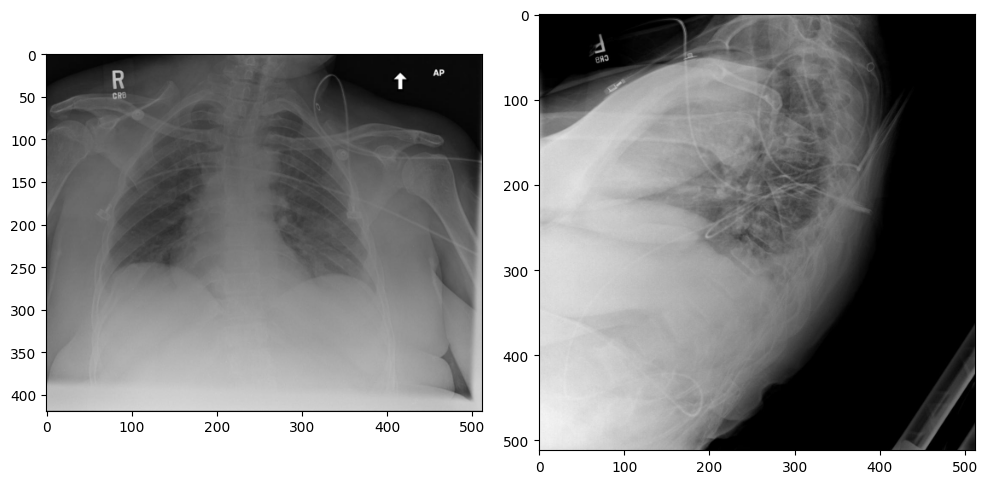

Acutal : <start> no findings <end>
Predicted: <start> no findings right are and lungs focal pleural lobe pleural lobe pleural lobe pleural lobe pleural lobe pleural lobe pleural lobe pleural lobe pleural lobe
BLEU Score :- 9.87783071127706e-232


In [ ]:
test_img_cap(test.values[57])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

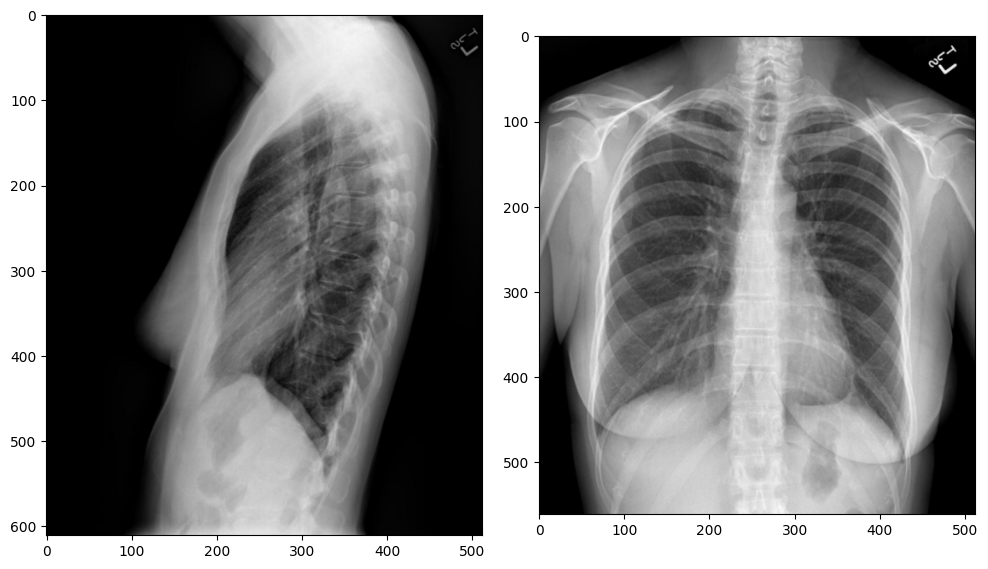

Acutal : <start> heart size and mediastinal contour are normal pulmonary vascularity is normal lungs are hyperexpanded but clear biapical scarring noted no pleural effusions or pneumothoraces <end>
Predicted: <start> no size <start> and lungs focal pleural lobe size <start> and lungs focal pleural lobe size <start> and lungs focal pleural lobe size <start> and
BLEU Score :- 1.0954510217429243e-231


In [ ]:
test_img_cap(test.values[87])

In [ ]:
#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
b1 = 0
b2 = 0
b3 = 0
b4 = 0


for i in range(test.shape[0]):
  image_1 = test['front X-Ray'][i]
  image_2 = test['lateral X-Ray'][i]
  result = evaluate(image_1,image_2)
  reference = test.findings[i]



  b1 =  b1 + bleu.sentence_bleu(reference, result ,weights=(1, 0, 0, 0))
  b2 =  b2 + bleu.sentence_bleu(reference, result ,weights=(0.5, 0.5, 0, 0))
  b3 =  b3 + bleu.sentence_bleu(reference, result ,weights=(0.33, 0.33, 0.33, 0))
  b4 =  b4 + bleu.sentence_bleu(reference, result ,weights=(0.25, 0.25, 0.25, 0.25))



print("Bleu1 score is : ",b1/test.shape[0])
print("Bleu2 score is : ",b2/test.shape[0])
print("Bleu3 score is : ",b3/test.shape[0])
print("Bleu4 score is : ",b4/test.shape[0])

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━

KeyboardInterrupt: 

**Total Observations :**
Total Observations :

For constructing baseline model :

* First I worked on getting structured data.

* limiting the data point to 2 images per data point, if we have 5 images, its 4+1 (all image + last image) so make it as 4 data points, I converted multiple images into two images using their projection. The projection dataset has been taken from kaggle.

* Dataset link : https://www.kaggle.com/raddar/chest-xrays-indiana-university

* I have used simple Encoder-Decoder architacture for basic modelling.

* I have used pre-trained inception-v3 model for Encoder task. Inception model is used for classification task, I modified inception model for our need. I removed last layer of the model then created one extra model. It will take two X-Ray images and return concate tensor of two diffrent image's tensors.

* Then extract the features from Images and did text tokenization and pass these tensors to model for training.

* This is basic model, we used LSTM model with inception generated tensors.

* This model doesn't perform well and give the BLEU Score of 0.27, Because Some medical reports are meaning less and not useful.

* I was not satisfied with this model performance and predictions even it is base model, so I have made some changes and tune the base model.

For tuning I have tried :

I started with 0.001 as learning rate and gradually decrease it by ReduceLROnPlateau callback.

I have decided to use pretrained-CheXNet model's weights instead of inception-v3 which has similar data and 112,120 no of datapoints(X-Ray images).

CheXNet competition link : https://stanfordmlgroup.github.io/projects/chexnet/

Publically Available weight : https://www.kaggle.com/theewok/chexnet-keras-weights

Then I add dropout to learn more robust features in both encoder and decoder layers.

I have also experimented with various batch sizes and observes lower batch size helps to achieve better test accuracy.

Instead of dense layer I used TimeDistributedDense layer. as it applies a same dense to every time step during GRU/LSTM Cell unrolling. So the error function will be between predicted label sequence and the actual label sequence. (Which is normally the requirement for sequence to sequence labeling problems).

This Tuned model gives better predictions then previous model. The inferences are in notebook.

The bleu score has improved from 0.27 to 0.38 which is somewhat satisfactory for baseline model.

I have also used Cumulative N-Gram Scores(BLEU Score). Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.